In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.layers.base import Layer
import time
import matplotlib.pyplot as plt

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST-data',seed=71)
train_imgs = mnist.train.images
train_labels = mnist.train.labels
test_imgs = mnist.test.images
test_labels = mnist.test.labels
valid_imgs = mnist.validation.images
valid_labels = mnist.validation.labels

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [3]:
z_size = 1024
dropout_rate = 0.1
batch_size = 64
train_size = mnist.train.num_examples
valid_size = mnist.validation.num_examples
test_size = mnist.test.num_examples

n_train_iteration = train_size // batch_size
print_every = 100
n_epoch = 200

n_eval_train = n_train_iteration
n_eval_valid = valid_size // batch_size
n_eval_test = test_size // batch_size

In [15]:
class Encoder_conv(Layer):
    def __init__(self, hidden_size):
        pass
    
    
    def __call__(self, inputs, is_train):
        pass
    
    
class Decoder_conv(Layer):
    def __init__(self):
        pass
    
    def __call__(self, inputs, is_train):
        pass

In [13]:
tf.reset_default_graph()
X = tf.placeholder(dtype=tf.float32, shape=[None,784])
is_train = tf.placeholder(dtype=tf.bool)
global_step = tf.Variable(0, trainable=False)

dist_default = tf.distributions.Normal(loc=np.zeros(z_size, dtype=np.float32), scale=np.ones(z_size, dtype=np.float32))

hidden_1 = tf.layers.dense(X, units=512, activation=tf.nn.relu, name="hidden_1")
dropout_1 = tf.layers.dropout(hidden_1, rate=dropout_rate, training=is_train, name="dropout_1")

z_mu = tf.layers.dense(dropout_1, units=z_size, name="z_mu")
z_sig = tf.layers.dense(dropout_1, units=z_size, name="z_sig")

dist_z = tf.distributions.Normal(loc=z_mu, scale=z_sig, name="dist_z")

z_sample = dist_z.sample()

hidden_2 = tf.layers.dense(z_sample, units=512, activation=tf.nn.relu, name="hidden_2")
dropout_2 = tf.layers.dropout(hidden_2, rate=dropout_rate, training=is_train, name="dropout_2")

X_reconstruct = tf.layers.dense(dropout_2, units=784, name="X_reconstruct")

# kl_div = tf.reduce_mean(tf.distributions.kl_divergence(dist_z,dist_default))
kl_div = tf.reduce_mean(tf.reduce_sum(tf.distributions.kl_divergence(dist_z, dist_default), axis=1))
# error = tf.reduce_mean(tf.square(X-X_reconstruct))
error = tf.reduce_mean(tf.reduce_sum(tf.multiply(X-X_reconstruct, X-X_reconstruct),axis=1))
loss = error + kl_div

starter_learning_rate = 1e-3
learning_rate = tf.train.exponential_decay(learning_rate=starter_learning_rate, decay_rate=0.96, decay_steps=n_train_iteration, global_step=global_step)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss, global_step=global_step)

In [9]:
def train():
    for iteration in range(n_train_iteration):
        images, labels = mnist.train.next_batch(batch_size, shuffle=True)
        loss_value,error_value,kl,_ = sess.run([loss,error,kl_div,train_op],
                                                    feed_dict={X:images, is_train:True})
        
        if (iteration+1)%print_every == 0:
            print("[iteration %d]loss=%f(%f+%f)"%(iteration+1,loss_value, error_value, kl))
            
def evalutaion():
    train_loss, valid_loss, test_loss=0.,0.,0.
    train_err, valid_err, test_err = 0.,0.,0.
    train_kl, valid_kl, test_kl = 0.,0.,0.
    train_origin, train_new = 0.,0.
    valid_origin, valid_new = 0.,0.
    test_origin, test_new = 0.,0.
    train_label, valid_label,test_label = 0,0,0
    
    for i in range(n_eval_train):
        images,labels = mnist.train.next_batch(batch_size, shuffle=True)
        loss_value,error_value,kl,img_reconstruct = sess.run([loss,error,kl_div,X_reconstruct],feed_dict={X:images, is_train:False})
        train_loss += loss_value
        train_err += error_value
        train_kl += kl
        if (i+1) == n_eval_train:
            train_origin = images[0].reshape(28,28)
            train_new = img_reconstruct[0].reshape(28,28)
            train_label = labels[0]
    train_loss /= n_eval_train
    train_err /= n_eval_train
    train_kl /= n_eval_train
    
    for i in range(n_eval_valid):
        images,labels = mnist.validation.next_batch(batch_size, shuffle=True)
        loss_value,error_value,kl,img_reconstruct = sess.run([loss,error,kl_div,X_reconstruct],feed_dict={X:images, is_train:False})
        valid_loss += loss_value
        valid_err += error_value
        valid_kl += kl
        if (i+1) == n_eval_valid:
            valid_origin = images[0].reshape(28,28)
            valid_new = img_reconstruct[0].reshape(28,28)
            valid_label = labels[0]
    valid_loss /= n_eval_valid
    valid_err /= n_eval_valid
    valid_kl /= n_eval_valid
    
    for i in range(n_eval_test):
        images,labels = mnist.test.next_batch(batch_size, shuffle=True)
        loss_value,error_value,kl,img_reconstruct = sess.run([loss,error,kl_div,X_reconstruct],feed_dict={X:images, is_train:False})
        test_loss += loss_value
        test_err += error_value
        test_kl += kl
        if (i+1) == n_eval_test:
            test_origin = images[0].reshape(28,28)
            test_new = img_reconstruct[0].reshape(28,28)
            test_label = labels[0]
    test_loss /= n_eval_test
    test_err /= n_eval_test
    test_kl /= n_eval_test
    
    print("Training loss = %f(%f+%f), label=%d"%(train_loss, train_err, train_kl, train_label))
    plt.subplot(121)
    plt.title("Origin")
    plt.imshow(train_origin)
    plt.subplot(122)
    plt.title("Reconstruct")
    plt.imshow(train_new)
    plt.show()
    
    print("Validation loss = %f(%f+%f), label=%d"%(valid_loss, valid_err, valid_kl, valid_label))
    plt.subplot(121)
    plt.title("Origin")
    plt.imshow(valid_origin)
    plt.subplot(122)
    plt.title("Reconstruct")
    plt.imshow(valid_new)
    plt.show()
    
    print("Testing loss = %f(%f+%f), label=%d"%(test_loss, test_err, test_kl, test_label))
    plt.subplot(121)
    plt.title("Origin")
    plt.imshow(test_origin)
    plt.subplot(122)
    plt.title("Reconstruct")
    plt.imshow(test_new)
    plt.show()
    
    

[Epoch 1] 15:59:51
[iteration 100]loss=176.568619(59.851093+116.717522)
[iteration 200]loss=134.782837(49.598892+85.183952)
[iteration 300]loss=104.506104(49.117901+55.388199)
[iteration 400]loss=86.229713(44.418068+41.811646)
[iteration 500]loss=85.336533(45.524803+39.811726)
[iteration 600]loss=77.787956(45.722847+32.065109)
[iteration 700]loss=69.016235(40.660530+28.355701)
[iteration 800]loss=62.751995(39.903374+22.848621)
Training loss = 57.998719(40.188632+17.810087), label=2


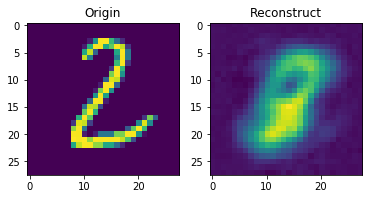

Validation loss = 57.897542(40.012278+17.885264), label=9


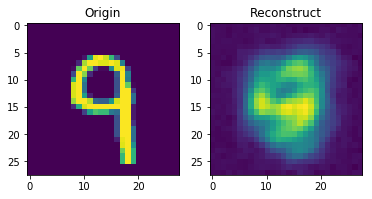

Testing loss = 57.886058(40.068653+17.817404), label=0


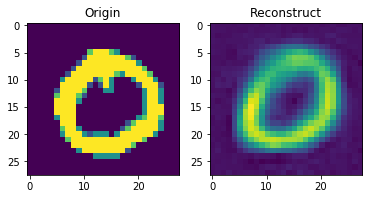

[Epoch 2] 15:59:56
[iteration 100]loss=66.647522(44.139679+22.507847)
[iteration 200]loss=60.631012(39.617905+21.013107)
[iteration 300]loss=58.861534(39.237259+19.624275)
[iteration 400]loss=59.033573(42.339310+16.694263)
[iteration 500]loss=60.699471(42.962841+17.736629)
[iteration 600]loss=57.077919(40.050644+17.027275)
[iteration 700]loss=54.555107(38.093014+16.462093)
[iteration 800]loss=50.563759(36.091114+14.472647)
Training loss = 49.977926(38.095577+11.882349), label=0


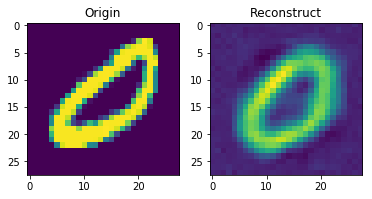

Validation loss = 50.009426(38.014544+11.994881), label=7


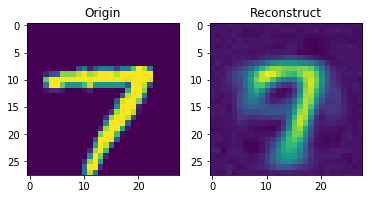

Testing loss = 49.876977(37.928497+11.948480), label=4


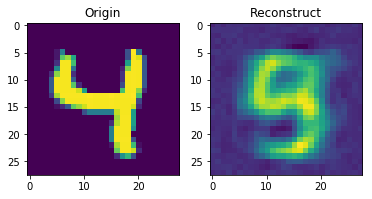

[Epoch 3] 16:00:01
[iteration 100]loss=56.920940(42.791534+14.129407)
[iteration 200]loss=55.406654(41.439789+13.966866)
[iteration 300]loss=56.015911(40.623817+15.392095)
[iteration 400]loss=53.833412(38.795708+15.037706)
[iteration 500]loss=50.233578(37.308182+12.925396)
[iteration 600]loss=52.147453(38.945484+13.201969)
[iteration 700]loss=52.197052(38.822449+13.374605)
[iteration 800]loss=54.133492(40.802822+13.330667)
Training loss = 47.780853(36.985221+10.795632), label=9


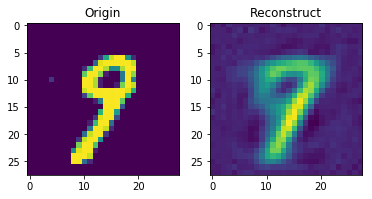

Validation loss = 47.550733(36.633962+10.916771), label=5


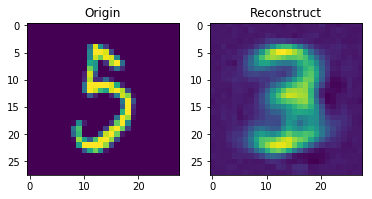

Testing loss = 47.703075(36.757249+10.945826), label=8


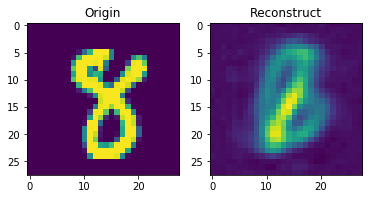

[Epoch 4] 16:00:06
[iteration 100]loss=49.623455(36.886131+12.737325)
[iteration 200]loss=51.188881(39.268646+11.920233)
[iteration 300]loss=51.080734(38.478394+12.602339)
[iteration 400]loss=50.538460(39.212086+11.326376)
[iteration 500]loss=50.529766(38.908493+11.621272)
[iteration 600]loss=48.481552(36.740524+11.741028)
[iteration 700]loss=47.831039(35.565105+12.265936)
[iteration 800]loss=50.145565(36.828346+13.317219)
Training loss = 45.549960(36.549646+9.000313), label=4


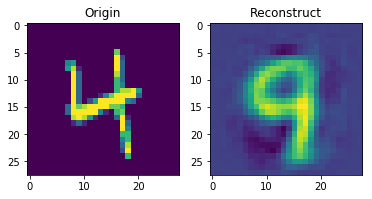

Validation loss = 45.493320(36.324088+9.169233), label=9


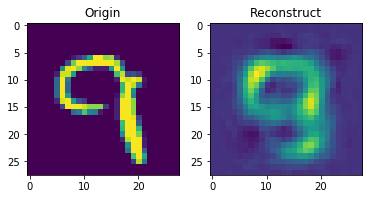

Testing loss = 45.534582(36.398951+9.135631), label=5


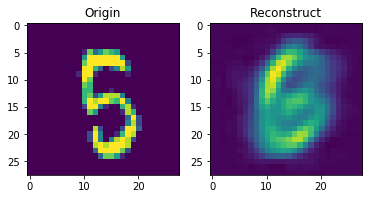

[Epoch 5] 16:00:11
[iteration 100]loss=50.741058(39.731186+11.009874)
[iteration 200]loss=48.661999(37.585068+11.076931)
[iteration 300]loss=47.231300(36.718853+10.512447)
[iteration 400]loss=48.175220(37.482662+10.692557)
[iteration 500]loss=48.696136(38.246635+10.449500)
[iteration 600]loss=46.702293(35.242661+11.459633)
[iteration 700]loss=47.481346(37.592171+9.889177)
[iteration 800]loss=47.349167(36.056923+11.292246)
Training loss = 44.781278(36.058664+8.722614), label=6


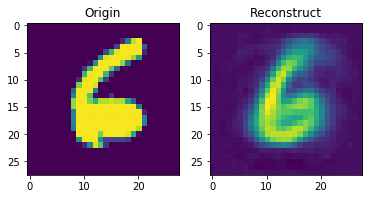

Validation loss = 44.848232(35.992253+8.855979), label=3


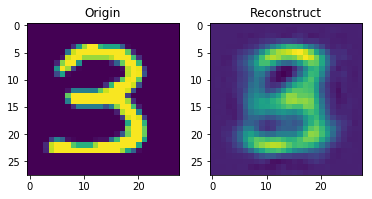

Testing loss = 44.874350(36.000192+8.874158), label=9


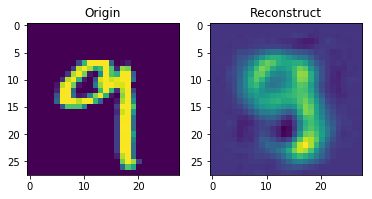

[Epoch 6] 16:00:16
[iteration 100]loss=45.448326(35.553669+9.894657)
[iteration 200]loss=47.690067(36.815804+10.874264)
[iteration 300]loss=45.801071(34.811066+10.990007)
[iteration 400]loss=48.170265(36.977234+11.193031)
[iteration 500]loss=50.188965(39.796551+10.392413)
[iteration 600]loss=46.870255(36.824959+10.045294)
[iteration 700]loss=46.861378(36.728607+10.132770)
[iteration 800]loss=48.183945(38.042217+10.141729)
Training loss = 44.257015(35.570498+8.686517), label=8


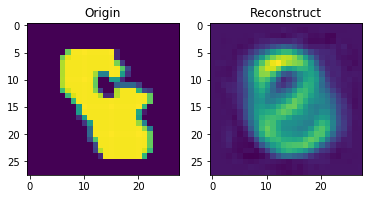

Validation loss = 43.949433(35.144498+8.804936), label=4


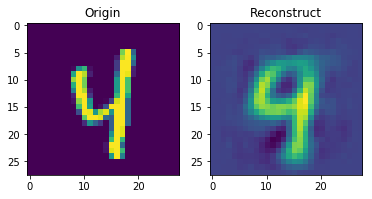

Testing loss = 44.138971(35.281611+8.857360), label=6


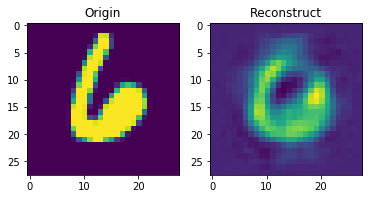

[Epoch 7] 16:00:21
[iteration 100]loss=48.052498(37.856010+10.196489)
[iteration 200]loss=48.552868(38.843506+9.709362)
[iteration 300]loss=47.437195(37.341515+10.095680)
[iteration 400]loss=46.315498(36.560684+9.754814)
[iteration 500]loss=46.132294(36.620045+9.512251)
[iteration 600]loss=44.537281(35.054680+9.482600)
[iteration 700]loss=44.152901(33.880898+10.272001)
[iteration 800]loss=44.956589(34.570717+10.385872)
Training loss = 43.739736(35.606802+8.132933), label=1


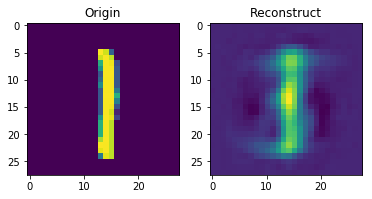

Validation loss = 43.455808(35.135287+8.320520), label=7


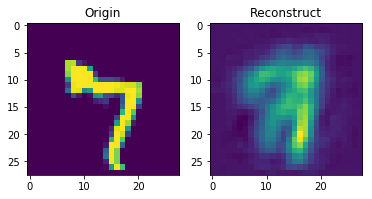

Testing loss = 43.555313(35.346740+8.208573), label=1


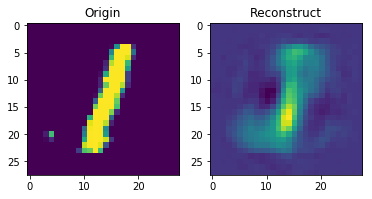

[Epoch 8] 16:00:26
[iteration 100]loss=45.366379(36.270920+9.095461)
[iteration 200]loss=45.982098(34.974731+11.007366)
[iteration 300]loss=42.692448(33.638916+9.053532)
[iteration 400]loss=46.516739(37.337753+9.178986)
[iteration 500]loss=47.780960(38.234871+9.546091)
[iteration 600]loss=45.465672(35.644577+9.821095)
[iteration 700]loss=45.925152(36.339127+9.586026)
[iteration 800]loss=42.094353(32.749420+9.344933)
Training loss = 43.250718(35.115960+8.134758), label=8


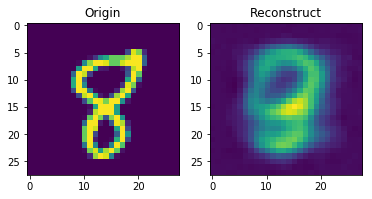

Validation loss = 43.126513(34.836881+8.289632), label=0


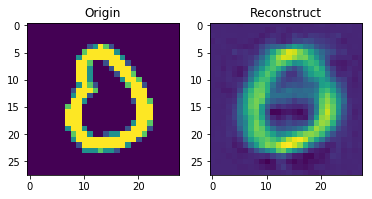

Testing loss = 43.075145(34.800648+8.274497), label=0


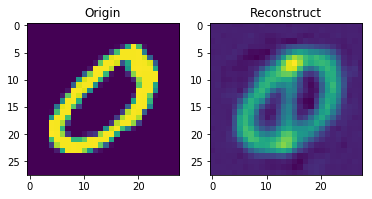

[Epoch 9] 16:00:31
[iteration 100]loss=48.656025(38.993031+9.662994)
[iteration 200]loss=44.493961(34.659782+9.834180)
[iteration 300]loss=45.819153(36.838543+8.980608)
[iteration 400]loss=43.041924(33.877472+9.164453)
[iteration 500]loss=43.920494(34.569962+9.350534)
[iteration 600]loss=43.933754(34.440491+9.493265)
[iteration 700]loss=46.304115(37.224709+9.079406)
[iteration 800]loss=42.782906(33.309593+9.473312)
Training loss = 42.875360(34.653021+8.222339), label=9


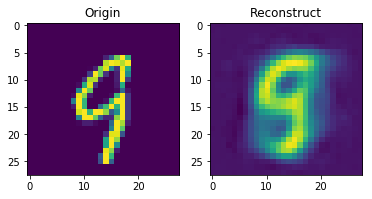

Validation loss = 42.622871(34.305520+8.317351), label=2


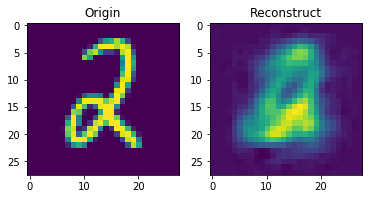

Testing loss = 42.782797(34.459911+8.322886), label=1


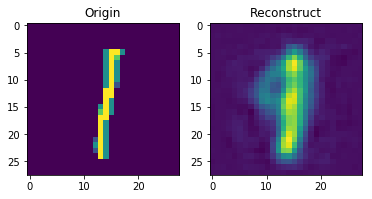

[Epoch 10] 16:00:36
[iteration 100]loss=43.749485(34.552139+9.197346)
[iteration 200]loss=46.022453(36.256062+9.766394)
[iteration 300]loss=43.974220(34.825150+9.149073)
[iteration 400]loss=46.673637(36.681488+9.992149)
[iteration 500]loss=43.200787(33.669941+9.530845)
[iteration 600]loss=44.226723(35.309067+8.917656)
[iteration 700]loss=45.268284(36.424236+8.844048)
[iteration 800]loss=46.619362(36.648201+9.971163)
Training loss = 42.798201(35.016635+7.781565), label=8


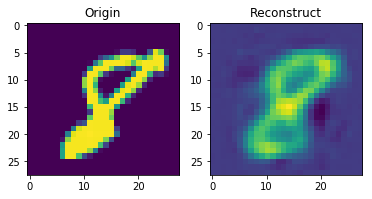

Validation loss = 42.553570(34.666826+7.886744), label=8


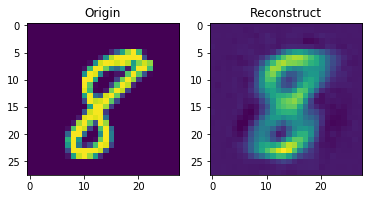

Testing loss = 42.582779(34.714833+7.867946), label=8


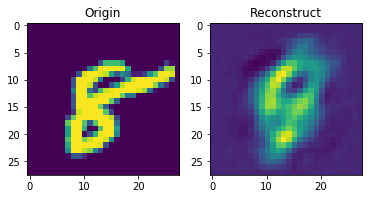

[Epoch 11] 16:00:42
[iteration 100]loss=42.747498(34.278706+8.468792)
[iteration 200]loss=44.097443(35.118652+8.978788)
[iteration 300]loss=45.594193(36.745117+8.849075)
[iteration 400]loss=41.821342(32.711964+9.109379)
[iteration 500]loss=41.019485(32.219254+8.800234)
[iteration 600]loss=43.185898(34.073353+9.112545)
[iteration 700]loss=44.665081(35.657059+9.008022)
[iteration 800]loss=45.068859(35.536835+9.532023)
Training loss = 42.353122(34.460307+7.892815), label=1


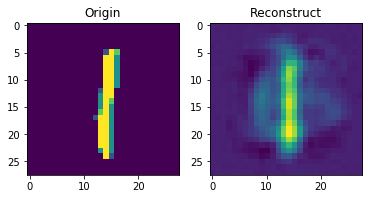

Validation loss = 42.134148(34.125354+8.008794), label=1


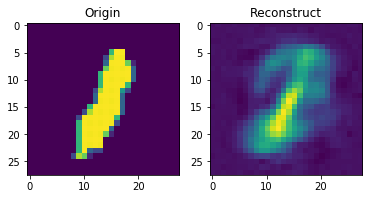

Testing loss = 42.263873(34.241092+8.022781), label=1


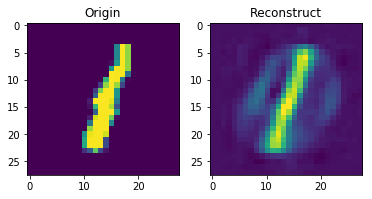

[Epoch 12] 16:00:47
[iteration 100]loss=46.024281(36.198723+9.825558)
[iteration 200]loss=46.003716(35.632454+10.371262)
[iteration 300]loss=47.021542(38.228191+8.793350)
[iteration 400]loss=44.078011(35.823715+8.254295)
[iteration 500]loss=43.801731(35.225742+8.575989)
[iteration 600]loss=46.633396(37.159382+9.474015)
[iteration 700]loss=44.831432(36.102272+8.729161)
[iteration 800]loss=44.943466(35.872406+9.071059)
Training loss = 42.224181(33.993166+8.231015), label=7


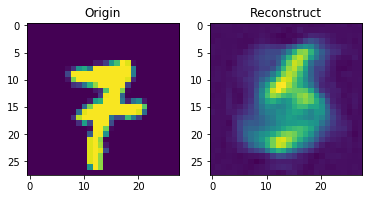

Validation loss = 41.854564(33.459442+8.395123), label=6


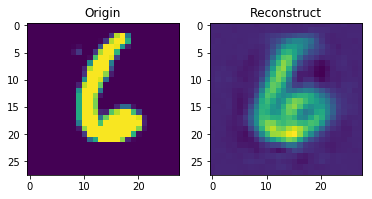

Testing loss = 42.155952(33.807656+8.348296), label=6


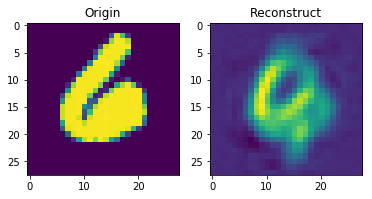

[Epoch 13] 16:00:51
[iteration 100]loss=45.213936(36.797043+8.416894)
[iteration 200]loss=44.527550(35.491394+9.036157)
[iteration 300]loss=42.622604(34.454670+8.167936)
[iteration 400]loss=45.821270(35.788074+10.033195)
[iteration 500]loss=42.878632(34.170006+8.708624)
[iteration 600]loss=44.039745(34.792320+9.247424)
[iteration 700]loss=45.031372(35.789753+9.241618)
[iteration 800]loss=42.071335(33.457321+8.614016)
Training loss = 41.806175(33.837635+7.968540), label=9


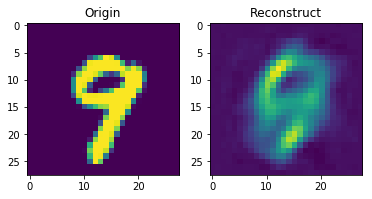

Validation loss = 41.618654(33.448054+8.170600), label=3


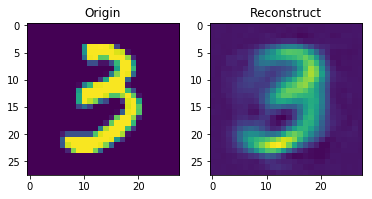

Testing loss = 41.779462(33.694103+8.085358), label=6


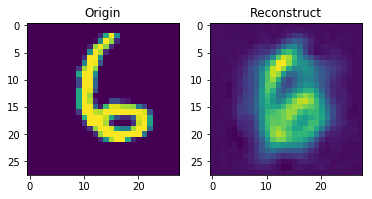

[Epoch 14] 16:00:56
[iteration 100]loss=44.979340(35.925484+9.053858)
[iteration 200]loss=45.874119(37.475281+8.398839)
[iteration 300]loss=43.567001(34.408051+9.158949)
[iteration 400]loss=41.809654(33.075470+8.734184)
[iteration 500]loss=42.916740(33.756187+9.160554)
[iteration 600]loss=43.021843(34.038414+8.983430)
[iteration 700]loss=43.414440(35.116798+8.297642)
[iteration 800]loss=43.306843(33.778023+9.528819)
Training loss = 41.783215(33.758161+8.025054), label=4


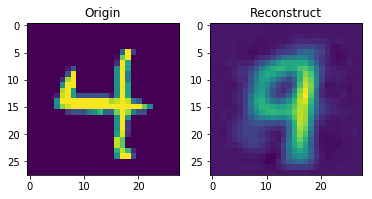

Validation loss = 41.366363(33.251083+8.115280), label=3


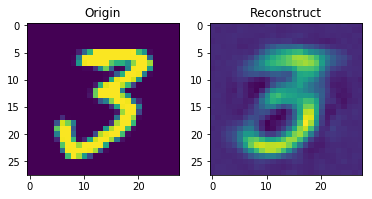

Testing loss = 41.658987(33.553767+8.105220), label=1


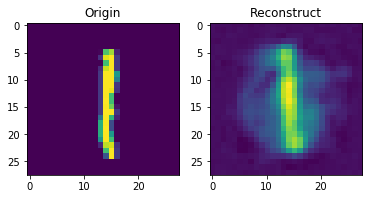

[Epoch 15] 16:01:01
[iteration 100]loss=45.746651(36.686554+9.060098)
[iteration 200]loss=42.375515(32.980499+9.395015)
[iteration 300]loss=41.589581(33.316837+8.272743)
[iteration 400]loss=40.691193(31.982628+8.708567)
[iteration 500]loss=42.663681(34.307030+8.356653)
[iteration 600]loss=41.562088(33.383430+8.178656)
[iteration 700]loss=41.460777(33.069782+8.390995)
[iteration 800]loss=43.869911(34.637444+9.232466)
Training loss = 41.700330(33.586392+8.113938), label=1


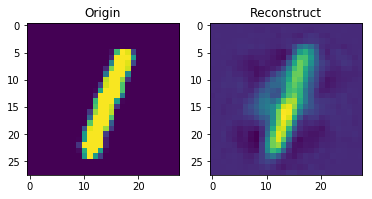

Validation loss = 41.373606(33.164451+8.209155), label=8


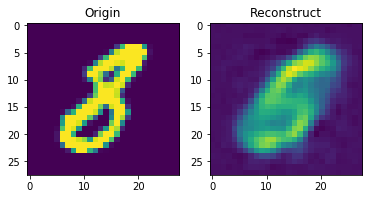

Testing loss = 41.557844(33.344622+8.213222), label=6


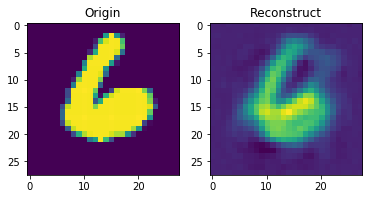

[Epoch 16] 16:01:07
[iteration 100]loss=41.654984(32.366299+9.288685)
[iteration 200]loss=42.209610(33.517578+8.692030)
[iteration 300]loss=41.479877(32.478981+9.000896)
[iteration 400]loss=43.883507(34.825958+9.057549)
[iteration 500]loss=42.547470(34.203236+8.344233)
[iteration 600]loss=42.512154(33.358986+9.153167)
[iteration 700]loss=44.898319(35.669632+9.228687)
[iteration 800]loss=40.656570(32.077957+8.578615)
Training loss = 41.458643(33.622972+7.835671), label=6


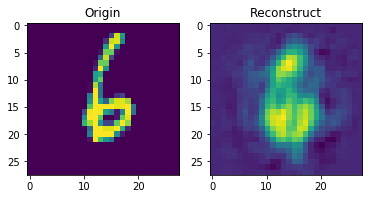

Validation loss = 41.381259(33.367063+8.014196), label=3


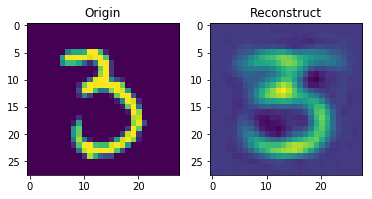

Testing loss = 41.320232(33.405098+7.915134), label=3


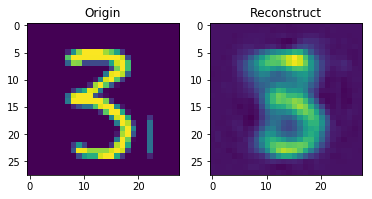

[Epoch 17] 16:01:12
[iteration 100]loss=42.698917(34.258087+8.440830)
[iteration 200]loss=43.836102(34.866501+8.969601)
[iteration 300]loss=43.233147(34.882183+8.350965)
[iteration 400]loss=41.817245(32.579788+9.237457)
[iteration 500]loss=41.917870(33.446606+8.471266)
[iteration 600]loss=45.227032(36.628864+8.598168)
[iteration 700]loss=42.954849(34.758728+8.196122)
[iteration 800]loss=42.718788(34.370132+8.348658)
Training loss = 41.378972(33.214931+8.164041), label=9


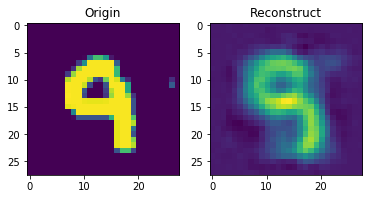

Validation loss = 41.070402(32.754593+8.315810), label=6


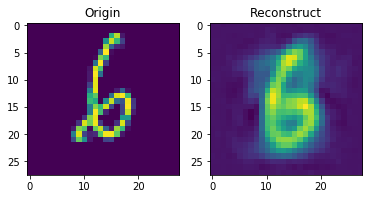

Testing loss = 41.398700(33.183159+8.215542), label=4


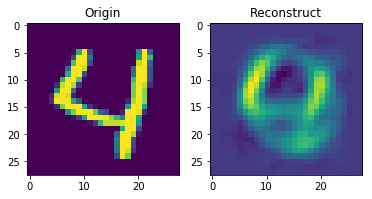

[Epoch 18] 16:01:17
[iteration 100]loss=42.034473(32.998657+9.035816)
[iteration 200]loss=42.296486(33.465462+8.831022)
[iteration 300]loss=43.400864(34.098900+9.301964)
[iteration 400]loss=42.041096(32.891304+9.149793)
[iteration 500]loss=42.509022(34.126842+8.382178)
[iteration 600]loss=43.429535(34.993935+8.435599)
[iteration 700]loss=44.707905(36.690804+8.017101)
[iteration 800]loss=44.204933(35.533970+8.670963)
Training loss = 41.218117(32.945933+8.272184), label=8


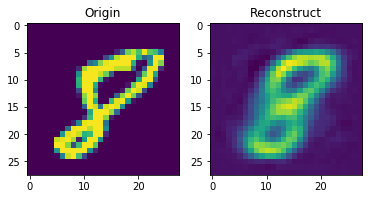

Validation loss = 41.054435(32.670817+8.383618), label=5


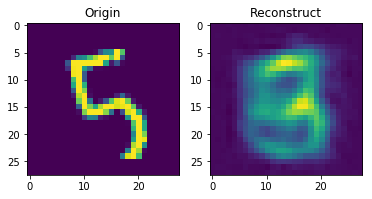

Testing loss = 41.110482(32.767201+8.343282), label=6


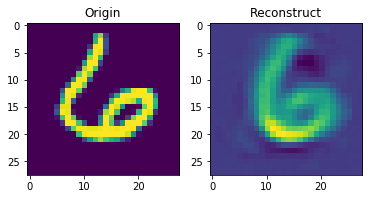

[Epoch 19] 16:01:22
[iteration 100]loss=40.005230(31.593538+8.411691)
[iteration 200]loss=42.983471(33.974266+9.009205)
[iteration 300]loss=44.086388(35.679779+8.406609)
[iteration 400]loss=43.907566(34.943817+8.963750)
[iteration 500]loss=41.931091(33.400951+8.530142)
[iteration 600]loss=44.553043(35.410622+9.142422)
[iteration 700]loss=43.525833(34.419327+9.106504)
[iteration 800]loss=45.063538(35.907242+9.156296)
Training loss = 41.120261(32.782356+8.337905), label=3


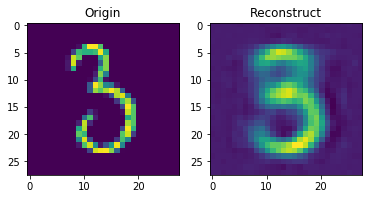

Validation loss = 40.777286(32.316077+8.461209), label=8


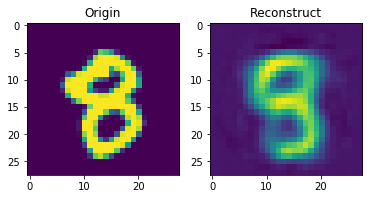

Testing loss = 41.194101(32.773310+8.420791), label=2


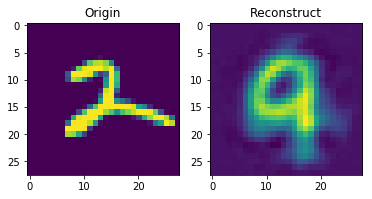

[Epoch 20] 16:01:27
[iteration 100]loss=42.963787(33.499973+9.463814)
[iteration 200]loss=39.740414(31.202456+8.537958)
[iteration 300]loss=44.580376(36.291653+8.288725)
[iteration 400]loss=44.188541(34.415222+9.773319)
[iteration 500]loss=41.196342(32.329803+8.866541)
[iteration 600]loss=41.147800(32.640785+8.507014)
[iteration 700]loss=41.450203(32.038113+9.412088)
[iteration 800]loss=45.359951(36.933189+8.426762)
Training loss = 41.059117(33.094950+7.964167), label=1


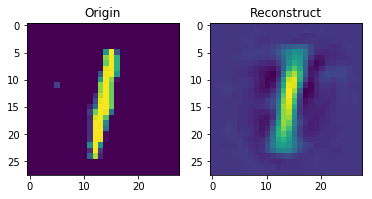

Validation loss = 40.838083(32.740721+8.097361), label=5


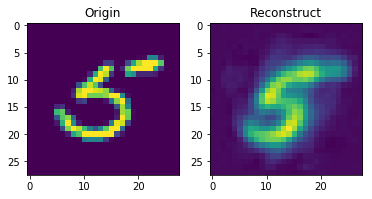

Testing loss = 41.094061(33.043486+8.050574), label=4


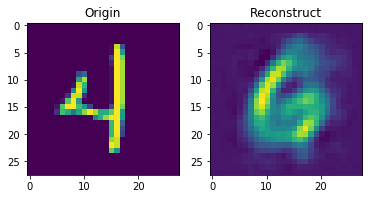

[Epoch 21] 16:01:32
[iteration 100]loss=40.631256(31.772518+8.858738)
[iteration 200]loss=43.183128(34.161037+9.022089)
[iteration 300]loss=42.219898(33.217850+9.002049)
[iteration 400]loss=41.282608(32.689175+8.593433)
[iteration 500]loss=45.012341(36.060516+8.951824)
[iteration 600]loss=41.525307(33.341141+8.184164)
[iteration 700]loss=44.234947(35.069382+9.165567)
[iteration 800]loss=42.152306(33.485119+8.667189)
Training loss = 40.907240(32.569231+8.338009), label=6


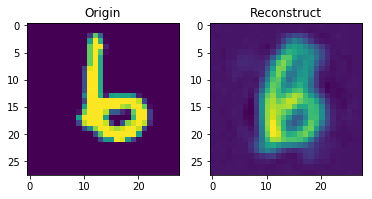

Validation loss = 40.806670(32.359017+8.447652), label=6


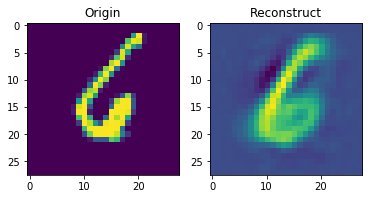

Testing loss = 40.698562(32.325380+8.373182), label=0


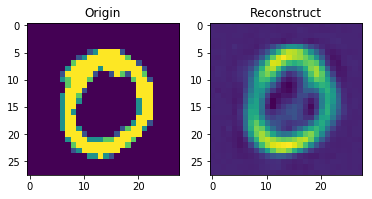

[Epoch 22] 16:01:37
[iteration 100]loss=45.484303(36.466965+9.017339)
[iteration 200]loss=41.924110(33.519394+8.404715)
[iteration 300]loss=42.383064(34.068192+8.314875)
[iteration 400]loss=41.916748(33.280945+8.635803)
[iteration 500]loss=42.350380(32.975372+9.375008)
[iteration 600]loss=41.531647(32.266708+9.264936)
[iteration 700]loss=42.557487(34.060787+8.496699)
[iteration 800]loss=41.382477(32.907066+8.475412)
Training loss = 41.031309(32.531785+8.499525), label=7


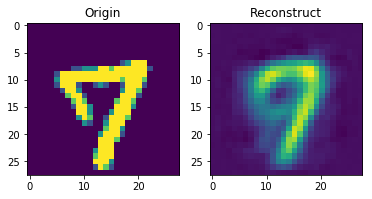

Validation loss = 40.686708(32.064123+8.622586), label=6


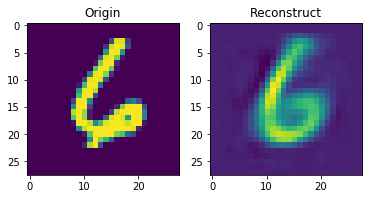

Testing loss = 40.980411(32.414353+8.566057), label=6


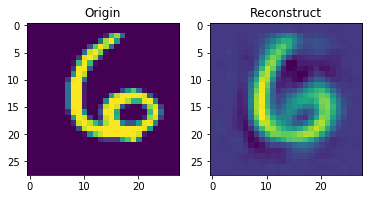

[Epoch 23] 16:01:42
[iteration 100]loss=40.398750(32.275581+8.123168)
[iteration 200]loss=44.228569(35.123856+9.104713)
[iteration 300]loss=43.853191(35.080025+8.773167)
[iteration 400]loss=41.747959(32.855362+8.892597)
[iteration 500]loss=44.121407(35.012688+9.108717)
[iteration 600]loss=42.780411(34.191921+8.588490)
[iteration 700]loss=43.011158(34.126499+8.884659)
[iteration 800]loss=41.922508(33.376610+8.545900)
Training loss = 40.848387(32.853970+7.994417), label=8


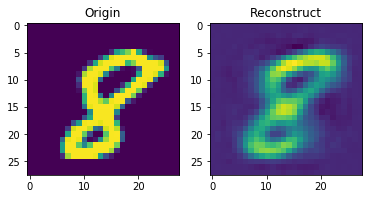

Validation loss = 40.495221(32.416413+8.078808), label=0


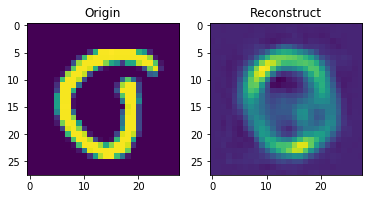

Testing loss = 40.631547(32.568647+8.062901), label=2


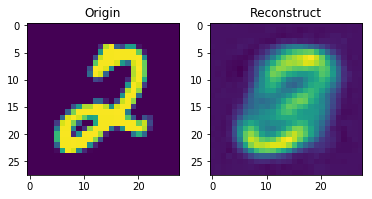

[Epoch 24] 16:01:47
[iteration 100]loss=40.115059(31.960506+8.154552)
[iteration 200]loss=40.606396(31.606037+9.000359)
[iteration 300]loss=39.150711(30.695217+8.455496)
[iteration 400]loss=43.476654(34.719704+8.756952)
[iteration 500]loss=43.777786(34.979401+8.798384)
[iteration 600]loss=41.813416(33.126530+8.686886)
[iteration 700]loss=47.552757(38.164867+9.387892)
[iteration 800]loss=43.004570(33.949959+9.054613)
Training loss = 40.660409(32.352562+8.307846), label=1


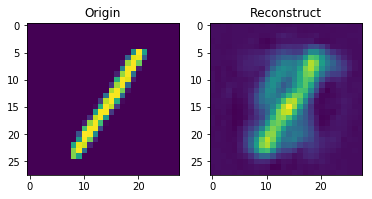

Validation loss = 40.489924(32.066792+8.423132), label=5


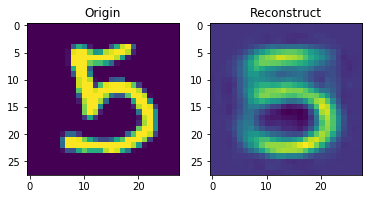

Testing loss = 40.583814(32.200212+8.383602), label=7


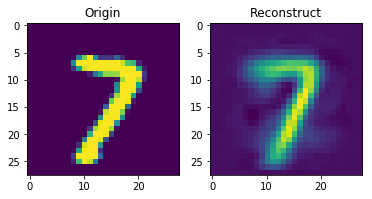

[Epoch 25] 16:01:52
[iteration 100]loss=42.538475(34.052551+8.485925)
[iteration 200]loss=41.600433(33.078392+8.522041)
[iteration 300]loss=40.943939(33.107742+7.836199)
[iteration 400]loss=43.137592(34.747818+8.389773)
[iteration 500]loss=40.523796(31.681049+8.842748)
[iteration 600]loss=44.259933(35.788212+8.471721)
[iteration 700]loss=40.025513(32.454197+7.571315)
[iteration 800]loss=41.101925(32.041763+9.060162)
Training loss = 40.697780(32.647201+8.050579), label=3


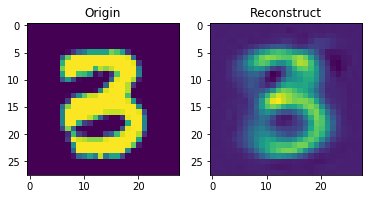

Validation loss = 40.324209(32.196566+8.127643), label=6


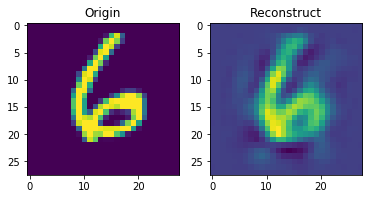

Testing loss = 40.512487(32.400168+8.112319), label=8


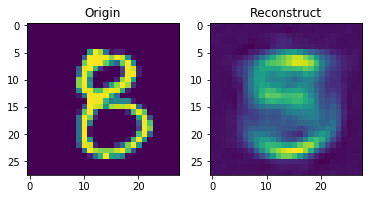

[Epoch 26] 16:01:57
[iteration 100]loss=43.527866(34.266495+9.261372)
[iteration 200]loss=42.897457(34.234745+8.662711)
[iteration 300]loss=41.270157(32.449657+8.820498)
[iteration 400]loss=42.966061(34.367771+8.598289)
[iteration 500]loss=41.666580(33.350582+8.316000)
[iteration 600]loss=40.701111(31.824524+8.876585)
[iteration 700]loss=40.604408(31.850891+8.753515)
[iteration 800]loss=41.725273(33.218235+8.507038)
Training loss = 40.545688(32.399316+8.146371), label=9


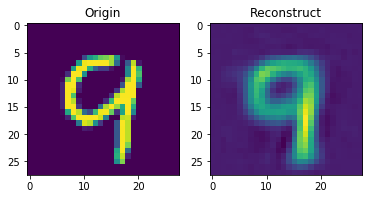

Validation loss = 40.463321(32.227819+8.235503), label=2


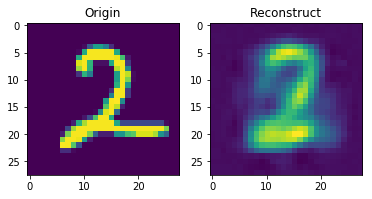

Testing loss = 40.370898(32.183296+8.187602), label=6


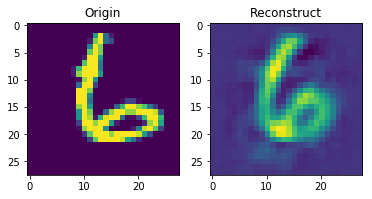

[Epoch 27] 16:02:02
[iteration 100]loss=42.366547(33.954403+8.412146)
[iteration 200]loss=42.887672(33.638382+9.249289)
[iteration 300]loss=40.670284(31.990511+8.679773)
[iteration 400]loss=40.964497(32.071987+8.892509)
[iteration 500]loss=40.370918(31.876595+8.494326)
[iteration 600]loss=44.247993(35.399803+8.848188)
[iteration 700]loss=41.409683(33.141487+8.268198)
[iteration 800]loss=39.588223(31.573950+8.014273)
Training loss = 40.381483(31.989379+8.392104), label=2


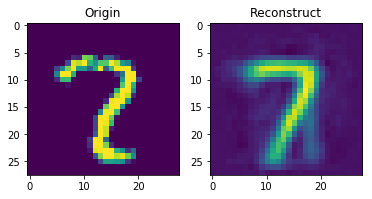

Validation loss = 40.074535(31.597868+8.476667), label=9


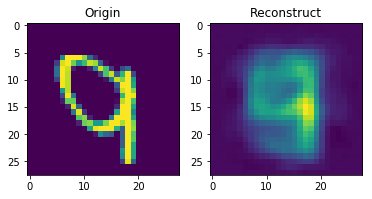

Testing loss = 40.457018(31.950962+8.506056), label=2


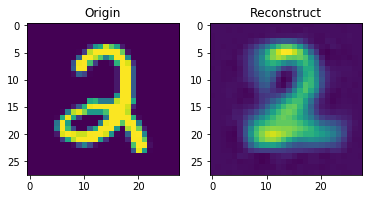

[Epoch 28] 16:02:07
[iteration 100]loss=41.607689(32.718361+8.889326)
[iteration 200]loss=40.284622(31.463188+8.821436)
[iteration 300]loss=43.429558(34.571182+8.858377)
[iteration 400]loss=41.839603(32.985283+8.854321)
[iteration 500]loss=41.250172(32.514114+8.736057)
[iteration 600]loss=44.126923(34.896584+9.230339)
[iteration 700]loss=43.682236(34.283642+9.398592)
[iteration 800]loss=41.528961(33.143684+8.385275)
Training loss = 40.269614(32.253630+8.015984), label=9


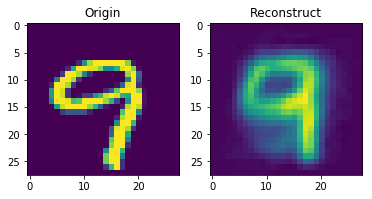

Validation loss = 39.965340(31.856271+8.109069), label=4


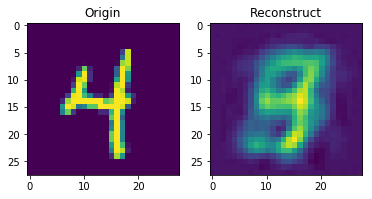

Testing loss = 40.250542(32.159276+8.091266), label=3


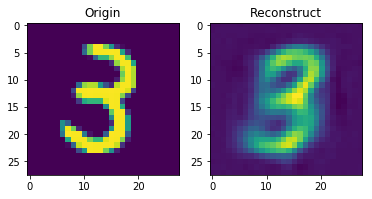

[Epoch 29] 16:02:12
[iteration 100]loss=42.796761(35.041290+7.755470)
[iteration 200]loss=42.437439(33.454338+8.983101)
[iteration 300]loss=43.341583(35.018044+8.323538)
[iteration 400]loss=40.687782(32.961327+7.726455)
[iteration 500]loss=39.826073(31.210463+8.615610)
[iteration 600]loss=40.671928(32.348846+8.323081)
[iteration 700]loss=43.470116(34.719627+8.750490)
[iteration 800]loss=42.411774(33.431984+8.979788)
Training loss = 40.336776(31.953000+8.383775), label=2


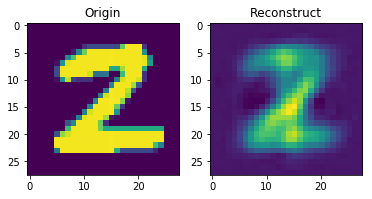

Validation loss = 40.067370(31.602870+8.464501), label=7


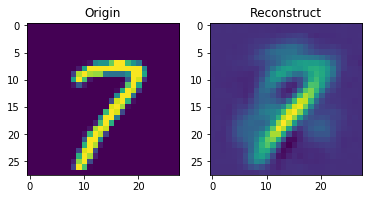

Testing loss = 40.157064(31.721247+8.435817), label=1


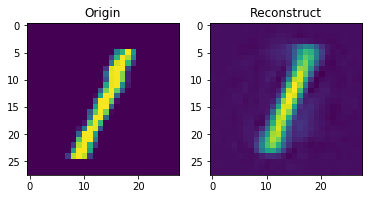

[Epoch 30] 16:02:16
[iteration 100]loss=41.280098(33.420422+7.859674)
[iteration 200]loss=40.454994(31.706039+8.748953)
[iteration 300]loss=43.579430(34.659637+8.919793)
[iteration 400]loss=43.865204(35.007195+8.858011)
[iteration 500]loss=41.009346(33.050694+7.958654)
[iteration 600]loss=42.310329(34.227867+8.082462)
[iteration 700]loss=41.858875(32.951309+8.907565)
[iteration 800]loss=41.250648(32.112350+9.138299)
Training loss = 40.170404(31.879071+8.291333), label=5


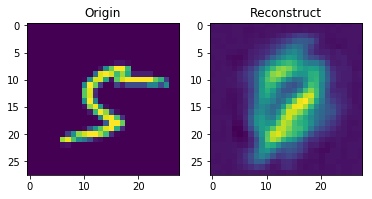

Validation loss = 40.103161(31.679885+8.423276), label=9


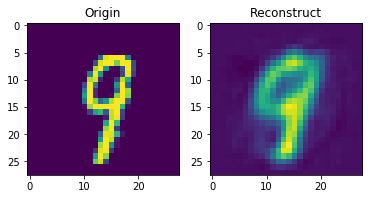

Testing loss = 40.165480(31.798981+8.366499), label=9


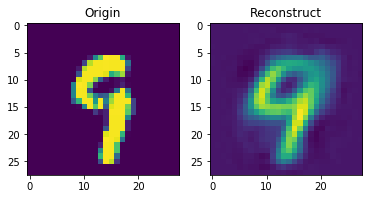

[Epoch 31] 16:02:21
[iteration 100]loss=41.469444(32.955048+8.514396)
[iteration 200]loss=44.402161(35.383156+9.019003)
[iteration 300]loss=41.004906(32.390060+8.614844)
[iteration 400]loss=39.775078(31.026819+8.748259)
[iteration 500]loss=43.098499(34.072044+9.026454)
[iteration 600]loss=40.766533(32.625320+8.141211)
[iteration 700]loss=41.797821(32.981300+8.816519)
[iteration 800]loss=42.568382(34.154213+8.414169)
Training loss = 40.270650(32.151354+8.119297), label=1


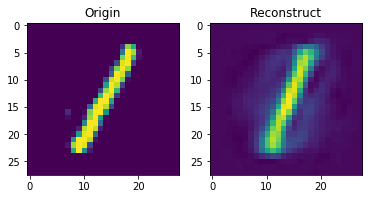

Validation loss = 39.963269(31.759591+8.203678), label=8


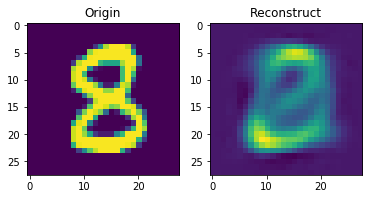

Testing loss = 40.273194(32.105386+8.167807), label=7


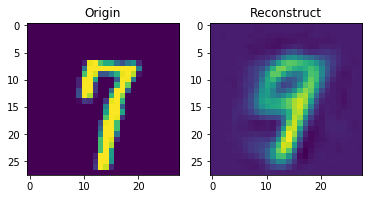

[Epoch 32] 16:02:25
[iteration 100]loss=41.906761(33.494308+8.412455)
[iteration 200]loss=41.352104(33.650276+7.701829)
[iteration 300]loss=40.723248(32.426201+8.297047)
[iteration 400]loss=45.272293(36.073372+9.198921)
[iteration 500]loss=41.836311(32.539833+9.296476)
[iteration 600]loss=40.864662(31.532997+9.331667)
[iteration 700]loss=41.505302(33.124313+8.380988)
[iteration 800]loss=44.376465(35.618099+8.758364)
Training loss = 40.074105(32.033075+8.041031), label=7


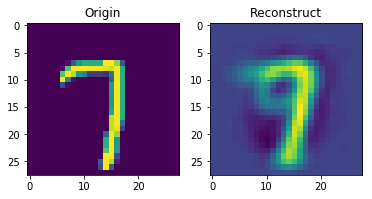

Validation loss = 39.830697(31.739036+8.091661), label=0


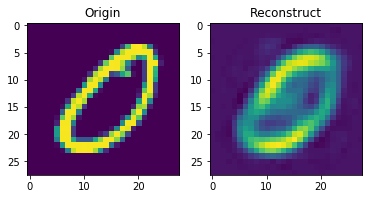

Testing loss = 40.060356(31.955609+8.104748), label=7


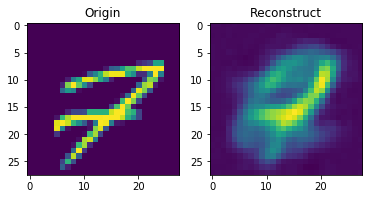

[Epoch 33] 16:02:30
[iteration 100]loss=39.327980(31.309597+8.018384)
[iteration 200]loss=40.555508(32.551678+8.003830)
[iteration 300]loss=45.179787(36.116699+9.063088)
[iteration 400]loss=40.781944(32.218105+8.563837)
[iteration 500]loss=42.168716(33.619282+8.549435)
[iteration 600]loss=40.386581(31.744804+8.641776)
[iteration 700]loss=42.881187(34.826267+8.054919)
[iteration 800]loss=39.766911(31.080338+8.686573)
Training loss = 40.153955(32.088077+8.065877), label=6


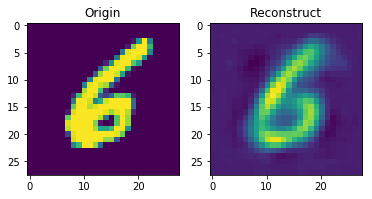

Validation loss = 39.932282(31.786115+8.146167), label=1


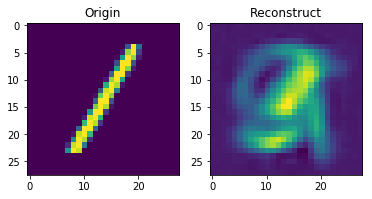

Testing loss = 40.133165(31.999093+8.134073), label=5


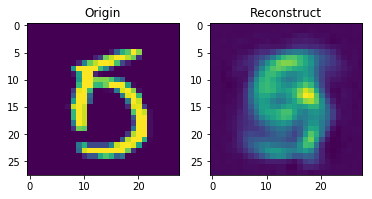

[Epoch 34] 16:02:35
[iteration 100]loss=43.473694(34.495468+8.978226)
[iteration 200]loss=41.723648(34.213840+7.509809)
[iteration 300]loss=38.022911(29.326624+8.696289)
[iteration 400]loss=41.525478(33.483402+8.042075)
[iteration 500]loss=39.980862(32.163403+7.817459)
[iteration 600]loss=41.843132(33.455986+8.387148)
[iteration 700]loss=40.204700(32.372406+7.832294)
[iteration 800]loss=41.025314(32.071663+8.953651)
Training loss = 39.925256(31.690949+8.234308), label=6


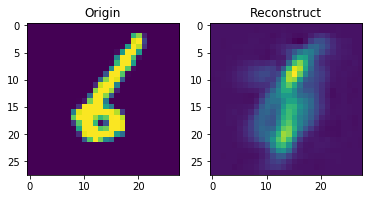

Validation loss = 39.665537(31.334732+8.330804), label=9


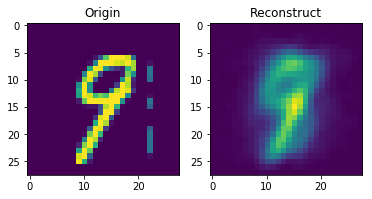

Testing loss = 39.868769(31.550917+8.317853), label=0


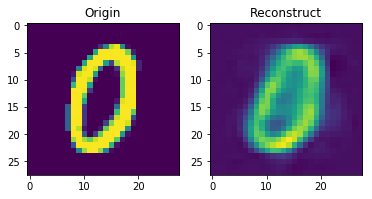

[Epoch 35] 16:02:40
[iteration 100]loss=41.756145(33.182362+8.573784)
[iteration 200]loss=39.262253(31.528183+7.734070)
[iteration 300]loss=39.249756(31.018917+8.230840)
[iteration 400]loss=42.557098(34.005280+8.551817)
[iteration 500]loss=42.218861(32.250210+9.968650)
[iteration 600]loss=41.482498(33.809937+7.672560)
[iteration 700]loss=42.582672(34.137093+8.445580)
[iteration 800]loss=40.132065(31.818092+8.313972)
Training loss = 39.985487(32.063940+7.921547), label=5


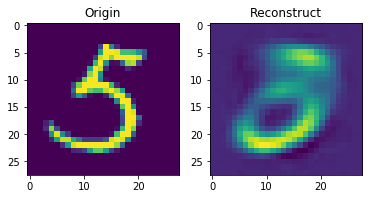

Validation loss = 39.846079(31.817038+8.029041), label=8


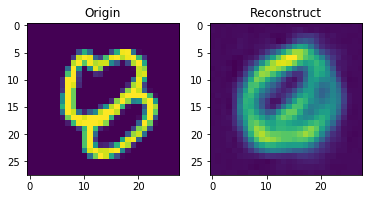

Testing loss = 39.927898(31.941044+7.986854), label=2


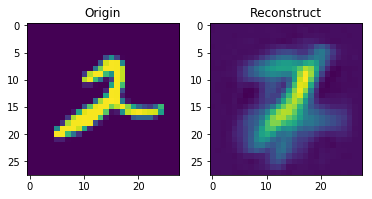

[Epoch 36] 16:02:45
[iteration 100]loss=39.713211(31.220169+8.493040)
[iteration 200]loss=41.012352(32.628471+8.383882)
[iteration 300]loss=41.639263(32.830925+8.808338)
[iteration 400]loss=42.752262(34.146069+8.606194)
[iteration 500]loss=38.592266(30.792557+7.799708)
[iteration 600]loss=39.767937(31.827574+7.940361)
[iteration 700]loss=42.260162(33.331886+8.928274)
[iteration 800]loss=40.597309(31.518879+9.078430)
Training loss = 39.805471(31.566238+8.239233), label=2


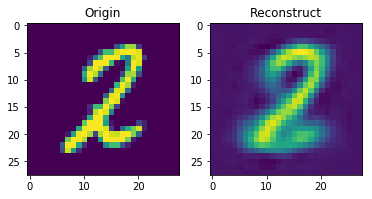

Validation loss = 39.611380(31.297155+8.314225), label=6


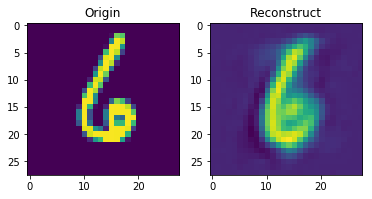

Testing loss = 39.625357(31.307597+8.317759), label=4


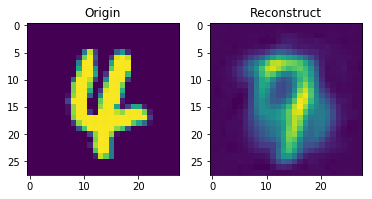

[Epoch 37] 16:02:50
[iteration 100]loss=42.772644(33.539814+9.232830)
[iteration 200]loss=41.471245(32.653217+8.818027)
[iteration 300]loss=42.273140(33.237152+9.035990)
[iteration 400]loss=44.001549(34.931854+9.069695)
[iteration 500]loss=42.591583(34.784035+7.807547)
[iteration 600]loss=41.350700(32.420811+8.929892)
[iteration 700]loss=44.490089(35.131931+9.358158)
[iteration 800]loss=43.172943(34.244537+8.928408)
Training loss = 39.706548(31.403618+8.302930), label=7


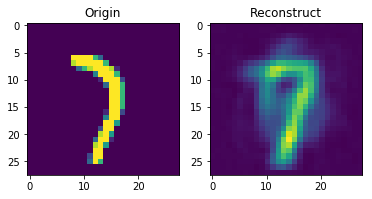

Validation loss = 39.568019(31.166776+8.401244), label=4


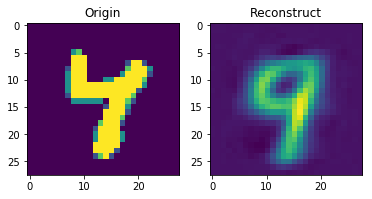

Testing loss = 39.545023(31.134061+8.410962), label=3


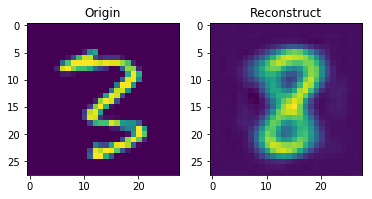

[Epoch 38] 16:02:54
[iteration 100]loss=40.641312(31.606354+9.034957)
[iteration 200]loss=40.913139(33.227634+7.685503)
[iteration 300]loss=41.243305(32.331478+8.911828)
[iteration 400]loss=42.288166(33.245499+9.042668)
[iteration 500]loss=42.001701(33.622597+8.379103)
[iteration 600]loss=39.187576(30.786211+8.401363)
[iteration 700]loss=40.631527(32.440186+8.191341)
[iteration 800]loss=39.682171(31.230019+8.452152)
Training loss = 39.560632(31.364975+8.195656), label=6


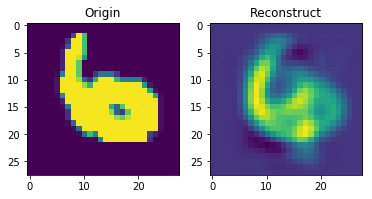

Validation loss = 39.338714(31.069686+8.269028), label=8


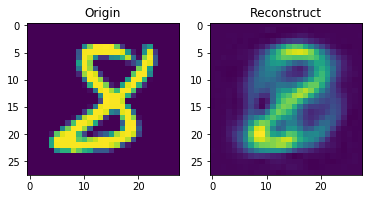

Testing loss = 39.566043(31.271125+8.294918), label=2


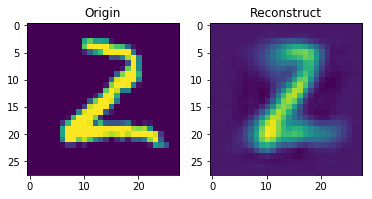

[Epoch 39] 16:02:59
[iteration 100]loss=38.617523(30.377628+8.239893)
[iteration 200]loss=41.366531(33.127762+8.238771)
[iteration 300]loss=39.323620(31.045906+8.277713)
[iteration 400]loss=40.890091(32.242344+8.647747)
[iteration 500]loss=41.392178(33.261036+8.131143)
[iteration 600]loss=41.176300(32.637482+8.538818)
[iteration 700]loss=41.166824(32.453297+8.713528)
[iteration 800]loss=40.226257(31.591583+8.634676)
Training loss = 39.545038(31.239187+8.305851), label=0


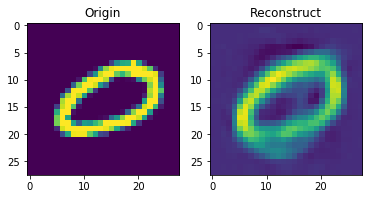

Validation loss = 39.233473(30.819619+8.413854), label=4


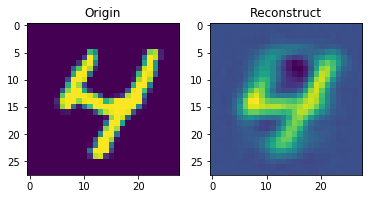

Testing loss = 39.338852(30.975945+8.362907), label=4


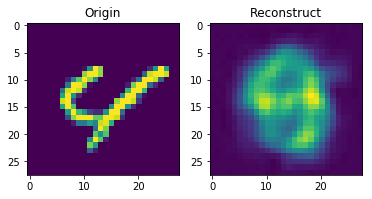

[Epoch 40] 16:03:04
[iteration 100]loss=41.888870(32.881104+9.007765)
[iteration 200]loss=41.393059(33.018810+8.374249)
[iteration 300]loss=42.126694(33.539398+8.587296)
[iteration 400]loss=41.716274(33.422951+8.293324)
[iteration 500]loss=41.996990(32.989815+9.007176)
[iteration 600]loss=40.114906(31.321583+8.793323)
[iteration 700]loss=40.495850(32.712578+7.783272)
[iteration 800]loss=41.426281(32.665955+8.760326)
Training loss = 39.374932(31.242473+8.132459), label=8


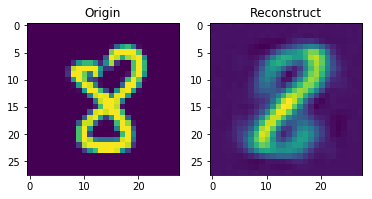

Validation loss = 39.131500(30.930910+8.200590), label=6


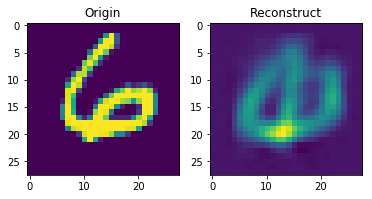

Testing loss = 39.277947(31.072280+8.205667), label=6


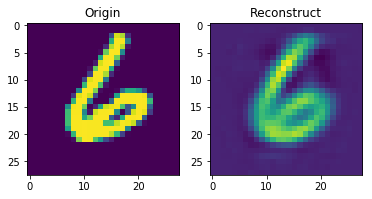

[Epoch 41] 16:03:10
[iteration 100]loss=38.374001(29.834507+8.539492)
[iteration 200]loss=43.947868(34.859531+9.088335)
[iteration 300]loss=42.802757(34.079529+8.723230)
[iteration 400]loss=41.681854(34.156132+7.525722)
[iteration 500]loss=42.193947(34.248276+7.945669)
[iteration 600]loss=42.453110(33.461754+8.991356)
[iteration 700]loss=38.620274(30.245895+8.374377)
[iteration 800]loss=42.452477(33.467014+8.985460)
Training loss = 39.274863(31.043427+8.231435), label=9


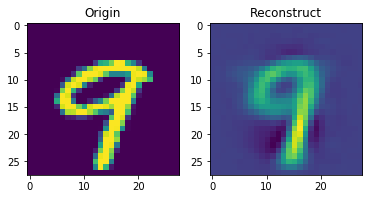

Validation loss = 39.028334(30.636233+8.392101), label=5


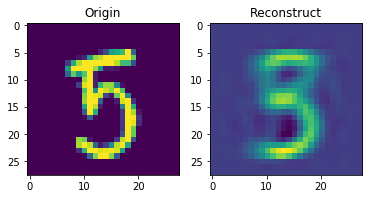

Testing loss = 39.310094(30.983516+8.326578), label=0


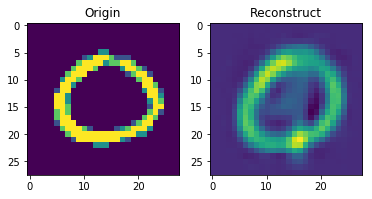

[Epoch 42] 16:03:15
[iteration 100]loss=40.540489(31.859423+8.681066)
[iteration 200]loss=39.586124(30.382069+9.204056)
[iteration 300]loss=38.668861(29.923542+8.745317)
[iteration 400]loss=38.891129(30.423796+8.467335)
[iteration 500]loss=39.258106(30.630135+8.627972)
[iteration 600]loss=40.799423(32.601833+8.197592)
[iteration 700]loss=43.120628(34.434494+8.686132)
[iteration 800]loss=41.718628(32.815636+8.902994)
Training loss = 39.164908(30.930414+8.234494), label=6


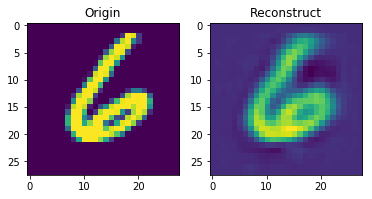

Validation loss = 38.971504(30.649074+8.322431), label=4


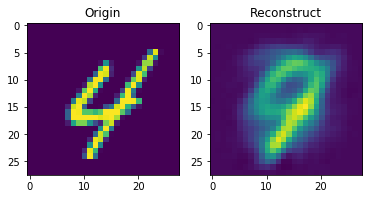

Testing loss = 39.159284(30.833836+8.325447), label=9


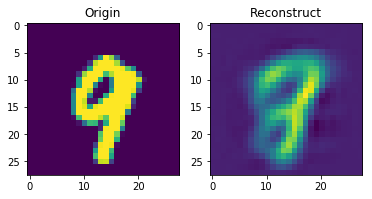

[Epoch 43] 16:03:19
[iteration 100]loss=42.602829(33.580658+9.022169)
[iteration 200]loss=42.719299(34.132935+8.586366)
[iteration 300]loss=38.648758(30.017452+8.631306)
[iteration 400]loss=41.416649(32.273453+9.143196)
[iteration 500]loss=40.055851(31.657978+8.397874)
[iteration 600]loss=43.056019(33.926292+9.129726)
[iteration 700]loss=43.370316(34.194611+9.175703)
[iteration 800]loss=40.466759(31.944931+8.521830)
Training loss = 39.055470(30.663447+8.392023), label=2


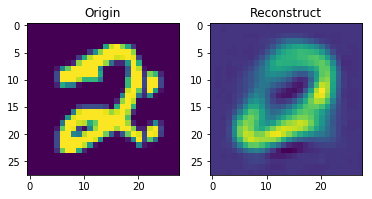

Validation loss = 38.705180(30.265582+8.439598), label=5


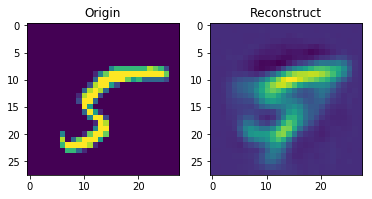

Testing loss = 38.893975(30.444441+8.449534), label=4


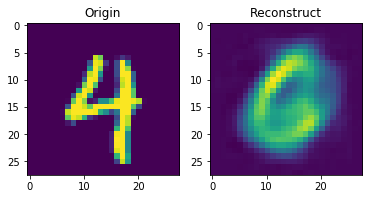

[Epoch 44] 16:03:24
[iteration 100]loss=39.573109(31.164761+8.408349)
[iteration 200]loss=38.765984(30.346119+8.419865)
[iteration 300]loss=37.495358(29.055733+8.439625)
[iteration 400]loss=40.991505(32.700962+8.290544)
[iteration 500]loss=39.777245(31.973454+7.803790)
[iteration 600]loss=42.160057(33.354023+8.806034)
[iteration 700]loss=39.070774(30.956337+8.114437)
[iteration 800]loss=40.178986(31.638309+8.540675)
Training loss = 38.990612(30.774195+8.216417), label=0


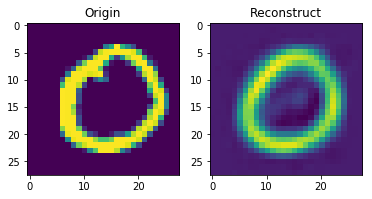

Validation loss = 38.759305(30.509606+8.249700), label=1


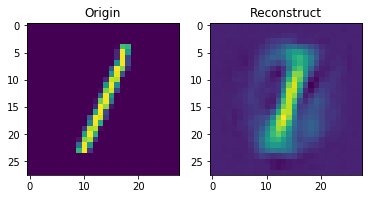

Testing loss = 38.882325(30.582147+8.300178), label=5


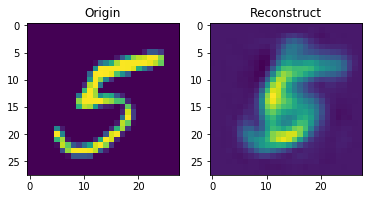

[Epoch 45] 16:03:29
[iteration 100]loss=38.361130(29.292522+9.068607)
[iteration 200]loss=40.171909(31.688236+8.483672)
[iteration 300]loss=39.429379(31.616318+7.813059)
[iteration 400]loss=38.762215(30.432991+8.329225)
[iteration 500]loss=39.798286(30.773350+9.024937)
[iteration 600]loss=43.171017(34.973564+8.197453)
[iteration 700]loss=39.282185(31.184769+8.097416)
[iteration 800]loss=40.557461(31.601673+8.955789)
Training loss = 38.867730(30.556210+8.311520), label=8


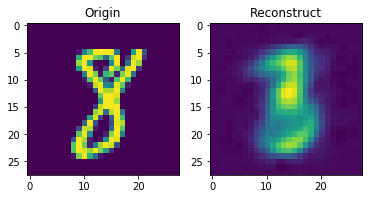

Validation loss = 38.603086(30.217567+8.385518), label=1


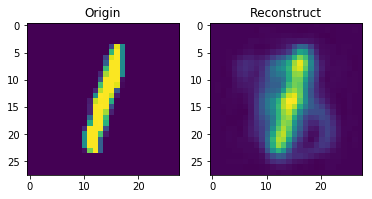

Testing loss = 38.790715(30.431385+8.359330), label=1


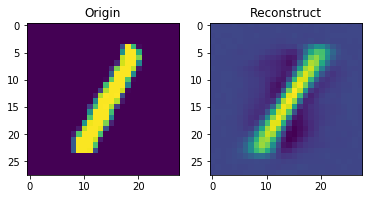

[Epoch 46] 16:03:33
[iteration 100]loss=38.459373(30.343878+8.115495)
[iteration 200]loss=40.296871(31.531872+8.765000)
[iteration 300]loss=40.242512(31.802635+8.439876)
[iteration 400]loss=35.680092(27.606544+8.073549)
[iteration 500]loss=39.846870(31.407337+8.439531)
[iteration 600]loss=41.038185(32.421581+8.616602)
[iteration 700]loss=39.283867(31.024426+8.259441)
[iteration 800]loss=41.777645(33.265472+8.512173)
Training loss = 38.696862(30.367497+8.329365), label=9


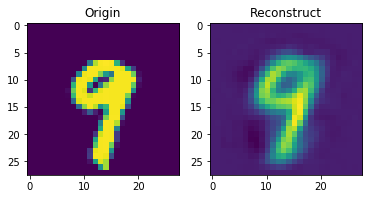

Validation loss = 38.355326(29.978040+8.377286), label=7


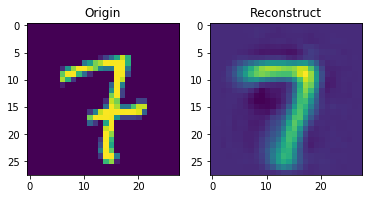

Testing loss = 38.668120(30.258363+8.409757), label=4


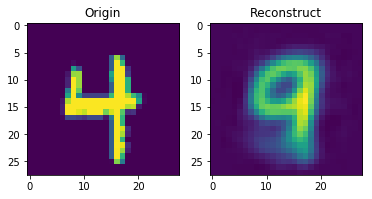

[Epoch 47] 16:03:38
[iteration 100]loss=38.410248(30.102497+8.307752)
[iteration 200]loss=39.864727(31.687397+8.177331)
[iteration 300]loss=41.580399(32.515362+9.065035)
[iteration 400]loss=38.657104(29.787968+8.869135)
[iteration 500]loss=38.007065(30.055050+7.952015)
[iteration 600]loss=36.772942(28.450445+8.322495)
[iteration 700]loss=40.977654(31.846945+9.130708)
[iteration 800]loss=38.994389(30.172224+8.822164)
Training loss = 38.699127(30.565704+8.133423), label=0


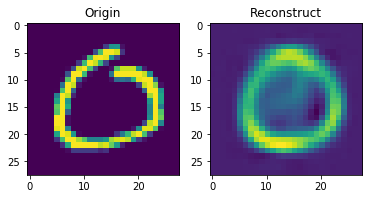

Validation loss = 38.403834(30.212894+8.190940), label=3


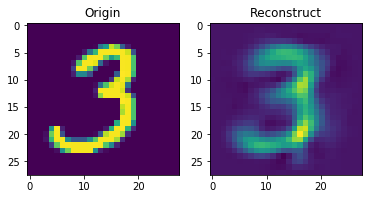

Testing loss = 38.519673(30.336775+8.182898), label=2


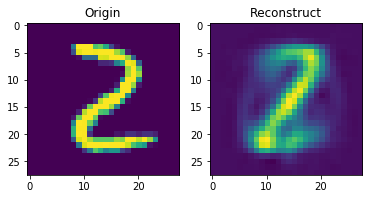

[Epoch 48] 16:03:42
[iteration 100]loss=39.105488(31.065281+8.040207)
[iteration 200]loss=41.213100(32.697174+8.515927)
[iteration 300]loss=41.939659(32.978676+8.960983)
[iteration 400]loss=37.277351(29.413502+7.863851)
[iteration 500]loss=41.941486(33.572456+8.369030)
[iteration 600]loss=39.681629(30.560125+9.121505)
[iteration 700]loss=40.893814(32.427132+8.466684)
[iteration 800]loss=37.283218(29.099619+8.183600)
Training loss = 38.527492(30.413890+8.113603), label=2


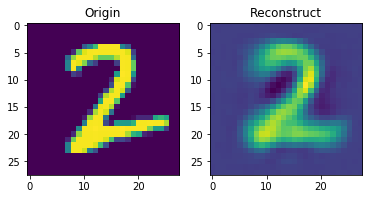

Validation loss = 38.158376(29.984515+8.173861), label=3


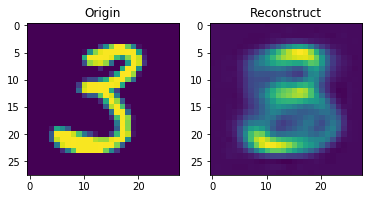

Testing loss = 38.367682(30.177097+8.190585), label=3


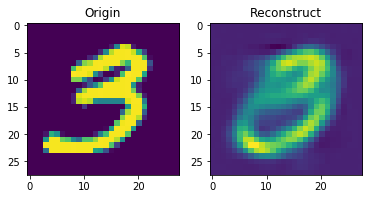

[Epoch 49] 16:03:47
[iteration 100]loss=39.237022(30.991833+8.245189)
[iteration 200]loss=40.473969(32.437168+8.036799)
[iteration 300]loss=42.020729(32.977875+9.042856)
[iteration 400]loss=40.538437(32.368538+8.169899)
[iteration 500]loss=40.337624(32.536308+7.801315)
[iteration 600]loss=40.931690(31.700974+9.230716)
[iteration 700]loss=38.690628(30.344570+8.346058)
[iteration 800]loss=40.899643(31.560703+9.338942)
Training loss = 38.418808(30.289532+8.129276), label=7


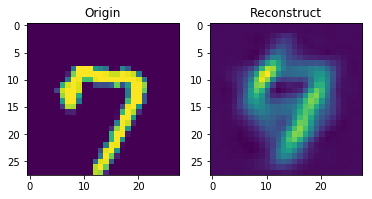

Validation loss = 37.972400(29.787636+8.184764), label=0


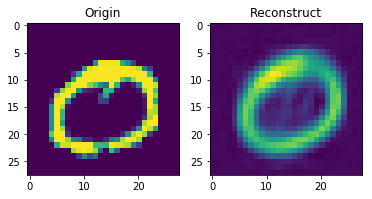

Testing loss = 38.214456(30.037591+8.176865), label=2


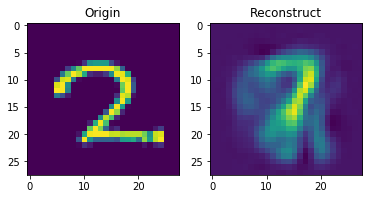

[Epoch 50] 16:03:51
[iteration 100]loss=40.562492(31.822350+8.740143)
[iteration 200]loss=40.063850(31.527515+8.536337)
[iteration 300]loss=38.245926(29.671535+8.574390)
[iteration 400]loss=38.200653(30.068794+8.131861)
[iteration 500]loss=40.193047(31.197762+8.995285)
[iteration 600]loss=36.985020(29.019024+7.965994)
[iteration 700]loss=42.589386(33.425320+9.164065)
[iteration 800]loss=41.311905(32.354141+8.957765)
Training loss = 38.237545(30.072019+8.165526), label=4


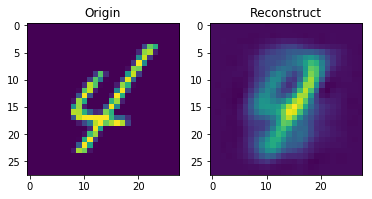

Validation loss = 38.040919(29.820171+8.220747), label=1


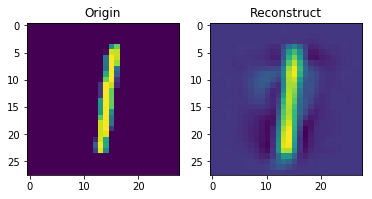

Testing loss = 38.017079(29.763494+8.253585), label=5


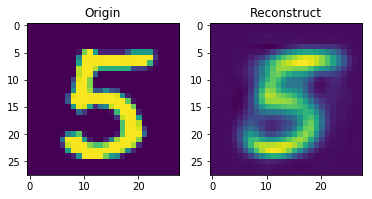

[Epoch 51] 16:03:56
[iteration 100]loss=38.311729(29.911337+8.400392)
[iteration 200]loss=37.776070(29.785799+7.990269)
[iteration 300]loss=38.600903(30.268623+8.332279)
[iteration 400]loss=37.630512(29.147346+8.483165)
[iteration 500]loss=40.623718(32.330219+8.293499)
[iteration 600]loss=40.989624(32.567596+8.422029)
[iteration 700]loss=37.617779(29.303333+8.314445)
[iteration 800]loss=38.038040(29.451002+8.587039)
Training loss = 38.065924(29.769100+8.296824), label=1


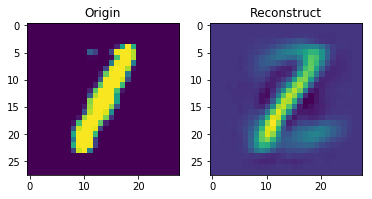

Validation loss = 37.603965(29.277694+8.326271), label=8


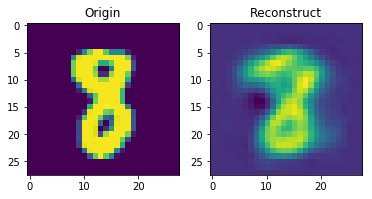

Testing loss = 38.012140(29.626805+8.385335), label=5


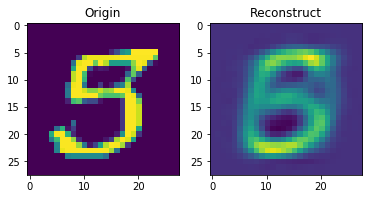

[Epoch 52] 16:04:01
[iteration 100]loss=38.731323(30.597689+8.133633)
[iteration 200]loss=40.018387(31.618155+8.400230)
[iteration 300]loss=37.879314(29.511301+8.368013)
[iteration 400]loss=38.903080(30.425858+8.477223)
[iteration 500]loss=40.147827(31.753448+8.394377)
[iteration 600]loss=40.129734(31.447563+8.682171)
[iteration 700]loss=40.764038(32.427734+8.336306)
[iteration 800]loss=39.434883(30.307602+9.127283)
Training loss = 37.985484(29.769743+8.215741), label=1


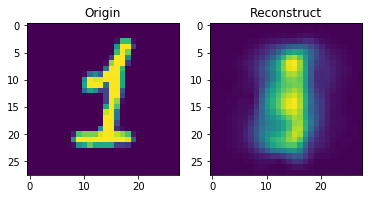

Validation loss = 37.759987(29.477060+8.282927), label=7


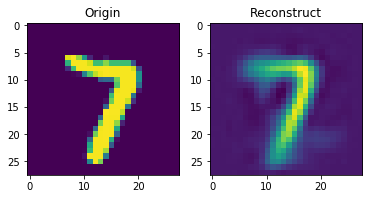

Testing loss = 37.690816(29.437482+8.253334), label=0


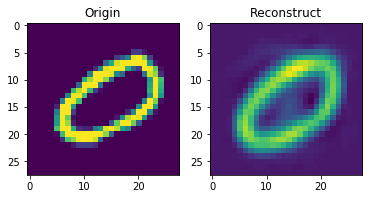

[Epoch 53] 16:04:05
[iteration 100]loss=39.110386(31.022911+8.087476)
[iteration 200]loss=38.315605(30.023289+8.292318)
[iteration 300]loss=37.231567(28.766815+8.464752)
[iteration 400]loss=41.045906(31.970718+9.075190)
[iteration 500]loss=40.789139(31.983364+8.805776)
[iteration 600]loss=38.483315(30.059296+8.424019)
[iteration 700]loss=37.726242(29.238544+8.487700)
[iteration 800]loss=36.978363(28.800694+8.177671)
Training loss = 37.777172(29.382099+8.395073), label=3


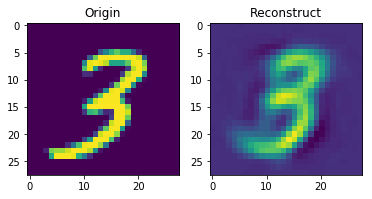

Validation loss = 37.484154(29.033388+8.450766), label=4


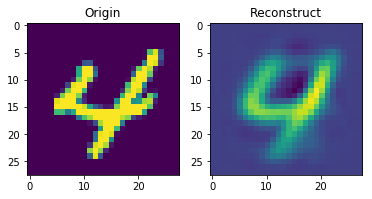

Testing loss = 37.738824(29.243944+8.494880), label=1


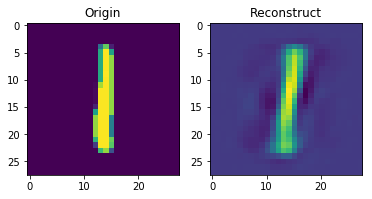

[Epoch 54] 16:04:10
[iteration 100]loss=37.665745(29.291979+8.373766)
[iteration 200]loss=40.209827(32.108261+8.101567)
[iteration 300]loss=37.783134(29.829330+7.953804)
[iteration 400]loss=39.950325(31.151546+8.798779)
[iteration 500]loss=38.436638(29.722702+8.713935)
[iteration 600]loss=39.075237(29.978899+9.096337)
[iteration 700]loss=39.373596(30.952412+8.421183)
[iteration 800]loss=41.318333(32.803421+8.514912)
Training loss = 37.669290(29.408315+8.260975), label=2


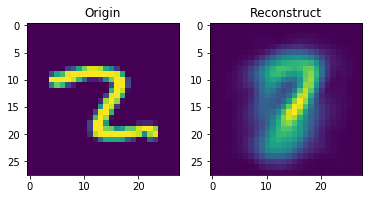

Validation loss = 37.540414(29.218559+8.321855), label=9


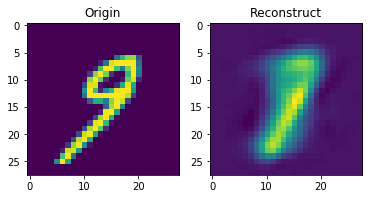

Testing loss = 37.461856(29.128484+8.333372), label=3


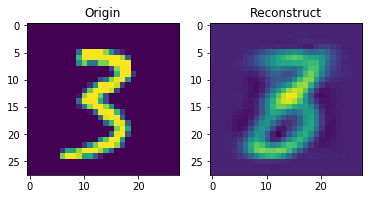

[Epoch 55] 16:04:14
[iteration 100]loss=40.611282(31.657188+8.954096)
[iteration 200]loss=41.247597(32.307583+8.940016)
[iteration 300]loss=41.163712(31.708570+9.455139)
[iteration 400]loss=40.306911(31.933151+8.373760)
[iteration 500]loss=39.288727(30.448538+8.840191)
[iteration 600]loss=36.929367(28.717968+8.211397)
[iteration 700]loss=40.184956(31.949665+8.235291)
[iteration 800]loss=39.245735(30.108849+9.136889)
Training loss = 37.556959(29.205486+8.351473), label=5


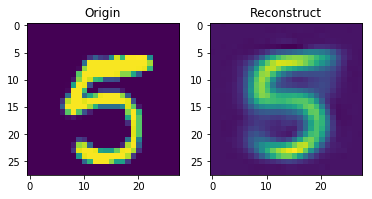

Validation loss = 37.269945(28.863112+8.406833), label=0


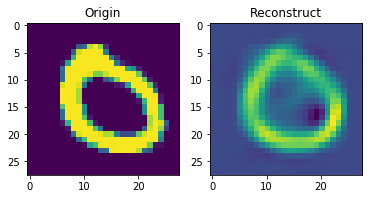

Testing loss = 37.374051(28.948179+8.425872), label=7


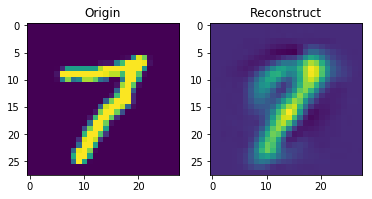

[Epoch 56] 16:04:19
[iteration 100]loss=38.872578(30.022009+8.850568)
[iteration 200]loss=39.381908(30.092346+9.289562)
[iteration 300]loss=39.882832(31.016644+8.866188)
[iteration 400]loss=39.018379(30.463539+8.554841)
[iteration 500]loss=38.897236(30.493624+8.403613)
[iteration 600]loss=39.746403(31.044052+8.702350)
[iteration 700]loss=38.192596(29.983877+8.208720)
[iteration 800]loss=40.847198(32.117439+8.729759)
Training loss = 37.459088(29.208529+8.250559), label=0


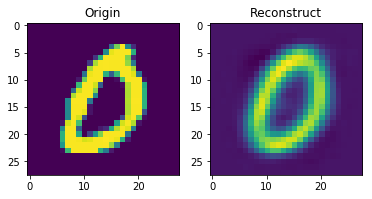

Validation loss = 37.059283(28.704515+8.354768), label=7


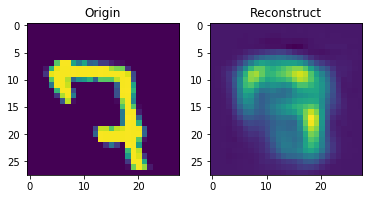

Testing loss = 37.347476(29.032170+8.315306), label=0


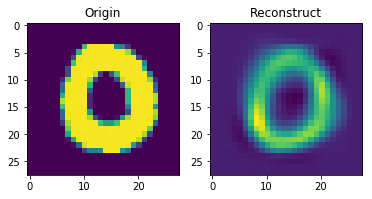

[Epoch 57] 16:04:23
[iteration 100]loss=39.145157(30.835960+8.309196)
[iteration 200]loss=36.077023(27.883888+8.193134)
[iteration 300]loss=36.792850(28.921627+7.871224)
[iteration 400]loss=41.103050(33.196869+7.906182)
[iteration 500]loss=39.014771(30.137629+8.877143)
[iteration 600]loss=43.742153(34.430836+9.311317)
[iteration 700]loss=38.432575(29.557543+8.875032)
[iteration 800]loss=38.672062(30.712656+7.959407)
Training loss = 37.338896(29.144417+8.194480), label=1


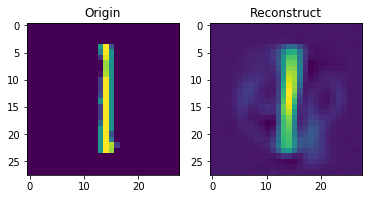

Validation loss = 37.088255(28.821635+8.266620), label=3


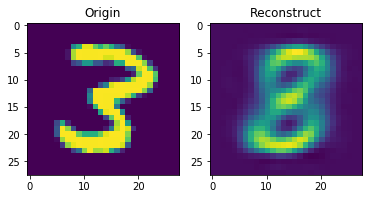

Testing loss = 37.230623(28.961450+8.269173), label=0


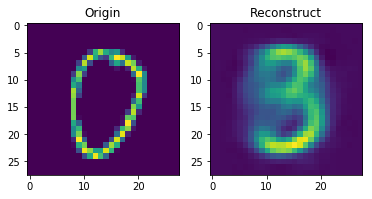

[Epoch 58] 16:04:28
[iteration 100]loss=38.599510(29.630390+8.969121)
[iteration 200]loss=38.704544(30.078133+8.626413)
[iteration 300]loss=37.016922(29.254139+7.762781)
[iteration 400]loss=39.264477(31.190678+8.073800)
[iteration 500]loss=38.393784(29.807100+8.586681)
[iteration 600]loss=40.155159(31.682175+8.472984)
[iteration 700]loss=41.700684(32.810314+8.890368)
[iteration 800]loss=38.865479(30.729219+8.136257)
Training loss = 37.172524(28.942944+8.229580), label=4


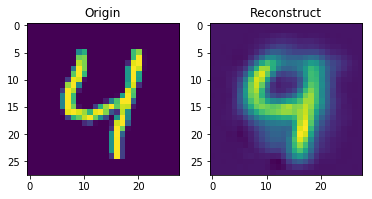

Validation loss = 36.945112(28.678508+8.266605), label=2


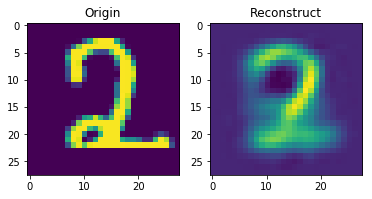

Testing loss = 37.136160(28.857405+8.278755), label=2


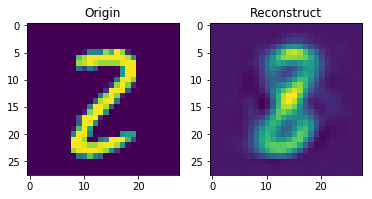

[Epoch 59] 16:04:32
[iteration 100]loss=39.092850(30.252802+8.840050)
[iteration 200]loss=38.540604(29.981594+8.559011)
[iteration 300]loss=41.466248(33.087006+8.379240)
[iteration 400]loss=39.993187(31.429619+8.563567)
[iteration 500]loss=39.331844(30.820877+8.510966)
[iteration 600]loss=40.912571(32.320045+8.592525)
[iteration 700]loss=37.447899(29.006756+8.441144)
[iteration 800]loss=39.396927(30.786266+8.610661)
Training loss = 37.137265(28.965862+8.171403), label=4


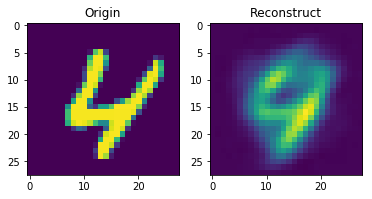

Validation loss = 36.998173(28.762018+8.236156), label=7


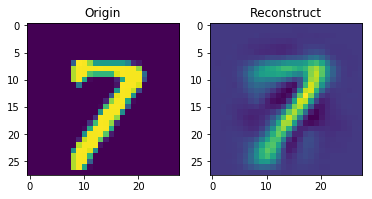

Testing loss = 37.036219(28.797435+8.238784), label=8


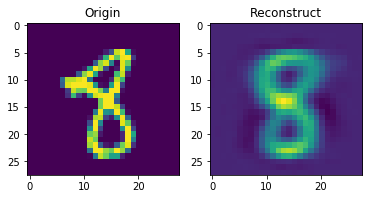

[Epoch 60] 16:04:37
[iteration 100]loss=39.247559(30.506748+8.740808)
[iteration 200]loss=40.983337(32.552505+8.430831)
[iteration 300]loss=37.319260(29.011715+8.307543)
[iteration 400]loss=40.608910(32.398129+8.210781)
[iteration 500]loss=40.024345(31.388350+8.635996)
[iteration 600]loss=40.452038(32.507721+7.944318)
[iteration 700]loss=38.065170(30.190727+7.874442)
[iteration 800]loss=37.042545(28.867435+8.175110)
Training loss = 37.082524(28.805301+8.277223), label=8


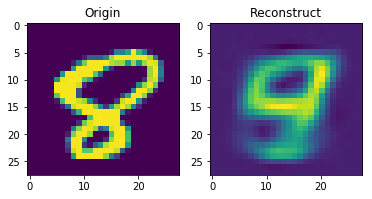

Validation loss = 36.869009(28.522220+8.346789), label=2


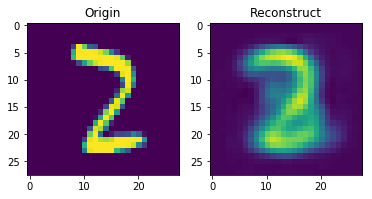

Testing loss = 36.901794(28.566944+8.334851), label=4


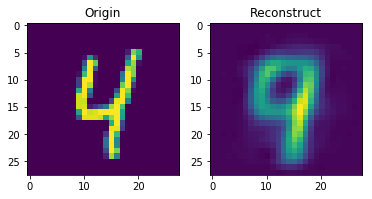

[Epoch 61] 16:04:42
[iteration 100]loss=38.979767(30.352242+8.627523)
[iteration 200]loss=37.120953(28.488804+8.632149)
[iteration 300]loss=37.072796(28.775230+8.297565)
[iteration 400]loss=38.484768(29.999630+8.485137)
[iteration 500]loss=38.945824(30.562649+8.383174)
[iteration 600]loss=38.913750(30.699953+8.213796)
[iteration 700]loss=35.823578(27.586802+8.236774)
[iteration 800]loss=38.807281(30.793680+8.013599)
Training loss = 36.974406(28.798808+8.175598), label=8


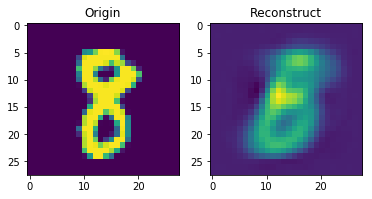

Validation loss = 36.831558(28.628109+8.203449), label=4


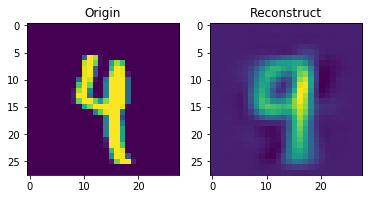

Testing loss = 36.927091(28.701737+8.225354), label=9


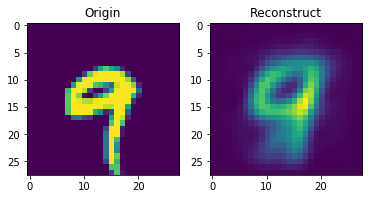

[Epoch 62] 16:04:46
[iteration 100]loss=36.035290(27.378551+8.656739)
[iteration 200]loss=39.034271(30.458162+8.576111)
[iteration 300]loss=35.330322(27.169395+8.160929)
[iteration 400]loss=40.780716(32.367470+8.413244)
[iteration 500]loss=38.702797(29.804176+8.898622)
[iteration 600]loss=39.164505(31.268080+7.896427)
[iteration 700]loss=36.545639(28.155964+8.389673)
[iteration 800]loss=37.893738(30.106361+7.787374)
Training loss = 36.919819(28.643693+8.276125), label=9


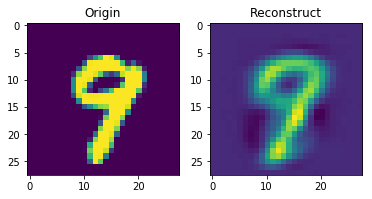

Validation loss = 36.558400(28.214982+8.343418), label=5


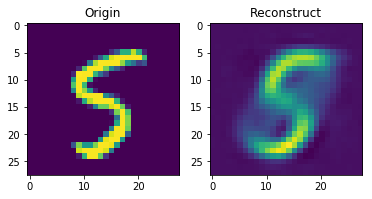

Testing loss = 36.857125(28.527586+8.329539), label=4


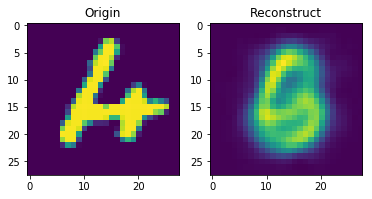

[Epoch 63] 16:04:51
[iteration 100]loss=38.476425(30.133034+8.343390)
[iteration 200]loss=37.562141(29.225933+8.336210)
[iteration 300]loss=37.359055(29.103107+8.255945)
[iteration 400]loss=41.466358(33.306557+8.159801)
[iteration 500]loss=38.530128(30.561337+7.968793)
[iteration 600]loss=38.669327(30.282722+8.386602)
[iteration 700]loss=37.917145(29.405613+8.511534)
[iteration 800]loss=38.925373(30.017456+8.907918)
Training loss = 36.935050(28.739374+8.195676), label=4


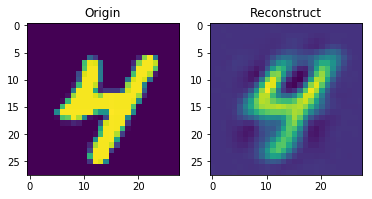

Validation loss = 36.603687(28.372281+8.231405), label=0


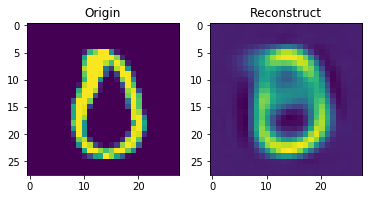

Testing loss = 36.777673(28.521162+8.256511), label=7


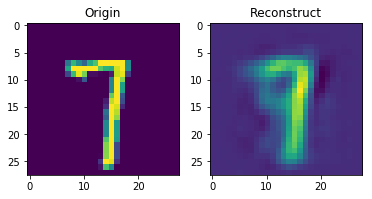

[Epoch 64] 16:04:55
[iteration 100]loss=40.352936(31.581013+8.771921)
[iteration 200]loss=37.400414(28.723440+8.676971)
[iteration 300]loss=41.280319(32.793098+8.487222)
[iteration 400]loss=36.148830(28.429886+7.718944)
[iteration 500]loss=40.448414(31.891338+8.557075)
[iteration 600]loss=40.033340(31.758011+8.275330)
[iteration 700]loss=37.211975(29.021645+8.190332)
[iteration 800]loss=38.261372(29.491638+8.769734)
Training loss = 36.812798(28.594918+8.217881), label=6


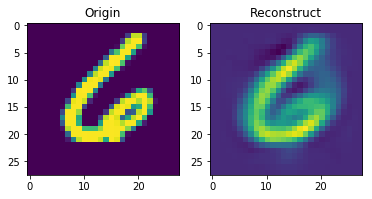

Validation loss = 36.587745(28.281076+8.306669), label=7


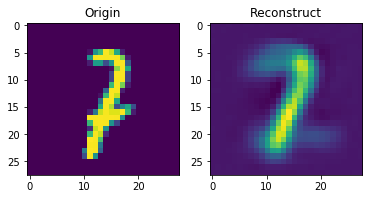

Testing loss = 36.624020(28.339218+8.284802), label=8


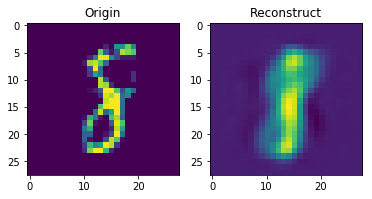

[Epoch 65] 16:05:00
[iteration 100]loss=38.775375(29.829975+8.945402)
[iteration 200]loss=36.411575(28.109827+8.301749)
[iteration 300]loss=39.957031(31.104528+8.852505)
[iteration 400]loss=36.755981(28.352995+8.402987)
[iteration 500]loss=38.499672(30.074455+8.425217)
[iteration 600]loss=39.615280(30.989374+8.625904)
[iteration 700]loss=35.223652(26.488380+8.735271)
[iteration 800]loss=38.632568(30.554726+8.077844)
Training loss = 36.831110(28.618209+8.212901), label=1


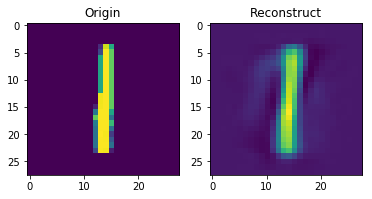

Validation loss = 36.391649(28.180079+8.211570), label=4


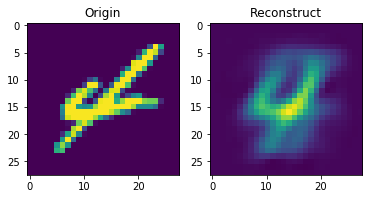

Testing loss = 36.736870(28.444480+8.292390), label=7


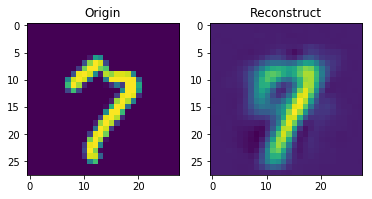

[Epoch 66] 16:05:04
[iteration 100]loss=38.319469(29.923967+8.395503)
[iteration 200]loss=36.885330(28.620792+8.264540)
[iteration 300]loss=36.418407(27.831095+8.587313)
[iteration 400]loss=38.860687(30.564947+8.295738)
[iteration 500]loss=38.381470(29.976604+8.404867)
[iteration 600]loss=37.709717(29.383862+8.325853)
[iteration 700]loss=39.878197(31.245333+8.632862)
[iteration 800]loss=37.655289(29.092230+8.563059)
Training loss = 36.709372(28.569590+8.139782), label=7


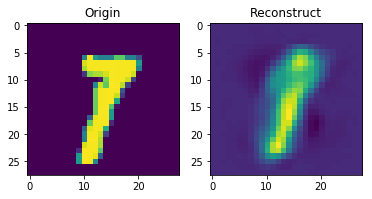

Validation loss = 36.582497(28.375251+8.207246), label=4


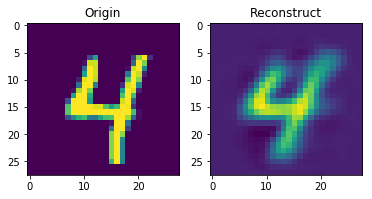

Testing loss = 36.568816(28.377875+8.190941), label=8


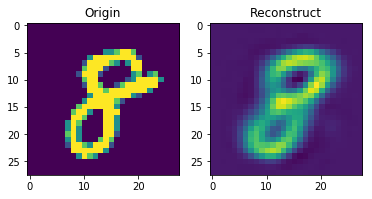

[Epoch 67] 16:05:09
[iteration 100]loss=37.989578(29.594210+8.395368)
[iteration 200]loss=36.978397(28.192268+8.786129)
[iteration 300]loss=38.986839(30.258657+8.728180)
[iteration 400]loss=37.679310(29.405151+8.274158)
[iteration 500]loss=38.123966(29.716866+8.407101)
[iteration 600]loss=36.792568(27.898527+8.894042)
[iteration 700]loss=41.791634(32.463081+9.328554)
[iteration 800]loss=38.887787(29.728813+9.158972)
Training loss = 36.760505(28.635267+8.125238), label=4


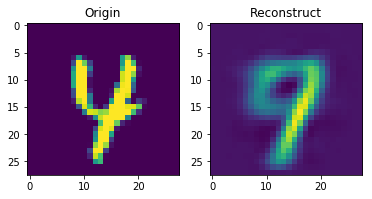

Validation loss = 36.559526(28.363149+8.196377), label=1


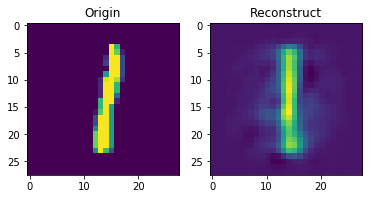

Testing loss = 36.587158(28.378791+8.208367), label=6


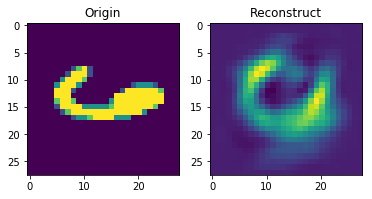

[Epoch 68] 16:05:14
[iteration 100]loss=39.252987(30.944641+8.308346)
[iteration 200]loss=36.444832(28.359867+8.084963)
[iteration 300]loss=36.458302(27.945904+8.512398)
[iteration 400]loss=36.905121(28.594513+8.310610)
[iteration 500]loss=39.602791(31.571236+8.031557)
[iteration 600]loss=39.218590(30.218779+8.999811)
[iteration 700]loss=37.935043(29.893364+8.041681)
[iteration 800]loss=38.373863(29.227581+9.146284)
Training loss = 36.603772(28.456351+8.147421), label=5


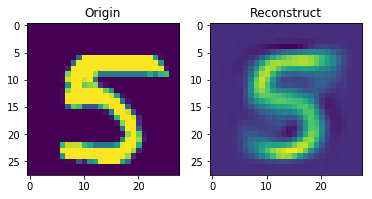

Validation loss = 36.356576(28.162961+8.193615), label=5


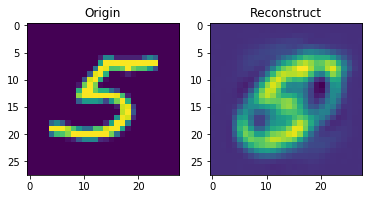

Testing loss = 36.560238(28.355384+8.204854), label=4


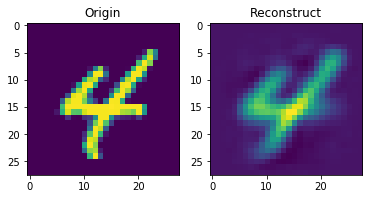

[Epoch 69] 16:05:19
[iteration 100]loss=37.522247(29.881832+7.640416)
[iteration 200]loss=36.009281(28.289463+7.719817)
[iteration 300]loss=37.949654(29.656975+8.292681)
[iteration 400]loss=35.816719(28.050068+7.766649)
[iteration 500]loss=39.743744(31.051899+8.691844)
[iteration 600]loss=38.685997(30.208120+8.477875)
[iteration 700]loss=37.905266(29.553820+8.351447)
[iteration 800]loss=36.475483(28.242340+8.233142)
Training loss = 36.600917(28.391708+8.209210), label=8


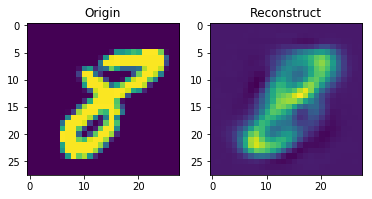

Validation loss = 36.331890(28.074607+8.257284), label=1


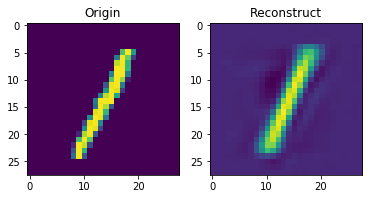

Testing loss = 36.409615(28.140474+8.269141), label=7


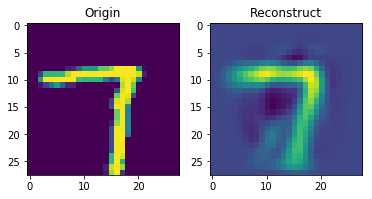

[Epoch 70] 16:05:23
[iteration 100]loss=37.466961(29.153160+8.313801)
[iteration 200]loss=38.790291(30.317207+8.473085)
[iteration 300]loss=39.663857(30.627220+9.036636)
[iteration 400]loss=41.303627(32.608429+8.695198)
[iteration 500]loss=37.055431(29.150829+7.904603)
[iteration 600]loss=34.053009(26.408052+7.644955)
[iteration 700]loss=35.755123(27.054390+8.700732)
[iteration 800]loss=40.656261(31.567522+9.088739)
Training loss = 36.564512(28.412869+8.151643), label=8


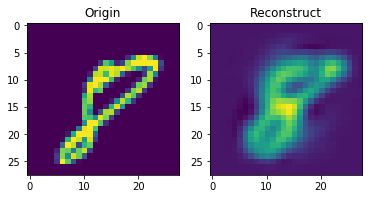

Validation loss = 36.226322(28.044815+8.181506), label=6


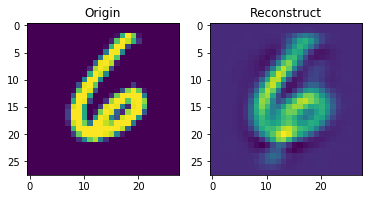

Testing loss = 36.524206(28.313923+8.210283), label=3


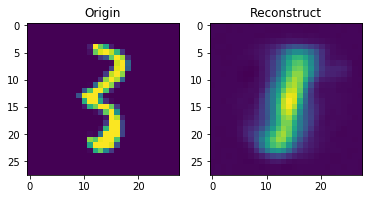

[Epoch 71] 16:05:28
[iteration 100]loss=37.442871(28.724468+8.718402)
[iteration 200]loss=39.024693(29.890472+9.134220)
[iteration 300]loss=38.953026(30.930470+8.022558)
[iteration 400]loss=36.629829(28.162251+8.467580)
[iteration 500]loss=39.294167(30.363396+8.930771)
[iteration 600]loss=34.242371(26.140295+8.102076)
[iteration 700]loss=36.998840(28.761820+8.237022)
[iteration 800]loss=38.049423(29.842384+8.207037)
Training loss = 36.523584(28.277767+8.245817), label=4


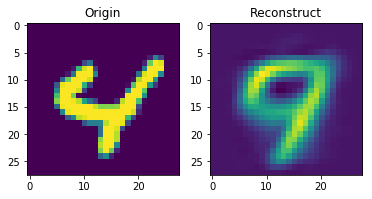

Validation loss = 36.208243(27.914832+8.293411), label=3


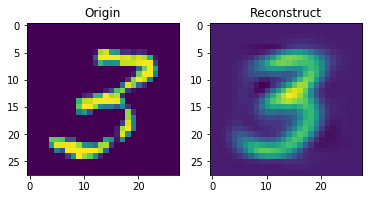

Testing loss = 36.422142(28.113891+8.308251), label=8


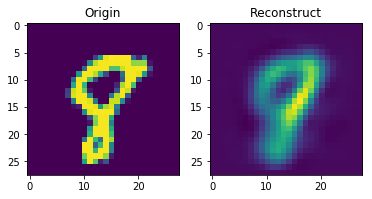

[Epoch 72] 16:05:33
[iteration 100]loss=40.230083(31.889927+8.340157)
[iteration 200]loss=36.293892(28.078053+8.215839)
[iteration 300]loss=36.984226(28.459026+8.525200)
[iteration 400]loss=38.934353(30.808105+8.126247)
[iteration 500]loss=37.230991(29.174593+8.056398)
[iteration 600]loss=39.177338(30.695513+8.481825)
[iteration 700]loss=37.210308(28.822048+8.388261)
[iteration 800]loss=38.045231(29.570936+8.474295)
Training loss = 36.484678(28.337990+8.146687), label=9


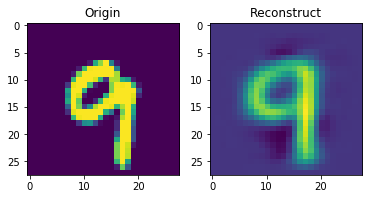

Validation loss = 36.215511(28.038883+8.176628), label=2


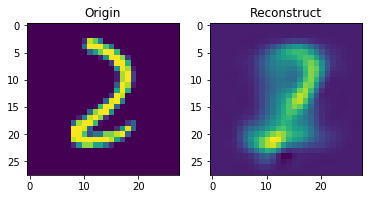

Testing loss = 36.428053(28.249964+8.178089), label=5


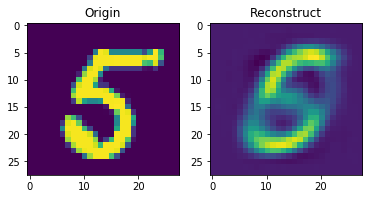

[Epoch 73] 16:05:37
[iteration 100]loss=39.056622(30.374567+8.682055)
[iteration 200]loss=37.066967(28.957607+8.109360)
[iteration 300]loss=38.270432(29.855005+8.415428)
[iteration 400]loss=36.414928(27.974173+8.440756)
[iteration 500]loss=37.657471(29.502289+8.155181)
[iteration 600]loss=40.111851(31.793879+8.317972)
[iteration 700]loss=37.574989(29.035528+8.539459)
[iteration 800]loss=36.885857(28.831196+8.054661)
Training loss = 36.453497(28.256063+8.197434), label=2


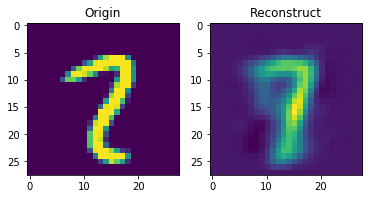

Validation loss = 36.292639(28.034031+8.258608), label=4


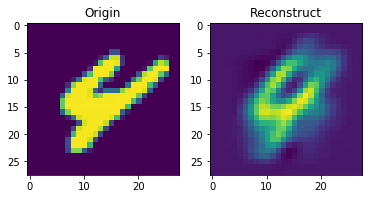

Testing loss = 36.308164(28.057561+8.250602), label=1


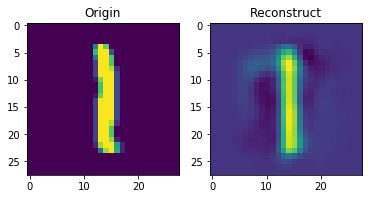

[Epoch 74] 16:05:42
[iteration 100]loss=36.007576(27.911163+8.096411)
[iteration 200]loss=39.324741(30.290266+9.034476)
[iteration 300]loss=39.164391(30.693367+8.471024)
[iteration 400]loss=36.397568(28.301746+8.095821)
[iteration 500]loss=37.650284(28.941040+8.709246)
[iteration 600]loss=40.155403(31.535641+8.619764)
[iteration 700]loss=39.488335(30.599510+8.888824)
[iteration 800]loss=39.705734(31.334751+8.370981)
Training loss = 36.446167(28.233579+8.212588), label=6


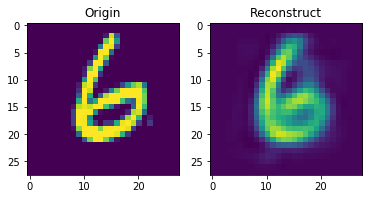

Validation loss = 36.080815(27.803757+8.277057), label=4


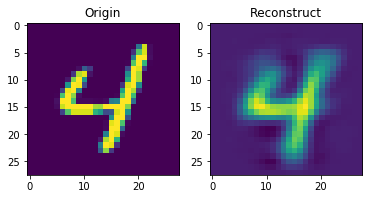

Testing loss = 36.468567(28.179506+8.289062), label=9


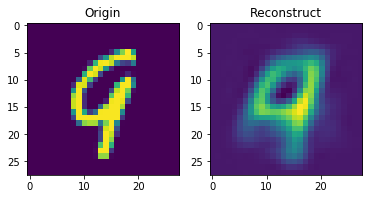

[Epoch 75] 16:05:46
[iteration 100]loss=38.683167(30.080803+8.602364)
[iteration 200]loss=37.392265(28.605774+8.786489)
[iteration 300]loss=36.677437(28.609747+8.067692)
[iteration 400]loss=39.745777(31.280365+8.465411)
[iteration 500]loss=38.127285(29.294485+8.832800)
[iteration 600]loss=36.610596(28.507751+8.102842)
[iteration 700]loss=37.955906(29.514992+8.440913)
[iteration 800]loss=37.574532(28.691639+8.882893)
Training loss = 36.441519(28.269391+8.172128), label=2


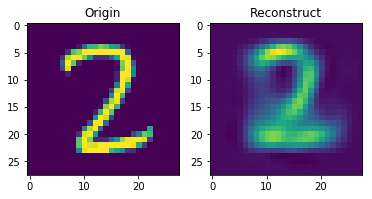

Validation loss = 36.239494(28.036510+8.202984), label=7


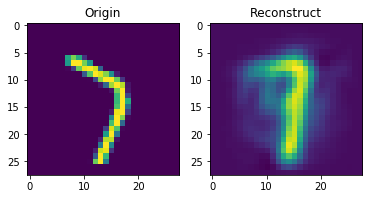

Testing loss = 36.122726(27.904143+8.218583), label=1


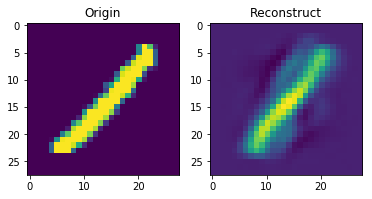

[Epoch 76] 16:05:51
[iteration 100]loss=37.874153(29.176851+8.697301)
[iteration 200]loss=36.437359(28.187487+8.249871)
[iteration 300]loss=39.478294(31.082586+8.395708)
[iteration 400]loss=37.158978(29.003860+8.155116)
[iteration 500]loss=38.417316(30.114462+8.302855)
[iteration 600]loss=39.211800(30.932222+8.279577)
[iteration 700]loss=38.917320(30.189041+8.728278)
[iteration 800]loss=38.054012(29.944687+8.109325)
Training loss = 36.399354(28.228190+8.171165), label=8


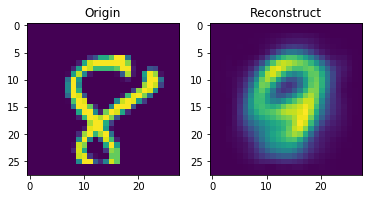

Validation loss = 36.188410(27.922753+8.265658), label=5


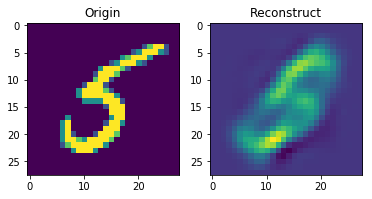

Testing loss = 36.295234(28.032683+8.262551), label=6


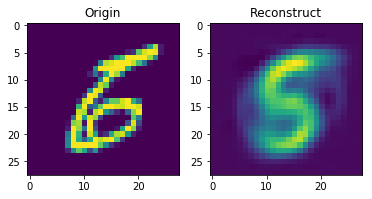

[Epoch 77] 16:05:55
[iteration 100]loss=35.763340(27.169029+8.594310)
[iteration 200]loss=37.614830(29.108894+8.505934)
[iteration 300]loss=38.591190(30.555704+8.035486)
[iteration 400]loss=38.794220(30.169836+8.624385)
[iteration 500]loss=38.345348(30.157675+8.187675)
[iteration 600]loss=38.546768(30.131046+8.415720)
[iteration 700]loss=36.978111(28.639206+8.338903)
[iteration 800]loss=37.906635(29.791094+8.115541)
Training loss = 36.391293(28.162549+8.228744), label=6


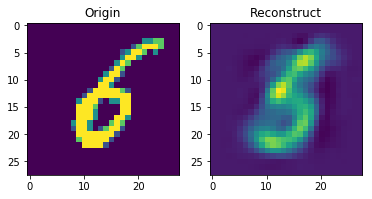

Validation loss = 36.104188(27.833793+8.270395), label=5


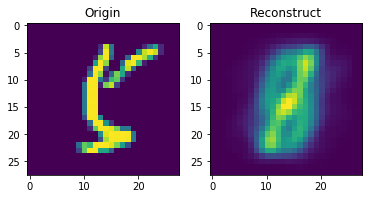

Testing loss = 36.296825(28.016336+8.280489), label=8


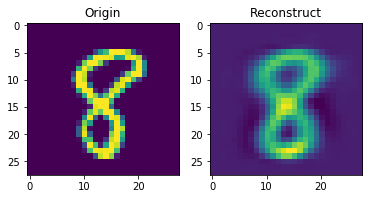

[Epoch 78] 16:06:00
[iteration 100]loss=38.355072(29.494587+8.860487)
[iteration 200]loss=36.237953(27.632965+8.604988)
[iteration 300]loss=38.432060(30.161507+8.270552)
[iteration 400]loss=37.942005(29.294889+8.647116)
[iteration 500]loss=38.041759(29.614971+8.426787)
[iteration 600]loss=37.448181(29.249788+8.198394)
[iteration 700]loss=37.210350(28.688374+8.521977)
[iteration 800]loss=38.804146(30.590443+8.213702)
Training loss = 36.377571(28.097467+8.280105), label=4


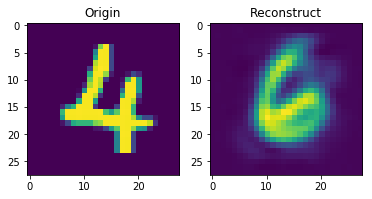

Validation loss = 36.071915(27.755537+8.316377), label=4


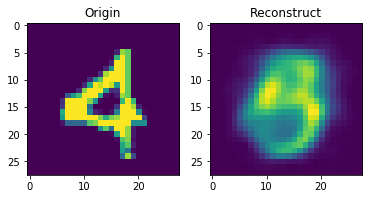

Testing loss = 36.067542(27.768089+8.299453), label=8


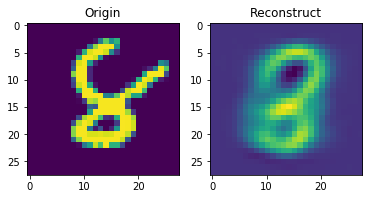

[Epoch 79] 16:06:04
[iteration 100]loss=36.743790(28.544577+8.199211)
[iteration 200]loss=37.212116(29.280535+7.931583)
[iteration 300]loss=39.510178(30.812029+8.698147)
[iteration 400]loss=37.787365(29.191536+8.595828)
[iteration 500]loss=37.759117(28.784975+8.974142)
[iteration 600]loss=38.282978(29.374557+8.908421)
[iteration 700]loss=37.357719(29.517139+7.840578)
[iteration 800]loss=36.027287(27.567892+8.459394)
Training loss = 36.335513(28.204902+8.130611), label=6


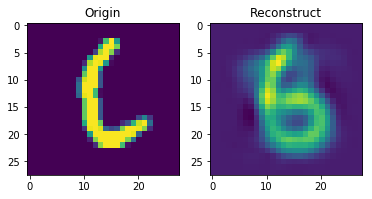

Validation loss = 35.972313(27.776846+8.195467), label=3


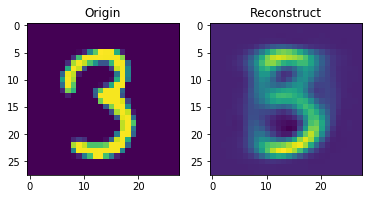

Testing loss = 36.403201(28.201668+8.201533), label=7


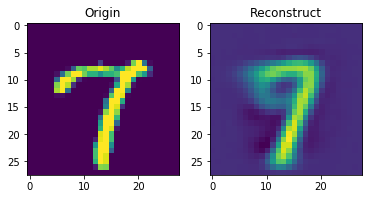

[Epoch 80] 16:06:09
[iteration 100]loss=39.009575(30.251289+8.758287)
[iteration 200]loss=36.440098(28.402395+8.037702)
[iteration 300]loss=38.618500(29.597202+9.021298)
[iteration 400]loss=38.043392(29.821468+8.221923)
[iteration 500]loss=39.073235(30.694801+8.378431)
[iteration 600]loss=36.501244(28.006668+8.494576)
[iteration 700]loss=37.154823(29.191935+7.962891)
[iteration 800]loss=38.719429(30.731115+7.988314)
Training loss = 36.266084(28.053239+8.212846), label=9


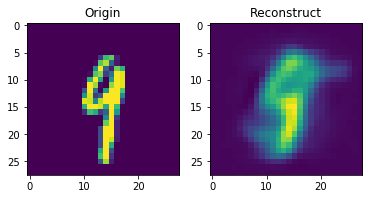

Validation loss = 36.308302(28.048494+8.259807), label=9


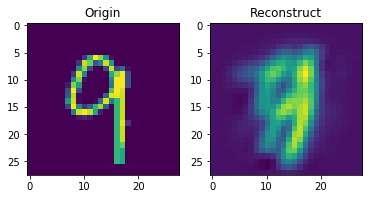

Testing loss = 36.203031(27.925243+8.277788), label=8


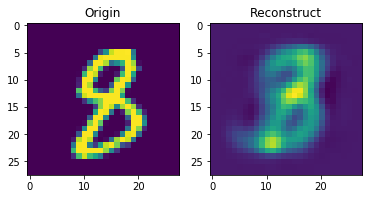

[Epoch 81] 16:06:13
[iteration 100]loss=36.457710(28.000175+8.457534)
[iteration 200]loss=37.368538(29.077049+8.291491)
[iteration 300]loss=35.122250(26.708256+8.413995)
[iteration 400]loss=40.308945(31.431816+8.877130)
[iteration 500]loss=36.186798(28.156139+8.030659)
[iteration 600]loss=39.524067(30.840788+8.683279)
[iteration 700]loss=36.185600(28.204140+7.981460)
[iteration 800]loss=37.990318(29.677917+8.312401)
Training loss = 36.287187(28.062412+8.224776), label=4


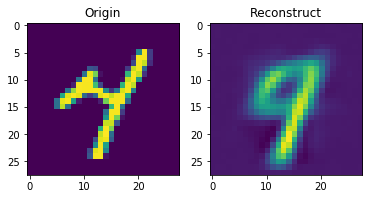

Validation loss = 35.975402(27.691580+8.283823), label=5


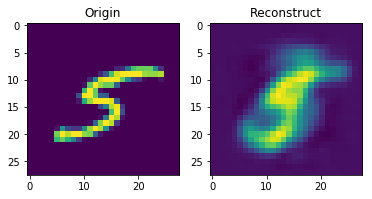

Testing loss = 36.044899(27.741378+8.303521), label=3


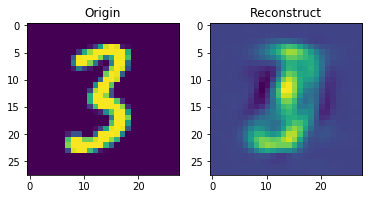

[Epoch 82] 16:06:17
[iteration 100]loss=35.783127(27.760752+8.022375)
[iteration 200]loss=36.106907(27.844292+8.262616)
[iteration 300]loss=36.158642(28.248594+7.910048)
[iteration 400]loss=38.084759(29.851748+8.233010)
[iteration 500]loss=37.062454(28.629475+8.432980)
[iteration 600]loss=35.309143(27.284096+8.025048)
[iteration 700]loss=38.276093(29.813820+8.462271)
[iteration 800]loss=37.712410(29.334719+8.377689)
Training loss = 36.302628(28.113279+8.189348), label=2


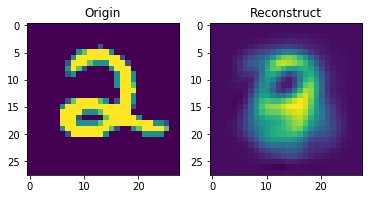

Validation loss = 36.061329(27.836374+8.224955), label=4


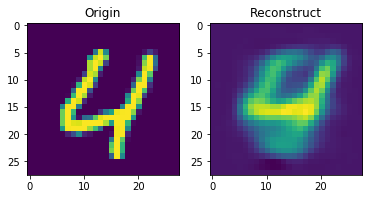

Testing loss = 36.271891(28.018341+8.253549), label=7


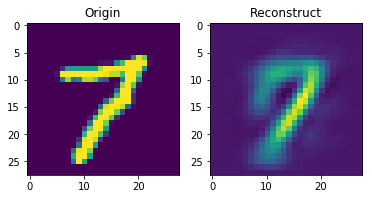

[Epoch 83] 16:06:22
[iteration 100]loss=39.792168(31.362801+8.429365)
[iteration 200]loss=39.964798(30.984039+8.980761)
[iteration 300]loss=40.274525(31.740507+8.534018)
[iteration 400]loss=37.270405(29.359241+7.911162)
[iteration 500]loss=38.536629(29.764248+8.772382)
[iteration 600]loss=38.134769(29.420734+8.714035)
[iteration 700]loss=39.135796(30.710043+8.425755)
[iteration 800]loss=37.235023(29.180099+8.054925)
Training loss = 36.227929(28.041515+8.186413), label=8


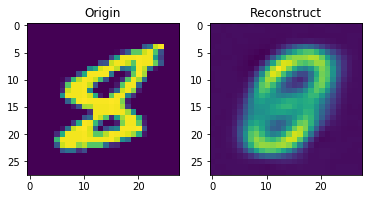

Validation loss = 35.908800(27.707003+8.201797), label=4


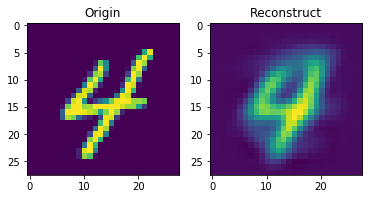

Testing loss = 36.009743(27.776232+8.233512), label=8


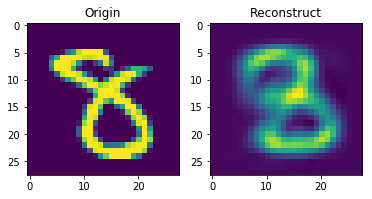

[Epoch 84] 16:06:26
[iteration 100]loss=38.391609(30.334702+8.056910)
[iteration 200]loss=38.336121(29.929817+8.406303)
[iteration 300]loss=37.398750(29.057724+8.341028)
[iteration 400]loss=39.389664(30.695787+8.693874)
[iteration 500]loss=38.692253(30.249786+8.442467)
[iteration 600]loss=37.478142(28.891319+8.586824)
[iteration 700]loss=38.529366(29.995110+8.534257)
[iteration 800]loss=39.451149(30.811932+8.639217)
Training loss = 36.266926(28.119533+8.147393), label=7


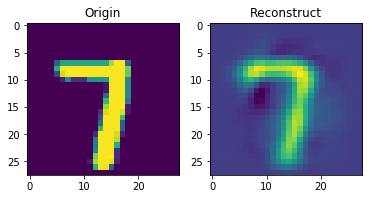

Validation loss = 35.937761(27.745393+8.192368), label=6


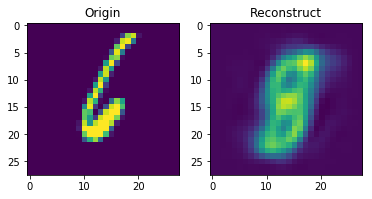

Testing loss = 36.136629(27.937870+8.198758), label=0


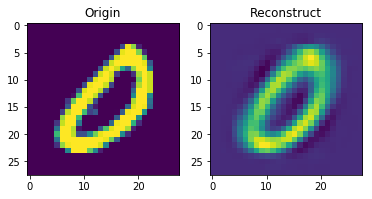

[Epoch 85] 16:06:31
[iteration 100]loss=37.284393(29.275658+8.008735)
[iteration 200]loss=37.746834(29.668398+8.078434)
[iteration 300]loss=37.360252(28.843544+8.516706)
[iteration 400]loss=38.428898(30.011602+8.417295)
[iteration 500]loss=38.036205(29.127089+8.909117)
[iteration 600]loss=39.041874(30.667927+8.373946)
[iteration 700]loss=37.058861(29.086767+7.972092)
[iteration 800]loss=37.300991(28.738405+8.562585)
Training loss = 36.308164(28.125239+8.182925), label=2


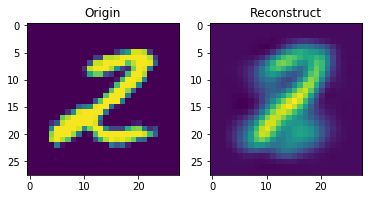

Validation loss = 36.057284(27.799019+8.258265), label=0


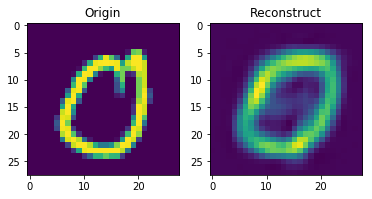

Testing loss = 36.057391(27.806935+8.250457), label=1


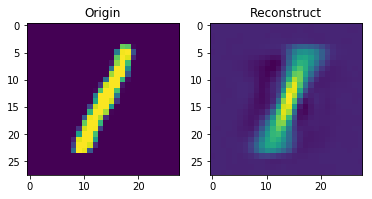

[Epoch 86] 16:06:35
[iteration 100]loss=37.477074(29.120905+8.356167)
[iteration 200]loss=35.469856(27.381706+8.088152)
[iteration 300]loss=35.468620(27.363274+8.105349)
[iteration 400]loss=35.663639(27.392529+8.271111)
[iteration 500]loss=39.202660(30.736130+8.466530)
[iteration 600]loss=36.570396(28.497334+8.073063)
[iteration 700]loss=37.143272(28.549660+8.593611)
[iteration 800]loss=37.893616(29.190907+8.702707)
Training loss = 36.217727(27.994166+8.223561), label=2


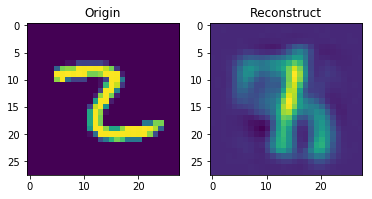

Validation loss = 36.066728(27.816388+8.250339), label=4


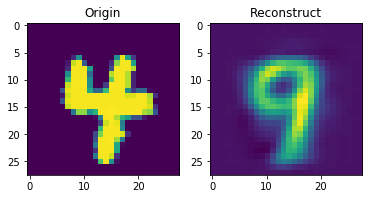

Testing loss = 36.127082(27.832319+8.294763), label=0


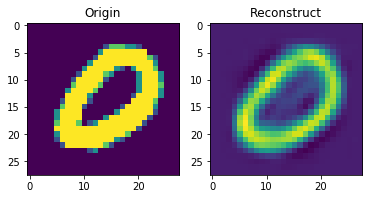

[Epoch 87] 16:06:40
[iteration 100]loss=37.314358(29.256287+8.058072)
[iteration 200]loss=39.719196(31.147755+8.571443)
[iteration 300]loss=39.348412(30.913155+8.435256)
[iteration 400]loss=38.594471(30.088503+8.505969)
[iteration 500]loss=38.166012(29.599213+8.566798)
[iteration 600]loss=36.269573(27.507425+8.762148)
[iteration 700]loss=35.708424(27.498043+8.210382)
[iteration 800]loss=38.383244(30.104986+8.278258)
Training loss = 36.298849(28.037213+8.261636), label=0


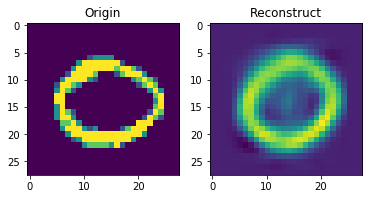

Validation loss = 36.018287(27.717338+8.300949), label=9


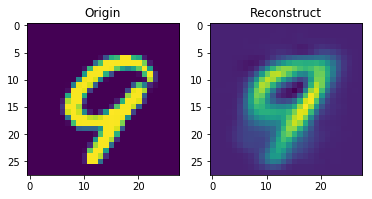

Testing loss = 35.964190(27.669959+8.294231), label=0


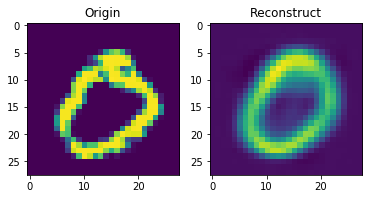

[Epoch 88] 16:06:45
[iteration 100]loss=34.924179(26.844954+8.079226)
[iteration 200]loss=36.713348(28.566975+8.146376)
[iteration 300]loss=40.248558(31.837475+8.411083)
[iteration 400]loss=35.600548(27.506893+8.093655)
[iteration 500]loss=39.066772(30.715481+8.351294)
[iteration 600]loss=37.592628(29.111061+8.481565)
[iteration 700]loss=36.113258(28.058273+8.054983)
[iteration 800]loss=37.401840(28.698166+8.703676)
Training loss = 36.198258(27.993771+8.204487), label=7


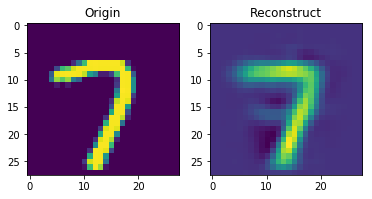

Validation loss = 35.938907(27.659027+8.279880), label=0


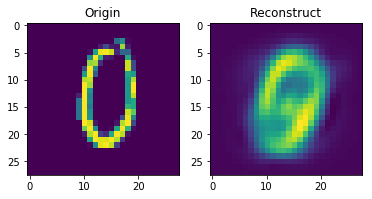

Testing loss = 35.992642(27.721381+8.271261), label=1


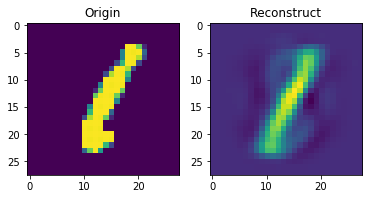

[Epoch 89] 16:06:49
[iteration 100]loss=38.261929(29.792313+8.469615)
[iteration 200]loss=39.933411(31.117596+8.815817)
[iteration 300]loss=38.990055(30.826599+8.163457)
[iteration 400]loss=36.319530(28.362461+7.957069)
[iteration 500]loss=37.577076(29.317974+8.259102)
[iteration 600]loss=36.989422(29.274063+7.715359)
[iteration 700]loss=37.357002(28.858368+8.498636)
[iteration 800]loss=36.202316(28.076431+8.125883)
Training loss = 36.110479(27.892144+8.218335), label=5


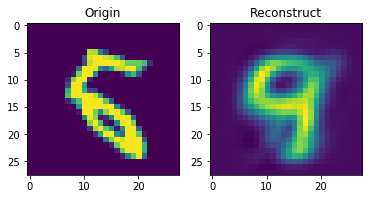

Validation loss = 36.087837(27.795250+8.292588), label=2


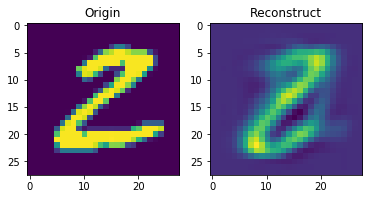

Testing loss = 35.949943(27.651661+8.298282), label=4


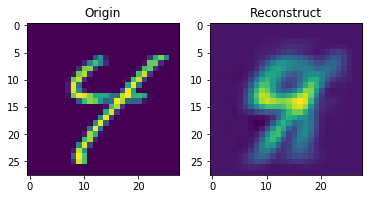

[Epoch 90] 16:06:54
[iteration 100]loss=40.650749(31.415794+9.234957)
[iteration 200]loss=37.582489(29.142029+8.440459)
[iteration 300]loss=37.463364(28.938023+8.525339)
[iteration 400]loss=40.358147(31.585594+8.772554)
[iteration 500]loss=37.267860(28.365206+8.902656)
[iteration 600]loss=39.272839(30.472347+8.800491)
[iteration 700]loss=38.157181(30.062347+8.094831)
[iteration 800]loss=36.536873(28.414013+8.122860)
Training loss = 36.174552(27.948801+8.225751), label=6


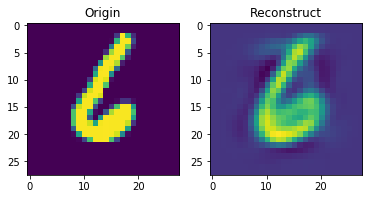

Validation loss = 35.836016(27.587086+8.248930), label=2


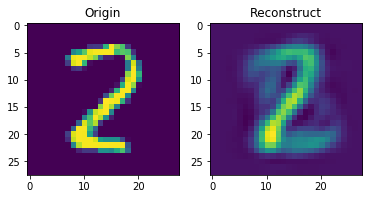

Testing loss = 35.906534(27.621960+8.284574), label=5


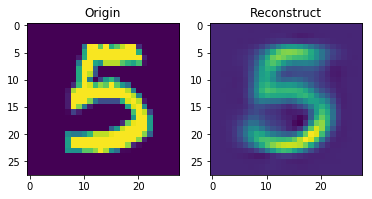

[Epoch 91] 16:06:59
[iteration 100]loss=39.473488(30.980572+8.492917)
[iteration 200]loss=36.397343(27.929237+8.468105)
[iteration 300]loss=37.658806(28.929655+8.729151)
[iteration 400]loss=36.003204(27.834330+8.168873)
[iteration 500]loss=37.324898(28.778946+8.545950)
[iteration 600]loss=35.287964(27.447403+7.840562)
[iteration 700]loss=40.961357(32.822746+8.138609)
[iteration 800]loss=38.034569(29.830179+8.204390)
Training loss = 36.151731(27.944854+8.206877), label=0


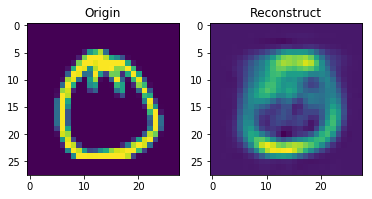

Validation loss = 35.835449(27.577639+8.257810), label=7


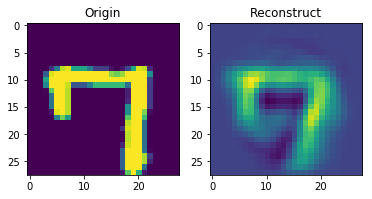

Testing loss = 36.026707(27.752080+8.274627), label=9


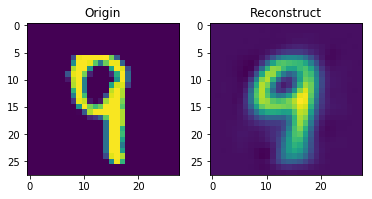

[Epoch 92] 16:07:03
[iteration 100]loss=38.063576(29.415409+8.648167)
[iteration 200]loss=36.465942(28.475552+7.990389)
[iteration 300]loss=37.229782(29.409260+7.820523)
[iteration 400]loss=38.184608(29.939341+8.245268)
[iteration 500]loss=34.575706(26.151482+8.424225)
[iteration 600]loss=36.713024(28.374340+8.338684)
[iteration 700]loss=36.561298(28.156666+8.404634)
[iteration 800]loss=38.283127(30.061319+8.221809)
Training loss = 36.139172(27.891049+8.248123), label=8


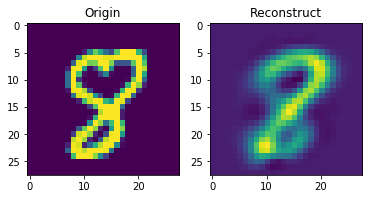

Validation loss = 35.891961(27.601331+8.290631), label=3


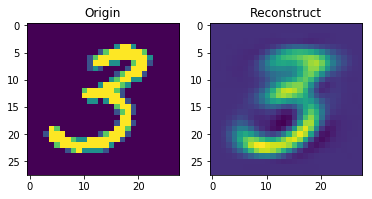

Testing loss = 36.024870(27.713782+8.311088), label=2


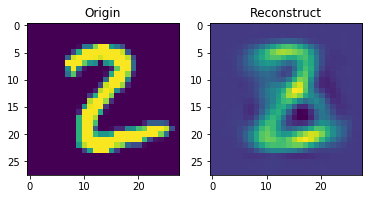

[Epoch 93] 16:07:07
[iteration 100]loss=37.858124(29.067669+8.790456)
[iteration 200]loss=36.312954(28.172192+8.140761)
[iteration 300]loss=36.960800(28.425482+8.535320)
[iteration 400]loss=37.325962(29.009579+8.316383)
[iteration 500]loss=38.600052(30.060337+8.539717)
[iteration 600]loss=35.724480(27.364731+8.359749)
[iteration 700]loss=39.191563(30.261824+8.929739)
[iteration 800]loss=36.237816(28.182823+8.054991)
Training loss = 36.116626(27.932311+8.184314), label=5


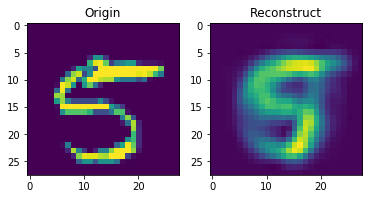

Validation loss = 35.922582(27.676475+8.246108), label=0


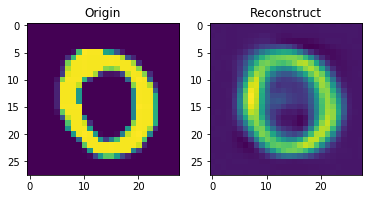

Testing loss = 35.894539(27.656926+8.237613), label=9


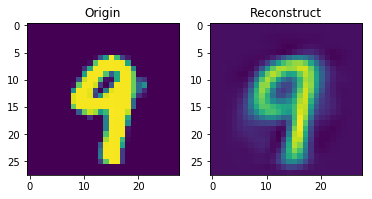

[Epoch 94] 16:07:12
[iteration 100]loss=37.982361(29.307201+8.675161)
[iteration 200]loss=37.286278(29.002607+8.283671)
[iteration 300]loss=36.928520(29.234207+7.694312)
[iteration 400]loss=37.938637(29.896324+8.042314)
[iteration 500]loss=35.753906(27.339645+8.414259)
[iteration 600]loss=37.440498(28.740120+8.700377)
[iteration 700]loss=35.021046(27.011417+8.009627)
[iteration 800]loss=36.651913(28.348402+8.303512)
Training loss = 36.129019(27.933006+8.196012), label=9


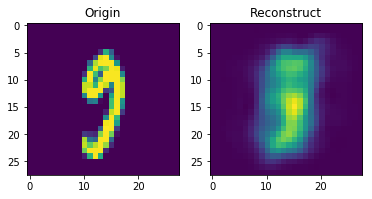

Validation loss = 35.878057(27.641610+8.236446), label=2


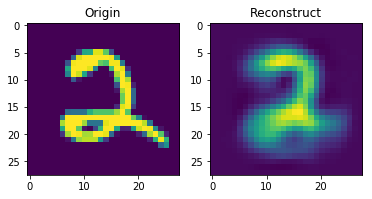

Testing loss = 36.136971(27.901064+8.235907), label=0


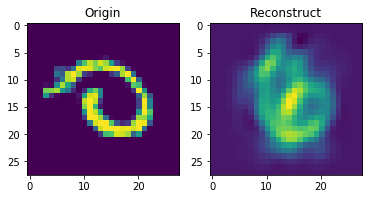

[Epoch 95] 16:07:16
[iteration 100]loss=39.795265(31.008291+8.786973)
[iteration 200]loss=37.435913(29.539875+7.896038)
[iteration 300]loss=38.305893(29.823093+8.482800)
[iteration 400]loss=39.956451(31.314941+8.641509)
[iteration 500]loss=39.324448(31.551718+7.772732)
[iteration 600]loss=36.860786(28.713556+8.147230)
[iteration 700]loss=37.560665(29.575333+7.985333)
[iteration 800]loss=37.833023(29.269878+8.563143)
Training loss = 36.061037(27.841732+8.219305), label=2


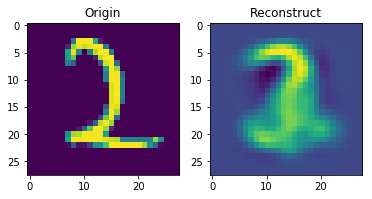

Validation loss = 35.793181(27.528993+8.264188), label=5


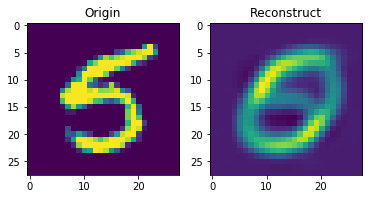

Testing loss = 35.869631(27.594424+8.275207), label=5


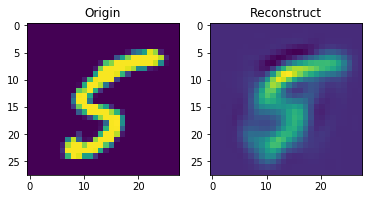

[Epoch 96] 16:07:21
[iteration 100]loss=37.176167(28.788719+8.387448)
[iteration 200]loss=38.145901(29.347507+8.798392)
[iteration 300]loss=35.466061(27.231842+8.234218)
[iteration 400]loss=35.256691(27.171175+8.085518)
[iteration 500]loss=36.832317(28.500984+8.331333)
[iteration 600]loss=36.608719(28.382103+8.226615)
[iteration 700]loss=37.415985(29.289337+8.126646)
[iteration 800]loss=37.904480(29.270035+8.634445)
Training loss = 36.030413(27.843387+8.187026), label=9


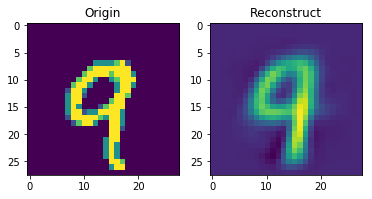

Validation loss = 35.751552(27.507218+8.244334), label=5


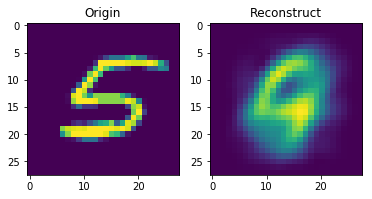

Testing loss = 35.996132(27.723031+8.273100), label=3


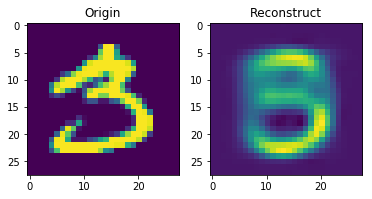

[Epoch 97] 16:07:25
[iteration 100]loss=36.770966(29.029005+7.741961)
[iteration 200]loss=35.473213(27.385298+8.087917)
[iteration 300]loss=37.079758(28.612997+8.466759)
[iteration 400]loss=39.462292(30.369144+9.093147)
[iteration 500]loss=39.825233(31.619482+8.205750)
[iteration 600]loss=38.618671(30.190138+8.428534)
[iteration 700]loss=38.667000(29.942024+8.724977)
[iteration 800]loss=37.375496(29.226177+8.149321)
Training loss = 36.082387(27.861453+8.220934), label=9


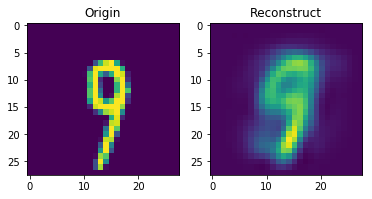

Validation loss = 35.831764(27.582732+8.249032), label=0


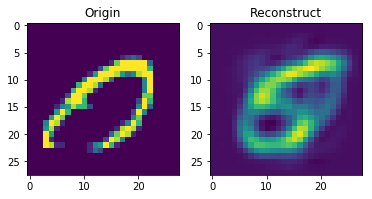

Testing loss = 36.005131(27.709776+8.295355), label=9


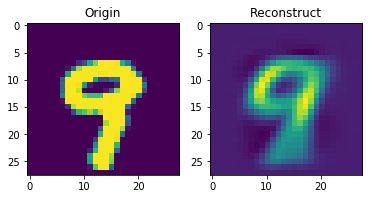

[Epoch 98] 16:07:30
[iteration 100]loss=39.381474(30.821697+8.559777)
[iteration 200]loss=37.395000(29.034279+8.360721)
[iteration 300]loss=37.386734(28.917068+8.469666)
[iteration 400]loss=37.413494(28.953178+8.460317)
[iteration 500]loss=37.453293(28.715977+8.737317)
[iteration 600]loss=35.903931(27.319122+8.584810)
[iteration 700]loss=34.617352(26.304173+8.313178)
[iteration 800]loss=38.010521(29.400280+8.610239)
Training loss = 36.092878(27.926243+8.166635), label=3


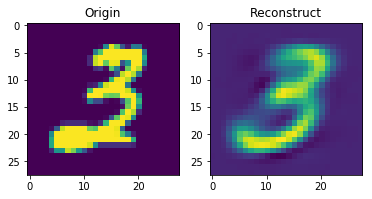

Validation loss = 35.755298(27.517047+8.238251), label=8


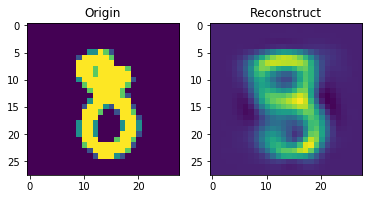

Testing loss = 35.878806(27.646961+8.231845), label=7


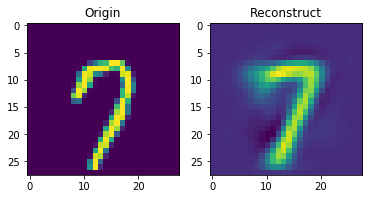

[Epoch 99] 16:07:34
[iteration 100]loss=39.783527(30.963388+8.820139)
[iteration 200]loss=37.150948(28.576933+8.574013)
[iteration 300]loss=36.464802(27.982416+8.482386)
[iteration 400]loss=38.212685(29.362448+8.850239)
[iteration 500]loss=37.002930(28.323326+8.679604)
[iteration 600]loss=36.998875(29.308613+7.690262)
[iteration 700]loss=36.463837(28.218233+8.245605)
[iteration 800]loss=38.257698(29.929790+8.327909)
Training loss = 36.061885(27.850931+8.210954), label=3


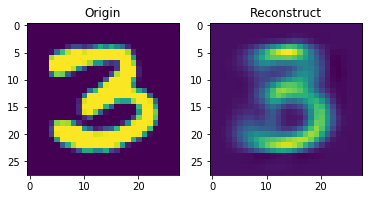

Validation loss = 35.671127(27.412053+8.259074), label=1


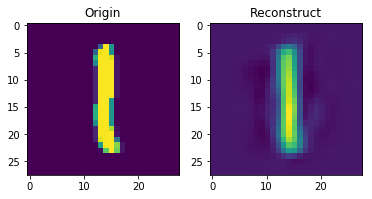

Testing loss = 35.894372(27.650691+8.243681), label=1


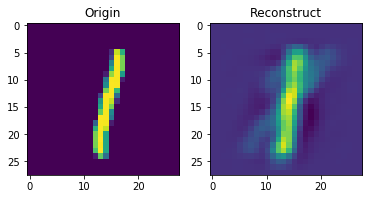

[Epoch 100] 16:07:39
[iteration 100]loss=39.967686(30.977997+8.989689)
[iteration 200]loss=37.493515(29.306467+8.187050)
[iteration 300]loss=37.346008(29.276079+8.069931)
[iteration 400]loss=35.420944(27.201101+8.219841)
[iteration 500]loss=34.878502(26.569221+8.309281)
[iteration 600]loss=34.470501(26.398148+8.072353)
[iteration 700]loss=38.373833(29.647602+8.726232)
[iteration 800]loss=37.062347(28.934423+8.127924)
Training loss = 36.028444(27.853884+8.174560), label=2


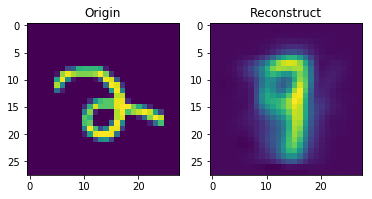

Validation loss = 35.852747(27.637941+8.214805), label=3


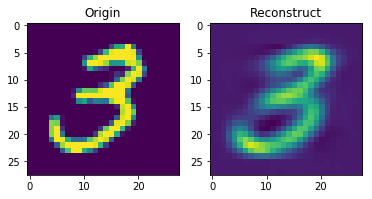

Testing loss = 35.889702(27.626639+8.263063), label=0


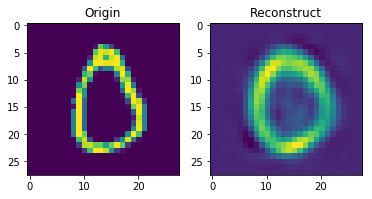

[Epoch 101] 16:07:43
[iteration 100]loss=39.185844(30.801853+8.383989)
[iteration 200]loss=40.096004(31.586975+8.509030)
[iteration 300]loss=37.757317(29.087856+8.669459)
[iteration 400]loss=37.895882(29.476404+8.419479)
[iteration 500]loss=37.833603(29.642670+8.190935)
[iteration 600]loss=38.854122(30.234880+8.619241)
[iteration 700]loss=36.943291(28.654308+8.288984)
[iteration 800]loss=39.467190(30.991062+8.476127)
Training loss = 36.016054(27.792303+8.223752), label=7


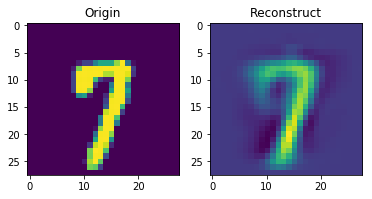

Validation loss = 35.806759(27.530850+8.275909), label=0


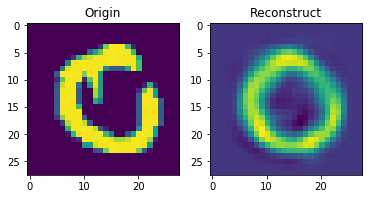

Testing loss = 35.925562(27.646910+8.278652), label=8


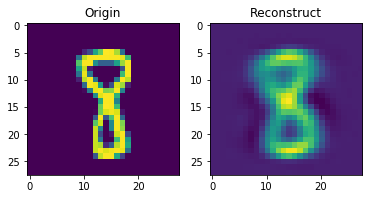

[Epoch 102] 16:07:48
[iteration 100]loss=38.171185(29.869072+8.302113)
[iteration 200]loss=36.693874(27.768471+8.925405)
[iteration 300]loss=39.220680(31.121992+8.098688)
[iteration 400]loss=36.201092(27.478058+8.723035)
[iteration 500]loss=35.504890(27.658724+7.846167)
[iteration 600]loss=37.324528(28.711617+8.612911)
[iteration 700]loss=37.201473(28.488205+8.713268)
[iteration 800]loss=38.719528(29.552330+9.167198)
Training loss = 36.049047(27.875269+8.173778), label=4


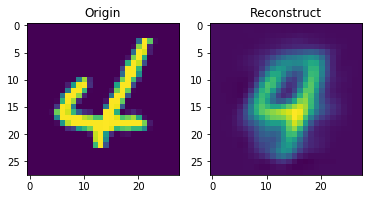

Validation loss = 35.753694(27.546021+8.207673), label=0


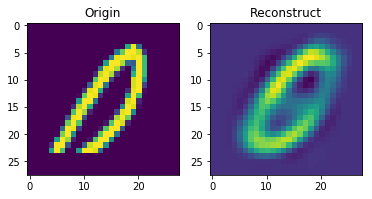

Testing loss = 35.941460(27.715253+8.226207), label=1


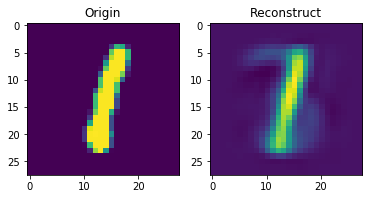

[Epoch 103] 16:07:52
[iteration 100]loss=37.491875(28.811783+8.680092)
[iteration 200]loss=35.326851(27.519318+7.807534)
[iteration 300]loss=37.103973(28.552788+8.551186)
[iteration 400]loss=35.216995(27.124691+8.092306)
[iteration 500]loss=36.849731(28.442249+8.407484)
[iteration 600]loss=36.865459(28.667736+8.197722)
[iteration 700]loss=38.756058(30.097076+8.658982)
[iteration 800]loss=36.935219(28.812796+8.122423)
Training loss = 35.998732(27.801284+8.197448), label=3


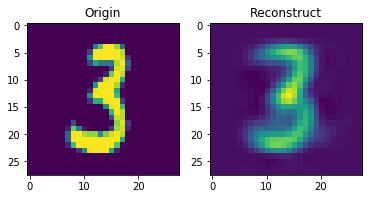

Validation loss = 35.785359(27.527510+8.257849), label=7


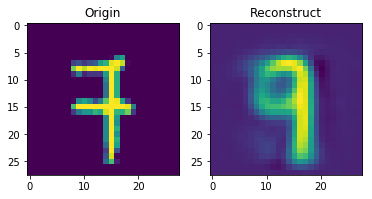

Testing loss = 35.945922(27.672329+8.273594), label=7


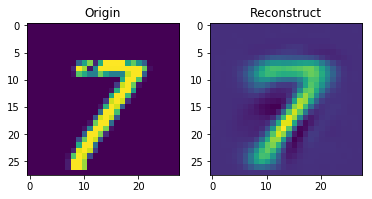

[Epoch 104] 16:07:57
[iteration 100]loss=36.681698(28.133854+8.547844)
[iteration 200]loss=34.917397(26.587982+8.329412)
[iteration 300]loss=36.605503(28.491444+8.114059)
[iteration 400]loss=37.659584(29.374105+8.285479)
[iteration 500]loss=37.951874(29.600956+8.350920)
[iteration 600]loss=39.905167(31.804638+8.100529)
[iteration 700]loss=37.699310(29.550846+8.148466)
[iteration 800]loss=35.503548(27.813374+7.690176)
Training loss = 35.973572(27.797987+8.175585), label=6


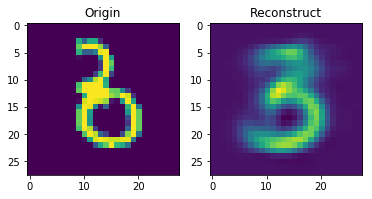

Validation loss = 35.838597(27.602045+8.236552), label=8


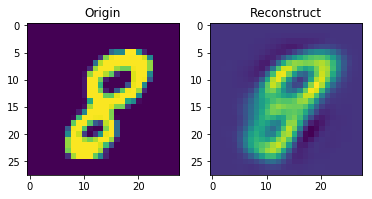

Testing loss = 35.882584(27.638147+8.244436), label=0


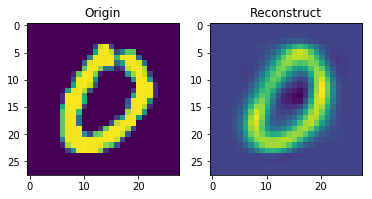

[Epoch 105] 16:08:01
[iteration 100]loss=35.163582(26.626543+8.537041)
[iteration 200]loss=37.485828(28.975586+8.510242)
[iteration 300]loss=38.077301(29.641655+8.435644)
[iteration 400]loss=38.191677(30.072145+8.119531)
[iteration 500]loss=39.152351(30.432049+8.720304)
[iteration 600]loss=38.802177(30.529348+8.272830)
[iteration 700]loss=38.103947(29.517378+8.586569)
[iteration 800]loss=35.687504(27.521130+8.166375)
Training loss = 36.025617(27.842492+8.183125), label=2


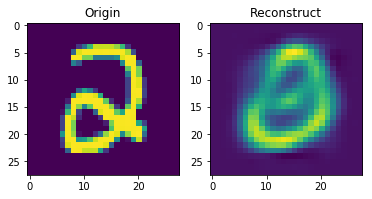

Validation loss = 35.718105(27.476968+8.241137), label=1


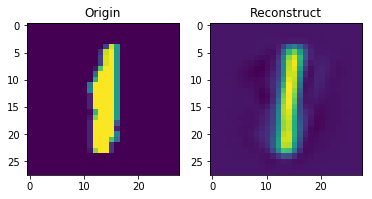

Testing loss = 35.826740(27.589056+8.237684), label=1


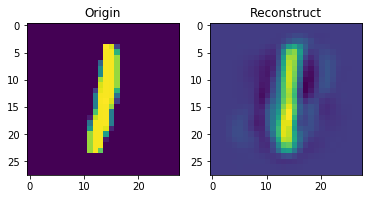

[Epoch 106] 16:08:06
[iteration 100]loss=38.335365(29.507549+8.827816)
[iteration 200]loss=40.993000(32.220749+8.772251)
[iteration 300]loss=38.600761(30.118828+8.481935)
[iteration 400]loss=37.296410(28.966970+8.329441)
[iteration 500]loss=36.964363(29.127197+7.837164)
[iteration 600]loss=34.487694(26.396353+8.091341)
[iteration 700]loss=36.614826(28.671432+7.943395)
[iteration 800]loss=36.702541(28.140331+8.562210)
Training loss = 36.040976(27.829305+8.211671), label=5


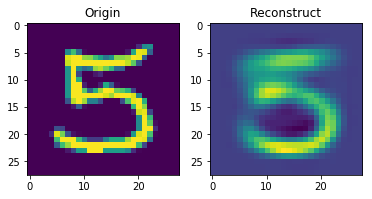

Validation loss = 35.569708(27.363081+8.206626), label=1


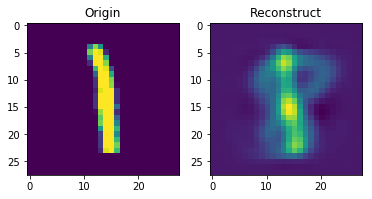

Testing loss = 35.764174(27.519990+8.244183), label=0


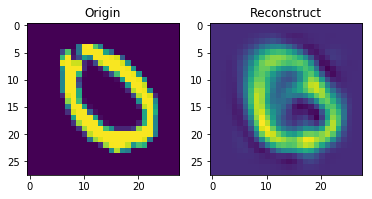

[Epoch 107] 16:08:10
[iteration 100]loss=36.971367(28.177685+8.793681)
[iteration 200]loss=36.548119(28.332222+8.215895)
[iteration 300]loss=37.170502(28.691902+8.478600)
[iteration 400]loss=35.620403(27.089661+8.530742)
[iteration 500]loss=38.921185(29.991535+8.929649)
[iteration 600]loss=38.815804(30.420948+8.394854)
[iteration 700]loss=37.743477(29.394974+8.348503)
[iteration 800]loss=35.958515(27.607197+8.351318)
Training loss = 36.044667(27.845885+8.198782), label=9


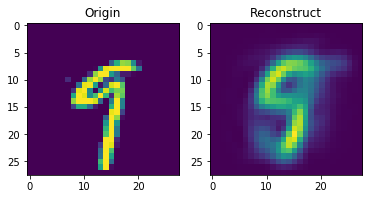

Validation loss = 35.813342(27.564426+8.248916), label=8


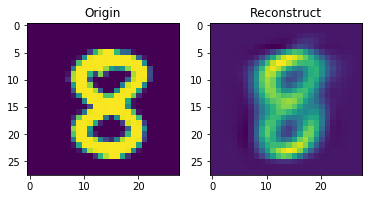

Testing loss = 35.925832(27.648421+8.277412), label=6


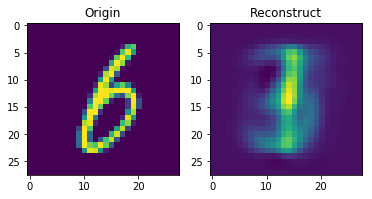

[Epoch 108] 16:08:14
[iteration 100]loss=38.690044(29.818768+8.871276)
[iteration 200]loss=39.010281(30.397877+8.612403)
[iteration 300]loss=39.493904(30.786831+8.707074)
[iteration 400]loss=36.217178(27.773512+8.443667)
[iteration 500]loss=37.464500(28.451090+9.013411)
[iteration 600]loss=38.976234(30.692379+8.283856)
[iteration 700]loss=35.553089(27.481174+8.071916)
[iteration 800]loss=37.550484(28.642719+8.907763)
Training loss = 36.053263(27.864338+8.188925), label=4


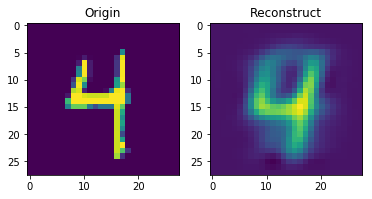

Validation loss = 35.815654(27.562750+8.252904), label=6


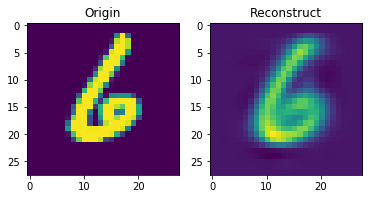

Testing loss = 35.882928(27.631775+8.251154), label=6


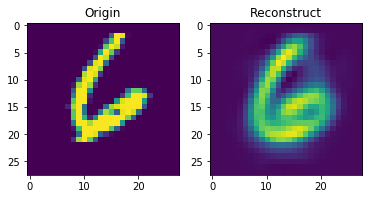

[Epoch 109] 16:08:19
[iteration 100]loss=36.702881(28.265360+8.437521)
[iteration 200]loss=37.468147(28.888361+8.579788)
[iteration 300]loss=37.590530(29.440172+8.150358)
[iteration 400]loss=39.577076(31.027493+8.549583)
[iteration 500]loss=38.610344(30.275295+8.335051)
[iteration 600]loss=37.477890(28.835785+8.642105)
[iteration 700]loss=38.220280(29.951992+8.268287)
[iteration 800]loss=39.184551(30.991777+8.192773)
Training loss = 36.004613(27.815066+8.189547), label=2


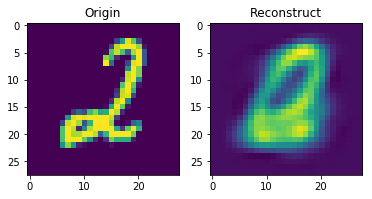

Validation loss = 35.511623(27.298033+8.213589), label=2


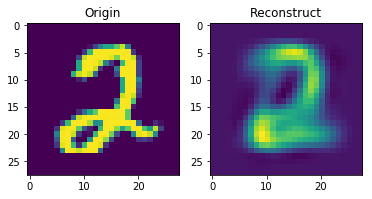

Testing loss = 35.796929(27.578028+8.218902), label=0


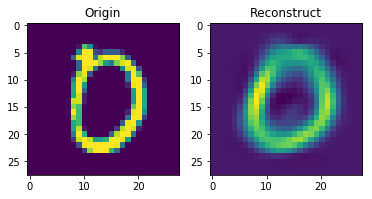

[Epoch 110] 16:08:24
[iteration 100]loss=34.200935(26.353153+7.847781)
[iteration 200]loss=38.257427(29.461016+8.796412)
[iteration 300]loss=38.726410(30.456358+8.270052)
[iteration 400]loss=37.121326(29.069511+8.051815)
[iteration 500]loss=38.600906(29.705883+8.895023)
[iteration 600]loss=37.066025(28.903248+8.162777)
[iteration 700]loss=36.714615(28.045824+8.668793)
[iteration 800]loss=35.815334(27.623768+8.191566)
Training loss = 35.987853(27.802612+8.185241), label=5


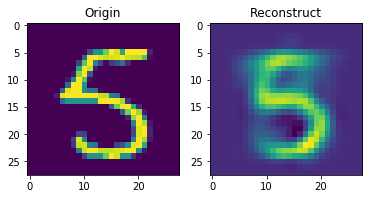

Validation loss = 35.572484(27.351174+8.221310), label=9


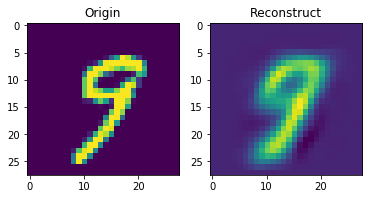

Testing loss = 35.964263(27.693235+8.271028), label=4


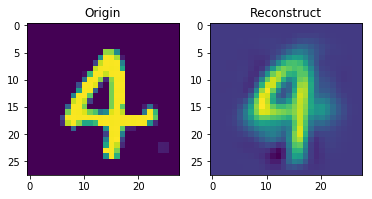

[Epoch 111] 16:08:28
[iteration 100]loss=39.343357(30.837364+8.505993)
[iteration 200]loss=34.663437(26.275276+8.388163)
[iteration 300]loss=36.047333(27.667694+8.379639)
[iteration 400]loss=36.977570(28.571117+8.406451)
[iteration 500]loss=39.160294(30.875294+8.285000)
[iteration 600]loss=39.686996(31.210077+8.476919)
[iteration 700]loss=40.914536(32.311604+8.602930)
[iteration 800]loss=37.106750(29.048988+8.057764)
Training loss = 35.918117(27.762876+8.155241), label=2


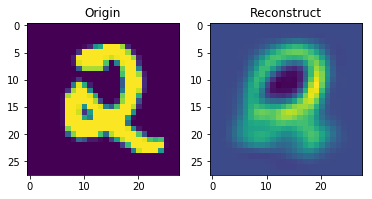

Validation loss = 35.697073(27.472903+8.224170), label=1


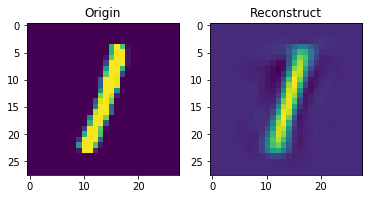

Testing loss = 35.897150(27.672059+8.225091), label=4


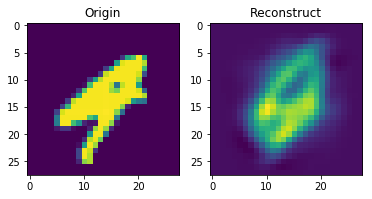

[Epoch 112] 16:08:33
[iteration 100]loss=37.874107(29.274883+8.599226)
[iteration 200]loss=38.061485(29.472105+8.589379)
[iteration 300]loss=39.797295(30.675861+9.121434)
[iteration 400]loss=35.961662(28.185465+7.776196)
[iteration 500]loss=39.138165(30.294395+8.843768)
[iteration 600]loss=37.570930(29.610399+7.960533)
[iteration 700]loss=38.094666(30.023115+8.071549)
[iteration 800]loss=37.247200(28.947506+8.299696)
Training loss = 36.043765(27.902828+8.140938), label=9


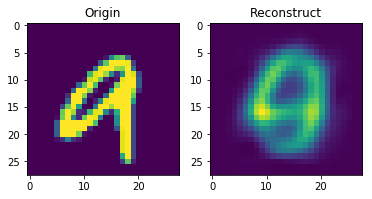

Validation loss = 35.740894(27.547711+8.193182), label=9


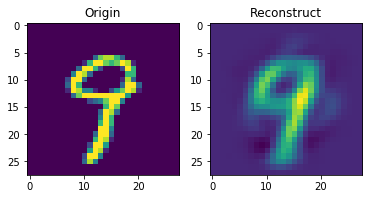

Testing loss = 35.793608(27.624123+8.169486), label=3


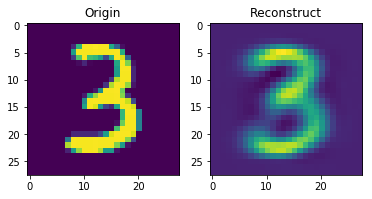

[Epoch 113] 16:08:37
[iteration 100]loss=38.733521(30.005341+8.728180)
[iteration 200]loss=36.717735(28.261141+8.456596)
[iteration 300]loss=39.814407(30.927231+8.887177)
[iteration 400]loss=37.101665(28.934416+8.167250)
[iteration 500]loss=40.098648(31.203810+8.894836)
[iteration 600]loss=37.935310(28.857088+9.078221)
[iteration 700]loss=37.404770(28.599354+8.805414)
[iteration 800]loss=36.448410(28.189304+8.259107)
Training loss = 35.990045(27.783925+8.206120), label=6


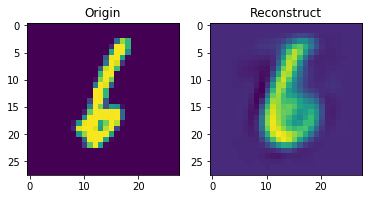

Validation loss = 35.594530(27.362582+8.231948), label=6


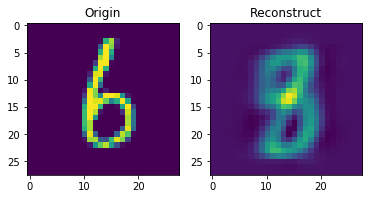

Testing loss = 35.880933(27.608607+8.272326), label=1


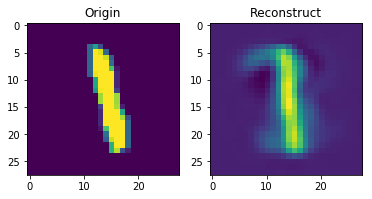

[Epoch 114] 16:08:42
[iteration 100]loss=36.411865(28.401190+8.010674)
[iteration 200]loss=36.621342(28.005280+8.616061)
[iteration 300]loss=37.321304(28.699120+8.622187)
[iteration 400]loss=36.369926(27.984173+8.385756)
[iteration 500]loss=36.727638(28.503967+8.223671)
[iteration 600]loss=37.586788(28.651962+8.934826)
[iteration 700]loss=36.957020(28.181965+8.775054)
[iteration 800]loss=38.300964(29.774445+8.526522)
Training loss = 35.994664(27.820820+8.173844), label=1


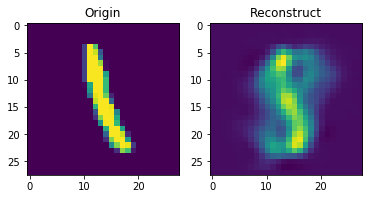

Validation loss = 35.738032(27.521460+8.216572), label=4


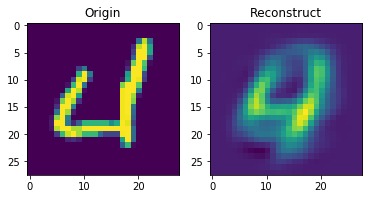

Testing loss = 35.712850(27.477120+8.235730), label=5


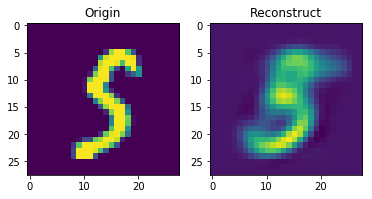

[Epoch 115] 16:08:46
[iteration 100]loss=37.350437(28.766008+8.584428)
[iteration 200]loss=40.291245(31.372290+8.918955)
[iteration 300]loss=37.764244(29.124638+8.639606)
[iteration 400]loss=38.233955(29.495338+8.738615)
[iteration 500]loss=38.851860(30.412510+8.439352)
[iteration 600]loss=38.527794(29.663048+8.864744)
[iteration 700]loss=37.291626(28.850994+8.440630)
[iteration 800]loss=36.651794(27.951269+8.700523)
Training loss = 36.017970(27.843946+8.174024), label=3


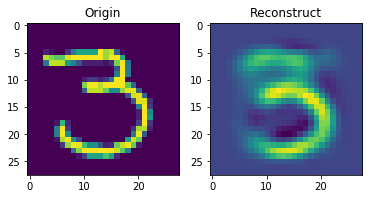

Validation loss = 35.787516(27.567844+8.219672), label=2


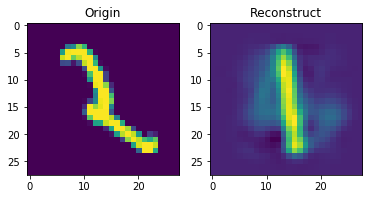

Testing loss = 35.917493(27.705355+8.212138), label=1


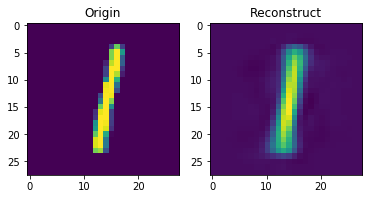

[Epoch 116] 16:08:51
[iteration 100]loss=39.356300(30.422562+8.933740)
[iteration 200]loss=38.423309(29.552517+8.870794)
[iteration 300]loss=38.265278(30.226837+8.038441)
[iteration 400]loss=36.014259(27.209888+8.804369)
[iteration 500]loss=36.988129(28.962959+8.025169)
[iteration 600]loss=39.338867(30.405186+8.933683)
[iteration 700]loss=36.163002(27.763863+8.399138)
[iteration 800]loss=37.182907(28.513674+8.669235)
Training loss = 35.972718(27.781518+8.191201), label=0


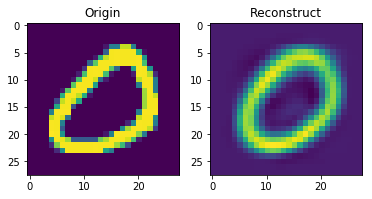

Validation loss = 35.643047(27.418518+8.224529), label=3


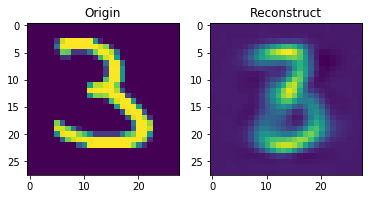

Testing loss = 35.734568(27.482003+8.252565), label=1


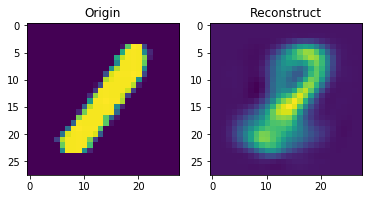

[Epoch 117] 16:08:55
[iteration 100]loss=38.447197(29.623871+8.823326)
[iteration 200]loss=38.912121(30.241230+8.670891)
[iteration 300]loss=36.652817(28.514812+8.138005)
[iteration 400]loss=36.586437(28.052868+8.533568)
[iteration 500]loss=37.890648(30.072193+7.818454)
[iteration 600]loss=35.584843(27.330969+8.253873)
[iteration 700]loss=38.442287(30.277184+8.165104)
[iteration 800]loss=36.886478(28.962076+7.924402)
Training loss = 35.973061(27.741809+8.231252), label=0


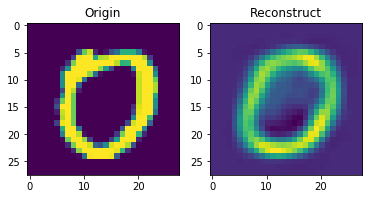

Validation loss = 35.637225(27.383581+8.253644), label=8


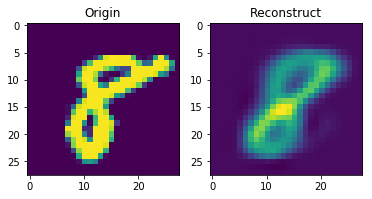

Testing loss = 35.828377(27.535280+8.293097), label=7


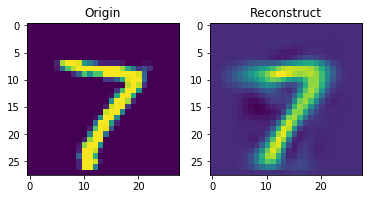

[Epoch 118] 16:09:00
[iteration 100]loss=36.781898(28.635269+8.146628)
[iteration 200]loss=35.596230(26.928577+8.667653)
[iteration 300]loss=36.956478(28.726515+8.229964)
[iteration 400]loss=40.739223(32.047638+8.691586)
[iteration 500]loss=37.330086(28.586969+8.743116)
[iteration 600]loss=40.551178(31.765072+8.786104)
[iteration 700]loss=35.473686(27.238613+8.235074)
[iteration 800]loss=37.357174(29.006084+8.351089)
Training loss = 35.951297(27.787057+8.164240), label=8


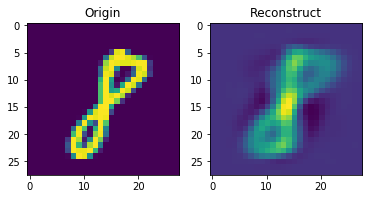

Validation loss = 35.607962(27.362920+8.245043), label=5


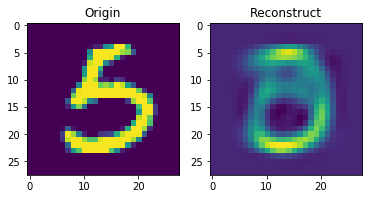

Testing loss = 35.902577(27.675340+8.227237), label=7


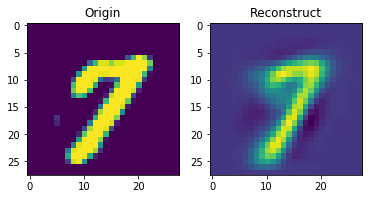

[Epoch 119] 16:09:04
[iteration 100]loss=36.951485(28.839140+8.112347)
[iteration 200]loss=38.462151(29.993290+8.468859)
[iteration 300]loss=35.343281(27.355442+7.987838)
[iteration 400]loss=38.157776(29.266422+8.891356)
[iteration 500]loss=37.631432(29.109161+8.522269)
[iteration 600]loss=38.937588(30.221079+8.716509)
[iteration 700]loss=37.408348(28.327354+9.080996)
[iteration 800]loss=37.389530(28.844841+8.544688)
Training loss = 35.997329(27.828699+8.168630), label=6


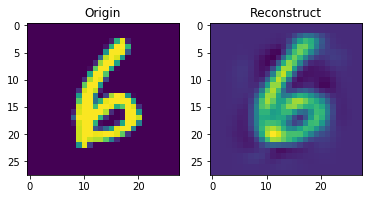

Validation loss = 35.951026(27.753277+8.197749), label=1


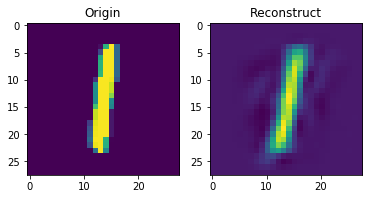

Testing loss = 35.842917(27.601275+8.241642), label=9


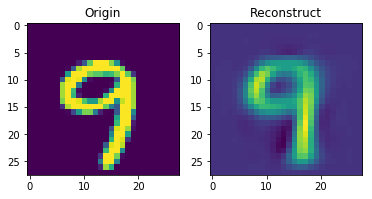

[Epoch 120] 16:09:09
[iteration 100]loss=35.367088(26.591261+8.775828)
[iteration 200]loss=39.743645(31.100834+8.642811)
[iteration 300]loss=38.071011(29.439096+8.631914)
[iteration 400]loss=37.560627(28.857227+8.703400)
[iteration 500]loss=38.464577(29.910507+8.554071)
[iteration 600]loss=35.889519(27.127216+8.762300)
[iteration 700]loss=36.013828(28.030979+7.982848)
[iteration 800]loss=36.095997(28.412182+7.683815)
Training loss = 35.992785(27.797267+8.195517), label=0


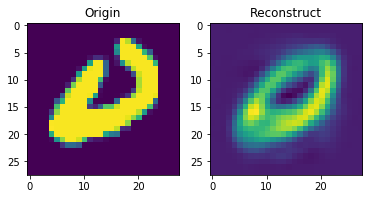

Validation loss = 35.837702(27.595006+8.242696), label=1


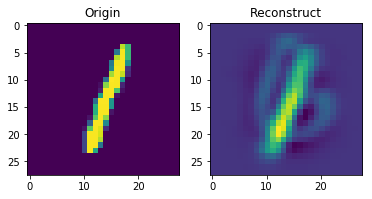

Testing loss = 35.687948(27.459993+8.227955), label=3


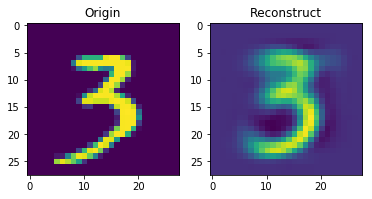

[Epoch 121] 16:09:13
[iteration 100]loss=37.868938(29.329521+8.539417)
[iteration 200]loss=36.749809(28.596931+8.152878)
[iteration 300]loss=40.040604(31.564058+8.476543)
[iteration 400]loss=35.262142(26.988041+8.274100)
[iteration 500]loss=36.184505(28.152966+8.031540)
[iteration 600]loss=37.696014(29.475050+8.220966)
[iteration 700]loss=38.832848(30.528812+8.304037)
[iteration 800]loss=34.618835(25.942902+8.675936)
Training loss = 35.903071(27.714509+8.188562), label=1


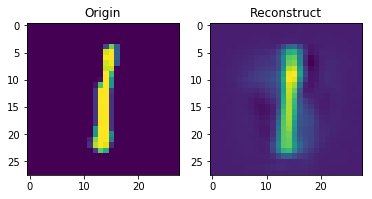

Validation loss = 35.719550(27.487566+8.231984), label=4


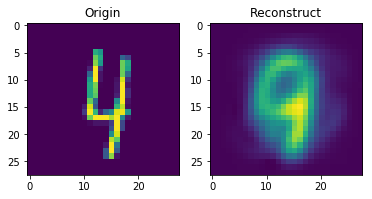

Testing loss = 35.852276(27.625997+8.226279), label=3


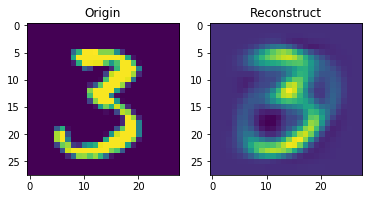

[Epoch 122] 16:09:18
[iteration 100]loss=36.329300(28.244061+8.085238)
[iteration 200]loss=38.179199(30.016819+8.162379)
[iteration 300]loss=36.706112(28.474592+8.231520)
[iteration 400]loss=37.801289(29.233612+8.567677)
[iteration 500]loss=38.352875(29.947374+8.405499)
[iteration 600]loss=34.221519(26.086710+8.134808)
[iteration 700]loss=38.681282(30.356239+8.325041)
[iteration 800]loss=36.774387(28.151180+8.623208)
Training loss = 35.903731(27.728714+8.175017), label=0


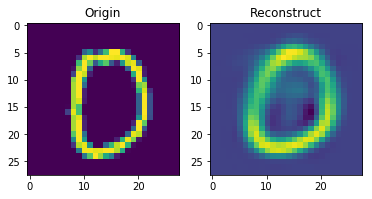

Validation loss = 35.661160(27.446548+8.214613), label=0


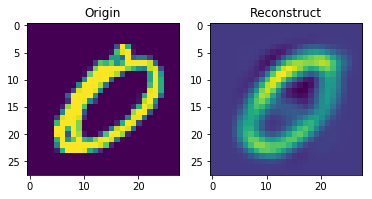

Testing loss = 35.839046(27.619207+8.219839), label=5


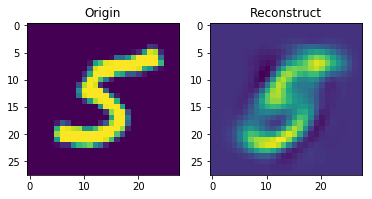

[Epoch 123] 16:09:22
[iteration 100]loss=38.704468(30.078810+8.625657)
[iteration 200]loss=35.657204(27.703413+7.953791)
[iteration 300]loss=38.689533(30.342667+8.346867)
[iteration 400]loss=38.521347(29.953178+8.568170)
[iteration 500]loss=38.397957(29.896965+8.500994)
[iteration 600]loss=38.039688(30.171005+7.868681)
[iteration 700]loss=37.549904(29.410616+8.139286)
[iteration 800]loss=36.519714(28.227348+8.292367)
Training loss = 35.949522(27.822416+8.127106), label=8


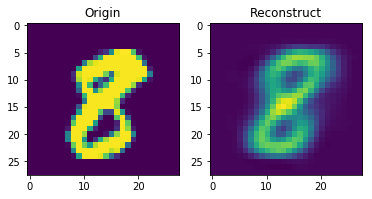

Validation loss = 35.661741(27.491921+8.169820), label=4


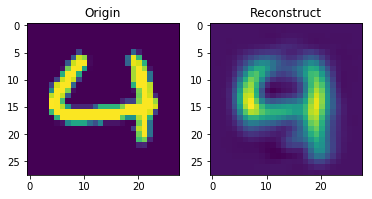

Testing loss = 35.832436(27.611510+8.220926), label=2


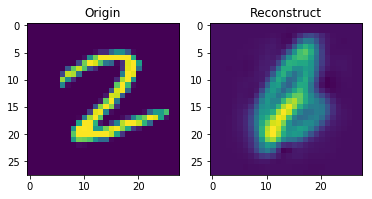

[Epoch 124] 16:09:27
[iteration 100]loss=35.680367(27.483047+8.197321)
[iteration 200]loss=35.351952(27.388531+7.963422)
[iteration 300]loss=40.136116(31.193623+8.942494)
[iteration 400]loss=40.003605(31.830944+8.172660)
[iteration 500]loss=36.811211(29.187904+7.623307)
[iteration 600]loss=37.481823(29.359961+8.121862)
[iteration 700]loss=38.115349(29.633095+8.482256)
[iteration 800]loss=36.880505(28.999071+7.881433)
Training loss = 35.970102(27.798677+8.171425), label=7


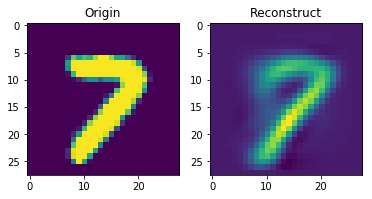

Validation loss = 35.485714(27.274403+8.211312), label=9


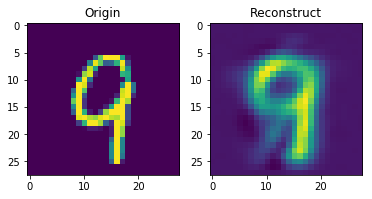

Testing loss = 35.812495(27.605528+8.206966), label=1


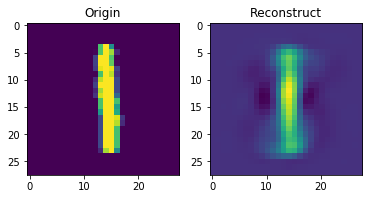

[Epoch 125] 16:09:31
[iteration 100]loss=34.256439(26.037962+8.218475)
[iteration 200]loss=38.063507(29.558424+8.505085)
[iteration 300]loss=37.871819(29.420551+8.451268)
[iteration 400]loss=37.148232(28.362011+8.786222)
[iteration 500]loss=38.915779(29.965050+8.950728)
[iteration 600]loss=35.536514(27.769821+7.766694)
[iteration 700]loss=36.324345(27.823530+8.500814)
[iteration 800]loss=35.170349(27.258295+7.912055)
Training loss = 35.962683(27.753338+8.209345), label=6


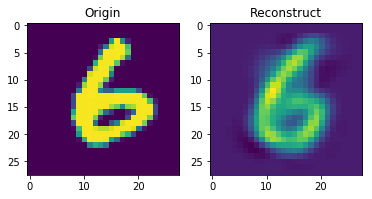

Validation loss = 35.851021(27.584903+8.266118), label=9


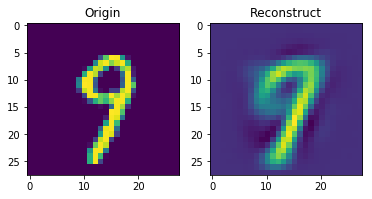

Testing loss = 35.736657(27.469772+8.266885), label=2


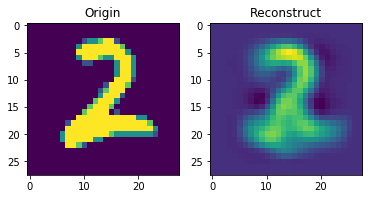

[Epoch 126] 16:09:36
[iteration 100]loss=39.341007(30.473038+8.867970)
[iteration 200]loss=34.730751(26.548746+8.182007)
[iteration 300]loss=38.351307(29.941700+8.409607)
[iteration 400]loss=38.065945(29.641348+8.424598)
[iteration 500]loss=37.335968(29.268532+8.067438)
[iteration 600]loss=38.216423(29.817457+8.398966)
[iteration 700]loss=36.349957(28.083542+8.266415)
[iteration 800]loss=37.213631(28.897818+8.315813)
Training loss = 35.929470(27.747213+8.182256), label=7


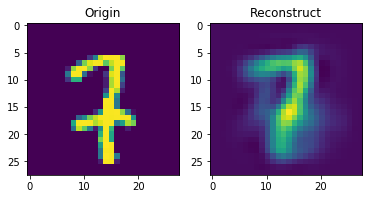

Validation loss = 35.557951(27.329809+8.228141), label=2


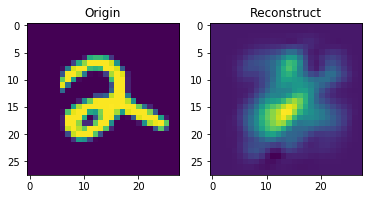

Testing loss = 35.796821(27.576667+8.220154), label=6


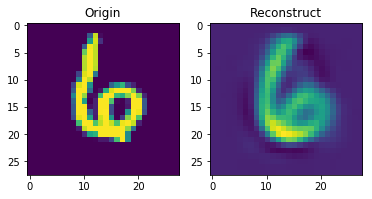

[Epoch 127] 16:09:40
[iteration 100]loss=36.292114(27.802128+8.489985)
[iteration 200]loss=37.740917(29.590733+8.150184)
[iteration 300]loss=36.201553(28.270664+7.930890)
[iteration 400]loss=37.729462(29.166245+8.563215)
[iteration 500]loss=37.614418(29.116287+8.498129)
[iteration 600]loss=36.032322(27.526308+8.506014)
[iteration 700]loss=36.528824(28.350964+8.177862)
[iteration 800]loss=36.279007(28.310749+7.968257)
Training loss = 35.929435(27.768993+8.160442), label=7


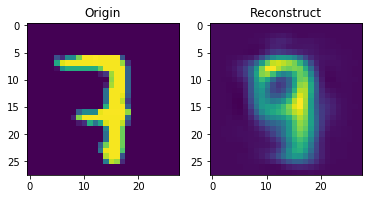

Validation loss = 35.662190(27.454542+8.207648), label=6


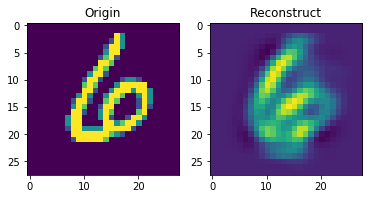

Testing loss = 35.890811(27.630160+8.260651), label=3


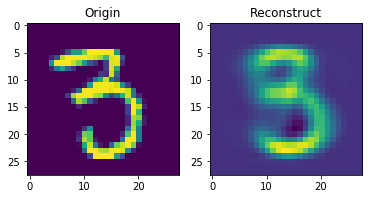

[Epoch 128] 16:09:45
[iteration 100]loss=38.713455(30.419506+8.293947)
[iteration 200]loss=33.704529(25.860628+7.843901)
[iteration 300]loss=36.130974(28.287703+7.843273)
[iteration 400]loss=39.483662(30.618519+8.865143)
[iteration 500]loss=37.423183(29.222240+8.200942)
[iteration 600]loss=35.605221(26.873491+8.731730)
[iteration 700]loss=37.822472(29.100647+8.721827)
[iteration 800]loss=37.544067(29.135006+8.409063)
Training loss = 35.940622(27.748609+8.192013), label=2


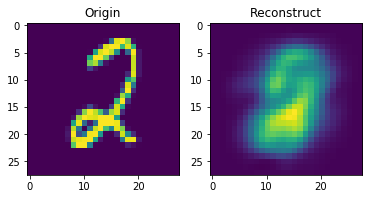

Validation loss = 35.743696(27.501895+8.241801), label=0


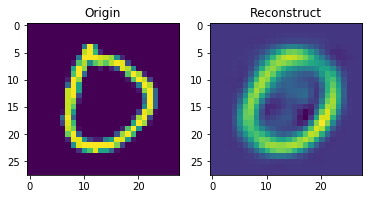

Testing loss = 35.661790(27.436519+8.225271), label=2


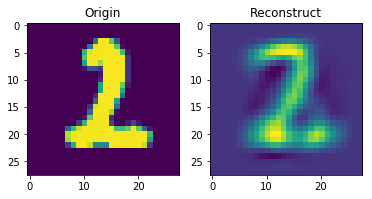

[Epoch 129] 16:09:49
[iteration 100]loss=36.007786(27.879528+8.128258)
[iteration 200]loss=36.611023(28.073959+8.537064)
[iteration 300]loss=38.928925(30.455976+8.472946)
[iteration 400]loss=36.967133(28.678871+8.288261)
[iteration 500]loss=38.776352(30.607796+8.168554)
[iteration 600]loss=38.715290(30.258915+8.456376)
[iteration 700]loss=38.990459(30.719723+8.270737)
[iteration 800]loss=37.075649(28.751122+8.324527)
Training loss = 35.884190(27.715465+8.168724), label=6


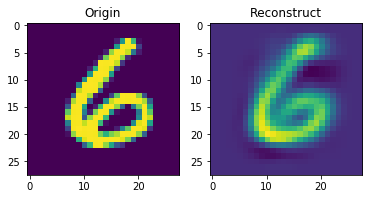

Validation loss = 35.824328(27.595408+8.228919), label=8


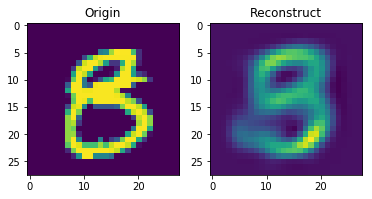

Testing loss = 35.883732(27.657093+8.226639), label=2


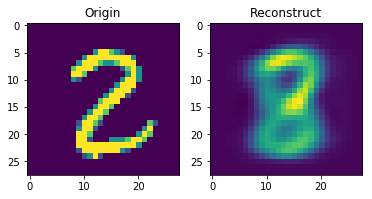

[Epoch 130] 16:09:54
[iteration 100]loss=36.647926(28.107143+8.540785)
[iteration 200]loss=35.049770(26.870712+8.179058)
[iteration 300]loss=36.655582(28.427235+8.228348)
[iteration 400]loss=36.039749(27.690254+8.349494)
[iteration 500]loss=38.043148(29.511200+8.531949)
[iteration 600]loss=36.515919(28.383312+8.132607)
[iteration 700]loss=37.299667(28.690653+8.609013)
[iteration 800]loss=37.573357(29.292490+8.280865)
Training loss = 35.910010(27.750799+8.159211), label=8


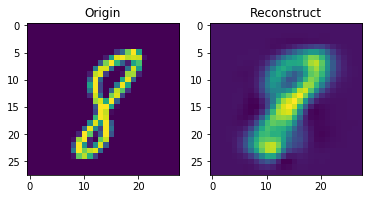

Validation loss = 35.617959(27.432574+8.185385), label=4


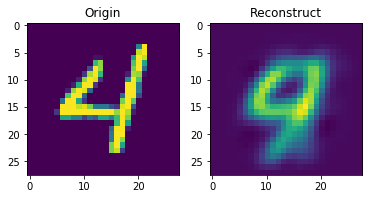

Testing loss = 35.727100(27.483586+8.243514), label=8


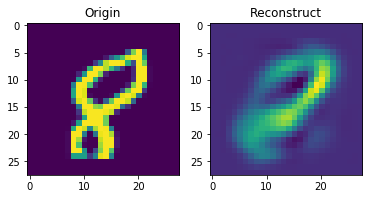

[Epoch 131] 16:09:58
[iteration 100]loss=35.424820(27.486380+7.938441)
[iteration 200]loss=37.984161(29.752600+8.231560)
[iteration 300]loss=36.266495(28.084553+8.181940)
[iteration 400]loss=39.339058(30.800289+8.538771)
[iteration 500]loss=38.630379(29.940346+8.690035)
[iteration 600]loss=35.899147(27.370050+8.529097)
[iteration 700]loss=37.984840(29.623777+8.361065)
[iteration 800]loss=36.257870(27.932461+8.325408)
Training loss = 35.928704(27.757891+8.170813), label=2


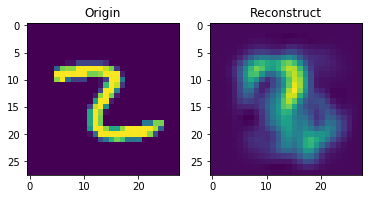

Validation loss = 35.733680(27.482791+8.250889), label=0


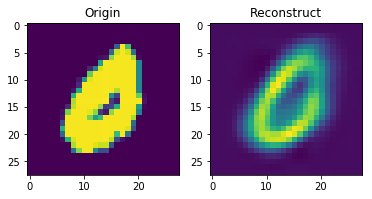

Testing loss = 35.755969(27.527853+8.228116), label=2


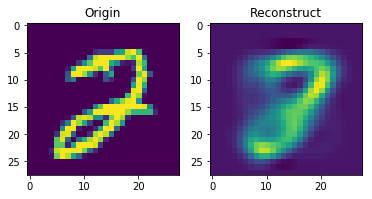

[Epoch 132] 16:10:02
[iteration 100]loss=37.844818(29.355907+8.488913)
[iteration 200]loss=37.358681(29.065166+8.293514)
[iteration 300]loss=36.456238(28.389256+8.066982)
[iteration 400]loss=39.956879(31.780378+8.176498)
[iteration 500]loss=36.894131(28.708324+8.185807)
[iteration 600]loss=38.386475(29.698532+8.687941)
[iteration 700]loss=37.101463(28.639692+8.461771)
[iteration 800]loss=35.811893(27.211210+8.600683)
Training loss = 35.901117(27.747107+8.154010), label=2


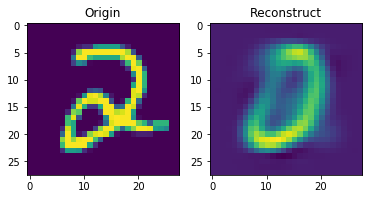

Validation loss = 35.668556(27.489844+8.178712), label=6


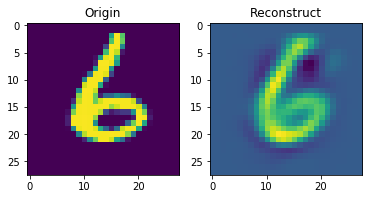

Testing loss = 35.757756(27.559800+8.197956), label=4


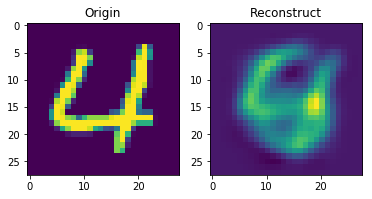

[Epoch 133] 16:10:07
[iteration 100]loss=37.200500(28.970106+8.230392)
[iteration 200]loss=39.293121(30.642155+8.650967)
[iteration 300]loss=38.412056(29.621529+8.790525)
[iteration 400]loss=39.476357(30.765251+8.711105)
[iteration 500]loss=36.787262(28.284821+8.502441)
[iteration 600]loss=38.940956(30.738106+8.202852)
[iteration 700]loss=36.296497(27.890409+8.406088)
[iteration 800]loss=35.583382(27.228855+8.354527)
Training loss = 35.944822(27.750283+8.194539), label=8


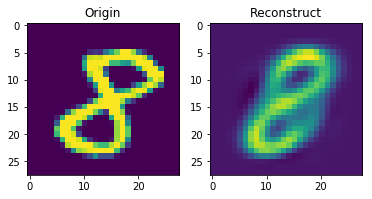

Validation loss = 35.546184(27.333194+8.212989), label=4


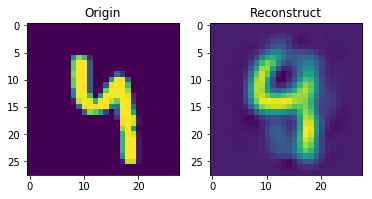

Testing loss = 35.791762(27.548338+8.243423), label=5


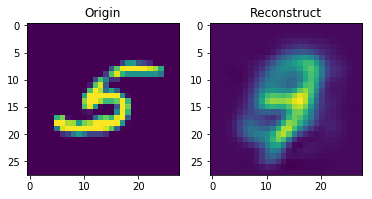

[Epoch 134] 16:10:11
[iteration 100]loss=34.435467(26.235846+8.199621)
[iteration 200]loss=38.273430(29.794931+8.478498)
[iteration 300]loss=39.587646(31.071228+8.516418)
[iteration 400]loss=38.338177(29.593191+8.744986)
[iteration 500]loss=36.690605(28.115395+8.575210)
[iteration 600]loss=36.031902(27.927155+8.104748)
[iteration 700]loss=37.624367(29.306150+8.318218)
[iteration 800]loss=39.038963(30.241558+8.797407)
Training loss = 35.974654(27.786201+8.188453), label=2


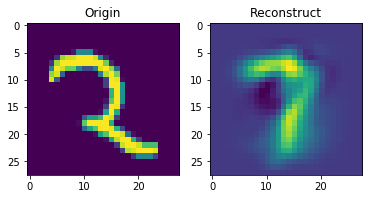

Validation loss = 35.707899(27.472421+8.235478), label=4


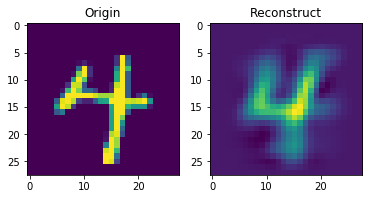

Testing loss = 35.842861(27.573950+8.268911), label=6


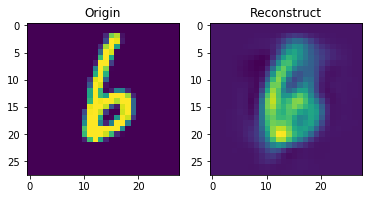

[Epoch 135] 16:10:16
[iteration 100]loss=38.361252(29.383558+8.977695)
[iteration 200]loss=39.049500(30.828526+8.220976)
[iteration 300]loss=38.306278(30.063755+8.242524)
[iteration 400]loss=35.614441(27.253685+8.360756)
[iteration 500]loss=38.510010(29.938402+8.571608)
[iteration 600]loss=36.569542(28.365416+8.204124)
[iteration 700]loss=36.170059(28.199589+7.970470)
[iteration 800]loss=38.148315(29.772896+8.375418)
Training loss = 35.949111(27.774828+8.174284), label=9


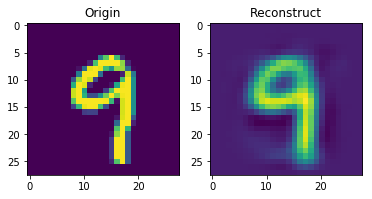

Validation loss = 35.660956(27.433482+8.227474), label=1


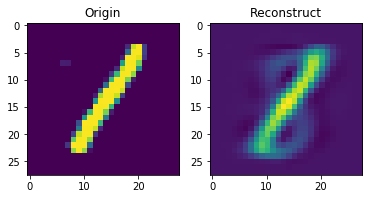

Testing loss = 35.715100(27.513636+8.201465), label=9


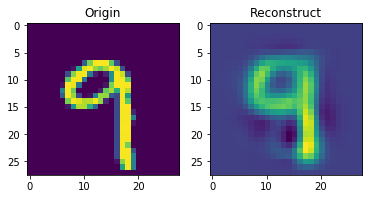

[Epoch 136] 16:10:20
[iteration 100]loss=37.447563(28.980391+8.467175)
[iteration 200]loss=38.544334(29.958544+8.585791)
[iteration 300]loss=38.654289(30.379847+8.274445)
[iteration 400]loss=35.786152(27.629011+8.157140)
[iteration 500]loss=35.217690(26.886522+8.331167)
[iteration 600]loss=37.581886(29.382925+8.198960)
[iteration 700]loss=36.138199(27.663618+8.474582)
[iteration 800]loss=37.085533(29.035789+8.049742)
Training loss = 35.939689(27.775642+8.164047), label=3


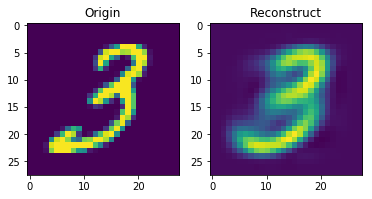

Validation loss = 35.464444(27.253394+8.211050), label=4


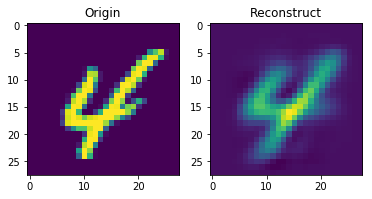

Testing loss = 35.743243(27.503234+8.240009), label=5


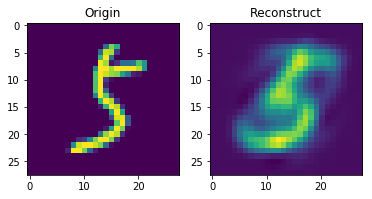

[Epoch 137] 16:10:25
[iteration 100]loss=37.831528(29.425247+8.406281)
[iteration 200]loss=37.449608(28.912991+8.536617)
[iteration 300]loss=36.862751(28.557528+8.305223)
[iteration 400]loss=38.898804(30.260475+8.638329)
[iteration 500]loss=38.056435(29.268333+8.788099)
[iteration 600]loss=38.637047(30.214638+8.422410)
[iteration 700]loss=38.058735(29.737988+8.320747)
[iteration 800]loss=35.235577(27.399748+7.835830)
Training loss = 35.873089(27.708893+8.164196), label=4


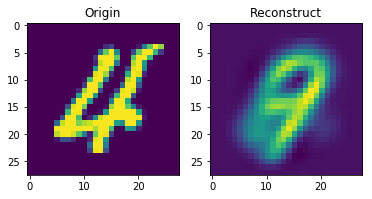

Validation loss = 35.856888(27.659264+8.197623), label=6


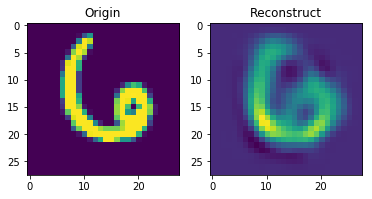

Testing loss = 35.694106(27.469893+8.224213), label=5


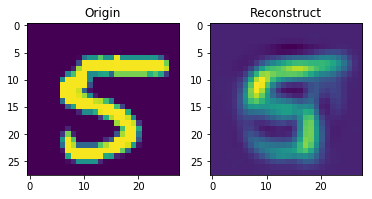

[Epoch 138] 16:10:30
[iteration 100]loss=36.359386(27.962555+8.396832)
[iteration 200]loss=37.401062(29.129766+8.271294)
[iteration 300]loss=37.231392(28.765980+8.465410)
[iteration 400]loss=38.054169(29.599888+8.454283)
[iteration 500]loss=35.101261(26.959370+8.141891)
[iteration 600]loss=38.965569(30.014406+8.951163)
[iteration 700]loss=37.807468(29.066929+8.740540)
[iteration 800]loss=36.338566(28.466785+7.871780)
Training loss = 35.883196(27.680604+8.202592), label=9


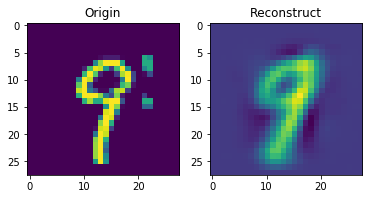

Validation loss = 35.592151(27.343829+8.248322), label=5


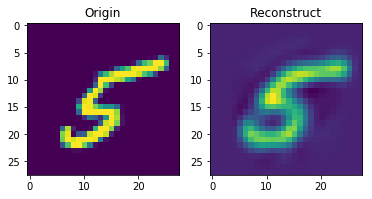

Testing loss = 35.684132(27.437667+8.246465), label=9


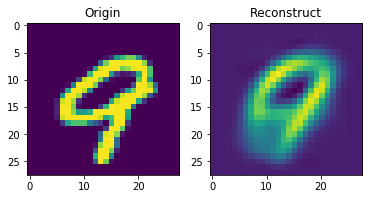

[Epoch 139] 16:10:35
[iteration 100]loss=37.772396(29.661314+8.111082)
[iteration 200]loss=38.102165(29.715267+8.386896)
[iteration 300]loss=36.171093(28.391729+7.779363)
[iteration 400]loss=37.772278(29.313175+8.459103)
[iteration 500]loss=40.586384(31.560677+9.025707)
[iteration 600]loss=38.389442(29.518669+8.870771)
[iteration 700]loss=35.711601(27.365402+8.346201)
[iteration 800]loss=37.537872(29.233696+8.304174)
Training loss = 35.953080(27.810664+8.142416), label=1


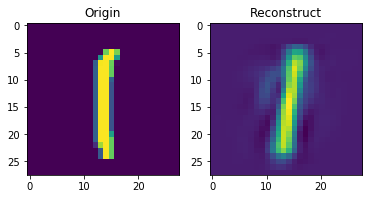

Validation loss = 35.704154(27.498028+8.206125), label=8


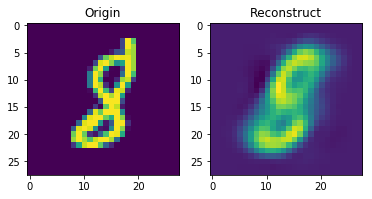

Testing loss = 35.886315(27.668539+8.217777), label=4


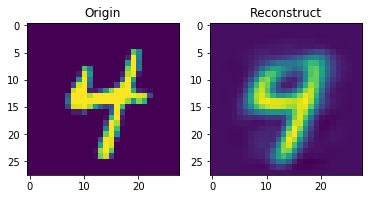

[Epoch 140] 16:10:40
[iteration 100]loss=37.069748(28.587004+8.482746)
[iteration 200]loss=35.936867(27.696384+8.240484)
[iteration 300]loss=36.399780(28.290867+8.108912)
[iteration 400]loss=37.411037(29.348669+8.062367)
[iteration 500]loss=36.225941(28.065838+8.160102)
[iteration 600]loss=35.334694(26.751339+8.583353)
[iteration 700]loss=36.883564(28.361500+8.522064)
[iteration 800]loss=37.674889(29.386257+8.288633)
Training loss = 35.858652(27.694009+8.164643), label=3


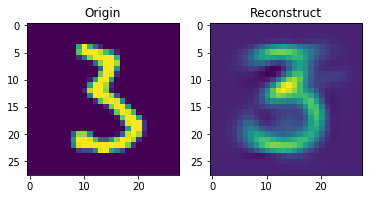

Validation loss = 35.754263(27.546102+8.208160), label=2


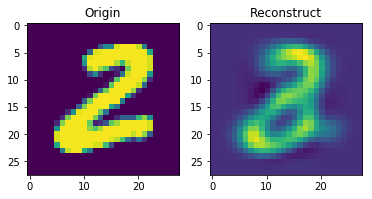

Testing loss = 35.741233(27.519553+8.221680), label=5


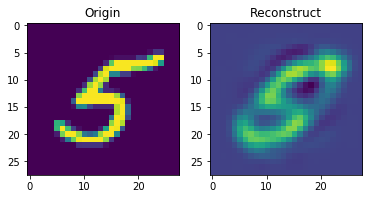

[Epoch 141] 16:10:45
[iteration 100]loss=38.836571(30.386478+8.450092)
[iteration 200]loss=36.247833(28.238693+8.009142)
[iteration 300]loss=36.547878(28.038725+8.509154)
[iteration 400]loss=38.372295(29.885130+8.487164)
[iteration 500]loss=37.782143(29.170738+8.611404)
[iteration 600]loss=37.815445(29.591242+8.224204)
[iteration 700]loss=39.807739(31.317204+8.490538)
[iteration 800]loss=35.259174(26.748241+8.510933)
Training loss = 35.925732(27.753667+8.172065), label=5


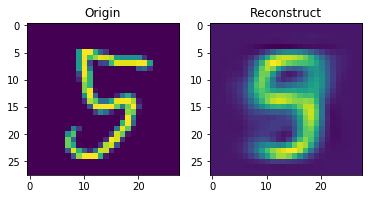

Validation loss = 35.653692(27.430583+8.223109), label=4


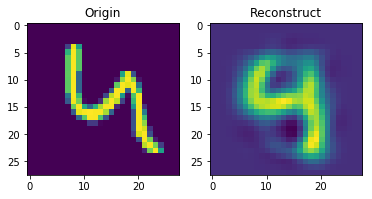

Testing loss = 35.826145(27.562898+8.263247), label=8


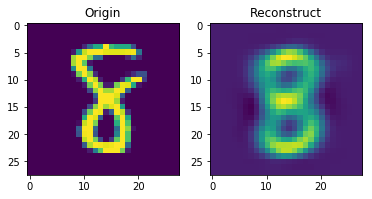

[Epoch 142] 16:10:50
[iteration 100]loss=39.127071(30.492085+8.634988)
[iteration 200]loss=36.006020(28.041359+7.964660)
[iteration 300]loss=37.395416(28.869144+8.526272)
[iteration 400]loss=37.174587(28.803436+8.371151)
[iteration 500]loss=37.522278(29.087317+8.434961)
[iteration 600]loss=35.410942(27.224850+8.186092)
[iteration 700]loss=36.905998(27.738535+9.167462)
[iteration 800]loss=36.050621(27.654404+8.396215)
Training loss = 35.933277(27.786818+8.146459), label=1


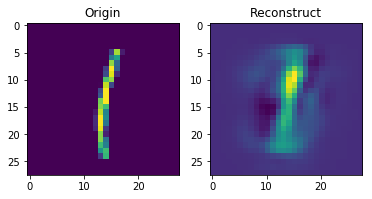

Validation loss = 35.573276(27.401781+8.171495), label=4


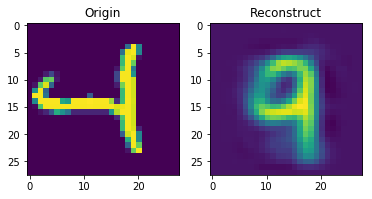

Testing loss = 35.689146(27.508471+8.180675), label=2


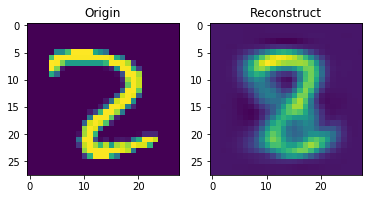

[Epoch 143] 16:10:54
[iteration 100]loss=36.246082(28.036745+8.209338)
[iteration 200]loss=36.216248(27.896015+8.320233)
[iteration 300]loss=37.249573(28.574587+8.674988)
[iteration 400]loss=37.501240(29.517998+7.983241)
[iteration 500]loss=37.874306(30.053207+7.821099)
[iteration 600]loss=37.305786(28.846542+8.459244)
[iteration 700]loss=36.986454(28.519363+8.467091)
[iteration 800]loss=37.714310(29.612881+8.101427)
Training loss = 35.819585(27.656934+8.162650), label=3


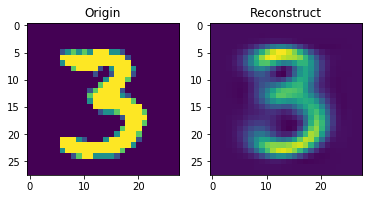

Validation loss = 35.704713(27.454082+8.250631), label=0


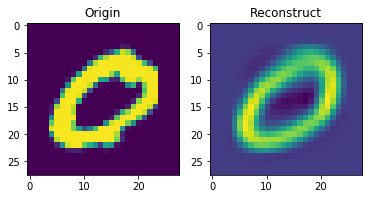

Testing loss = 35.768887(27.515041+8.253846), label=3


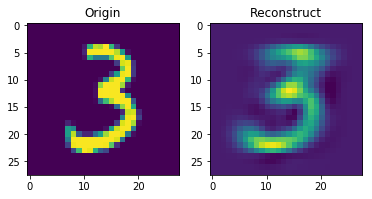

[Epoch 144] 16:10:59
[iteration 100]loss=36.579845(28.876369+7.703475)
[iteration 200]loss=38.651962(29.533924+9.118040)
[iteration 300]loss=35.626171(26.377327+9.248844)
[iteration 400]loss=37.434532(29.823380+7.611152)
[iteration 500]loss=38.746254(30.195381+8.550875)
[iteration 600]loss=36.544579(27.941517+8.603064)
[iteration 700]loss=38.630577(30.294884+8.335693)
[iteration 800]loss=34.721905(25.944975+8.776929)
Training loss = 35.855235(27.686844+8.168391), label=1


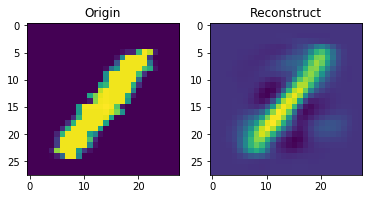

Validation loss = 35.600633(27.395047+8.205587), label=9


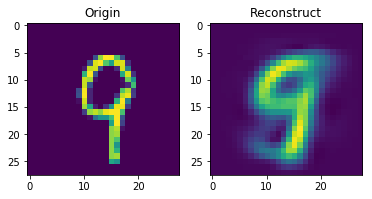

Testing loss = 35.740189(27.520480+8.219709), label=8


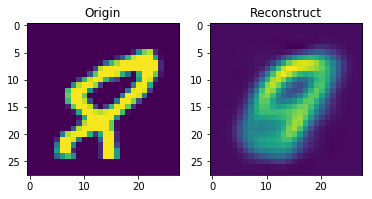

[Epoch 145] 16:11:03
[iteration 100]loss=37.790474(29.433556+8.356917)
[iteration 200]loss=39.368553(30.783850+8.584702)
[iteration 300]loss=34.692535(27.078815+7.613720)
[iteration 400]loss=37.875450(29.533752+8.341700)
[iteration 500]loss=37.896805(29.652176+8.244627)
[iteration 600]loss=38.417850(30.080582+8.337269)
[iteration 700]loss=38.522564(30.241650+8.280915)
[iteration 800]loss=37.917583(29.201111+8.716473)
Training loss = 35.911166(27.736047+8.175119), label=7


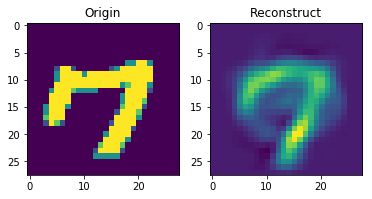

Validation loss = 35.616705(27.401487+8.215218), label=5


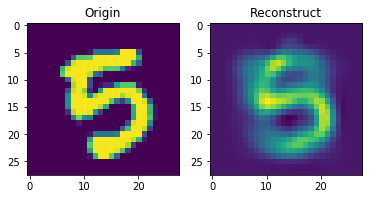

Testing loss = 35.748025(27.553963+8.194062), label=9


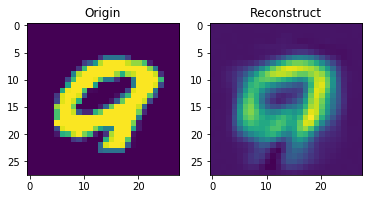

[Epoch 146] 16:11:08
[iteration 100]loss=37.730324(29.319521+8.410803)
[iteration 200]loss=35.410439(26.744690+8.665751)
[iteration 300]loss=37.533581(29.129814+8.403767)
[iteration 400]loss=37.017464(29.325012+7.692452)
[iteration 500]loss=36.277950(27.796078+8.481872)
[iteration 600]loss=36.097824(27.322468+8.775356)
[iteration 700]loss=37.748161(29.528103+8.220060)
[iteration 800]loss=35.126274(27.098728+8.027548)
Training loss = 35.928197(27.730717+8.197480), label=9


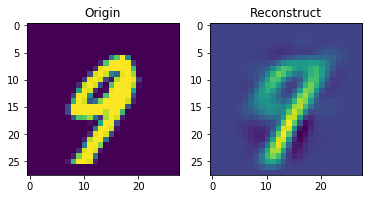

Validation loss = 35.757248(27.521100+8.236149), label=4


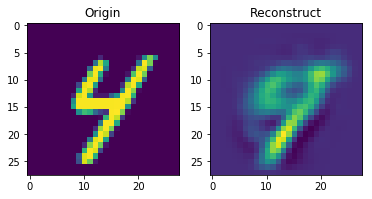

Testing loss = 35.730673(27.448966+8.281706), label=2


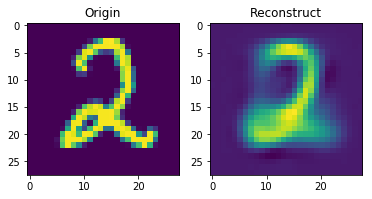

[Epoch 147] 16:11:12
[iteration 100]loss=37.698975(29.562748+8.136228)
[iteration 200]loss=37.636101(29.086964+8.549139)
[iteration 300]loss=37.028770(28.419275+8.609497)
[iteration 400]loss=37.326889(28.637318+8.689569)
[iteration 500]loss=40.113968(31.325901+8.788067)
[iteration 600]loss=39.507774(31.381371+8.126404)
[iteration 700]loss=38.495056(30.070591+8.424464)
[iteration 800]loss=35.400745(27.321751+8.078994)
Training loss = 35.929364(27.734608+8.194756), label=6


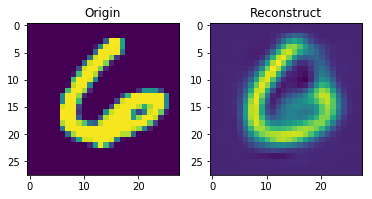

Validation loss = 35.531587(27.302900+8.228687), label=6


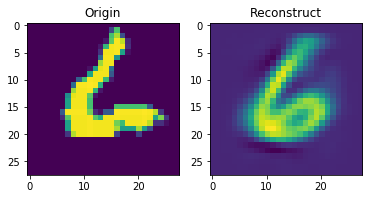

Testing loss = 35.774052(27.543971+8.230081), label=8


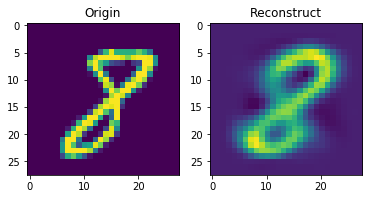

[Epoch 148] 16:11:17
[iteration 100]loss=37.799179(29.190042+8.609137)
[iteration 200]loss=38.579048(29.849388+8.729662)
[iteration 300]loss=38.490326(30.367472+8.122856)
[iteration 400]loss=38.453213(30.478979+7.974232)
[iteration 500]loss=38.116085(29.574707+8.541378)
[iteration 600]loss=33.759201(25.749931+8.009272)
[iteration 700]loss=38.935448(30.651409+8.284037)
[iteration 800]loss=37.429611(29.282993+8.146616)
Training loss = 35.924474(27.761360+8.163114), label=8


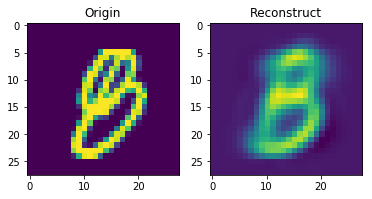

Validation loss = 35.766218(27.567783+8.198435), label=9


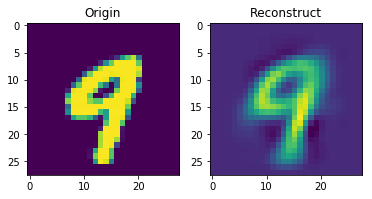

Testing loss = 35.823634(27.588648+8.234985), label=9


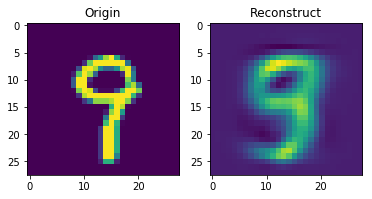

[Epoch 149] 16:11:22
[iteration 100]loss=38.761108(29.807529+8.953579)
[iteration 200]loss=38.257545(30.010361+8.247183)
[iteration 300]loss=37.620255(29.029259+8.590998)
[iteration 400]loss=37.205845(28.490835+8.715009)
[iteration 500]loss=36.879780(28.980978+7.898802)
[iteration 600]loss=37.771282(29.435356+8.335926)
[iteration 700]loss=37.459274(29.216364+8.242910)
[iteration 800]loss=37.519398(29.416084+8.103313)
Training loss = 35.928583(27.766458+8.162126), label=2


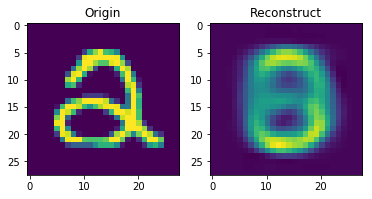

Validation loss = 35.601193(27.393028+8.208165), label=4


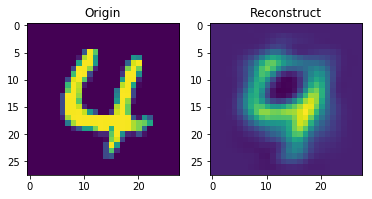

Testing loss = 35.777826(27.561701+8.216125), label=5


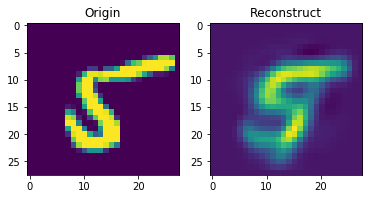

[Epoch 150] 16:11:27
[iteration 100]loss=38.370441(29.739698+8.630742)
[iteration 200]loss=37.598434(28.752537+8.845896)
[iteration 300]loss=39.617027(31.196800+8.420229)
[iteration 400]loss=37.062653(28.976107+8.086547)
[iteration 500]loss=37.078377(28.749891+8.328484)
[iteration 600]loss=37.468903(29.072378+8.396526)
[iteration 700]loss=39.529552(30.720436+8.809117)
[iteration 800]loss=36.224289(28.227224+7.997063)
Training loss = 35.931861(27.756333+8.175528), label=4


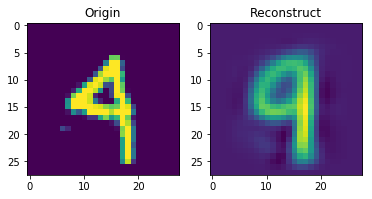

Validation loss = 35.668046(27.447238+8.220808), label=5


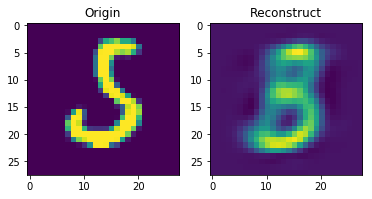

Testing loss = 35.890031(27.678310+8.211721), label=7


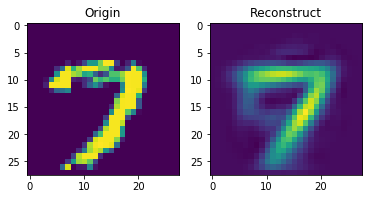

[Epoch 151] 16:11:32
[iteration 100]loss=39.309124(30.741518+8.567606)
[iteration 200]loss=40.395565(30.911152+9.484413)
[iteration 300]loss=38.938023(30.661642+8.276381)
[iteration 400]loss=34.981049(27.193724+7.787325)
[iteration 500]loss=38.612717(30.391657+8.221058)
[iteration 600]loss=34.469028(25.538301+8.930728)
[iteration 700]loss=37.716801(28.745705+8.971097)
[iteration 800]loss=39.171577(30.085314+9.086265)
Training loss = 35.900037(27.750837+8.149200), label=0


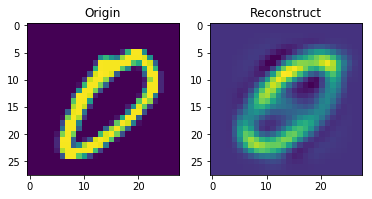

Validation loss = 35.586772(27.387854+8.198917), label=1


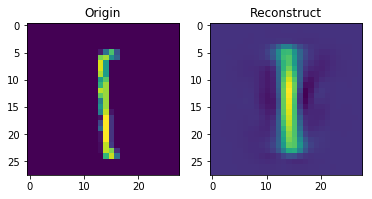

Testing loss = 35.669208(27.439593+8.229616), label=0


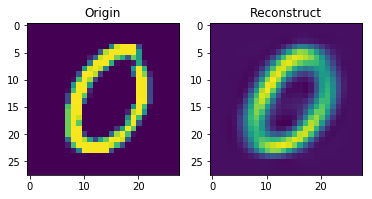

[Epoch 152] 16:11:36
[iteration 100]loss=39.220280(30.533009+8.687271)
[iteration 200]loss=35.731293(27.690302+8.040990)
[iteration 300]loss=38.292728(29.537792+8.754936)
[iteration 400]loss=37.126434(28.484184+8.642250)
[iteration 500]loss=37.741978(29.042704+8.699273)
[iteration 600]loss=35.952751(27.896355+8.056398)
[iteration 700]loss=36.960804(28.862251+8.098553)
[iteration 800]loss=35.038155(27.230633+7.807521)
Training loss = 35.891466(27.717778+8.173688), label=5


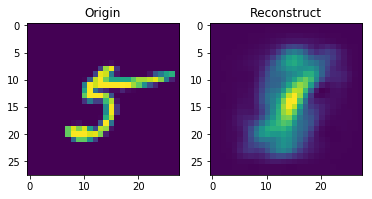

Validation loss = 35.634528(27.403106+8.231421), label=9


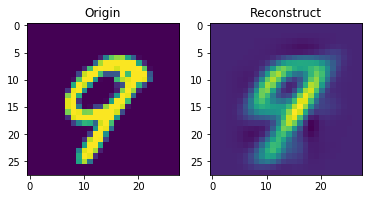

Testing loss = 35.853312(27.622226+8.231086), label=1


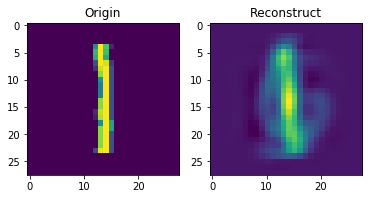

[Epoch 153] 16:11:41
[iteration 100]loss=37.338860(29.197054+8.141805)
[iteration 200]loss=38.806610(30.097166+8.709442)
[iteration 300]loss=40.141525(31.442661+8.698864)
[iteration 400]loss=38.867058(30.203110+8.663947)
[iteration 500]loss=39.616688(31.335850+8.280838)
[iteration 600]loss=37.162743(29.075943+8.086800)
[iteration 700]loss=37.196812(29.206104+7.990706)
[iteration 800]loss=33.869160(26.071226+7.797933)
Training loss = 35.922468(27.746210+8.176258), label=3


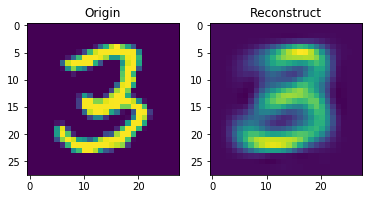

Validation loss = 35.681524(27.479981+8.201543), label=2


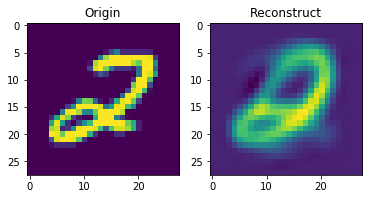

Testing loss = 35.587522(27.350729+8.236793), label=2


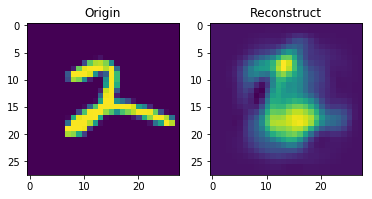

[Epoch 154] 16:11:45
[iteration 100]loss=37.825974(29.867432+7.958543)
[iteration 200]loss=38.564648(29.454372+9.110275)
[iteration 300]loss=37.227448(28.929417+8.298031)
[iteration 400]loss=37.796890(28.479597+9.317294)
[iteration 500]loss=38.122055(29.564365+8.557690)
[iteration 600]loss=35.584877(27.472301+8.112575)
[iteration 700]loss=36.837158(28.848822+7.988337)
[iteration 800]loss=38.915466(30.550373+8.365092)
Training loss = 35.873140(27.711359+8.161782), label=8


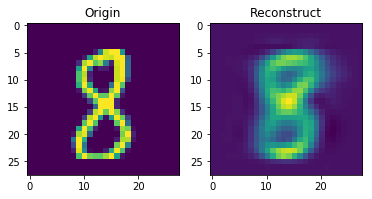

Validation loss = 35.514384(27.278016+8.236369), label=7


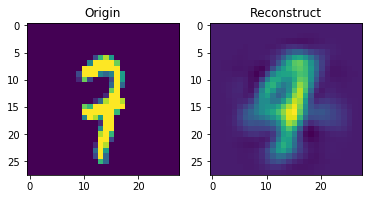

Testing loss = 35.827114(27.593337+8.233777), label=0


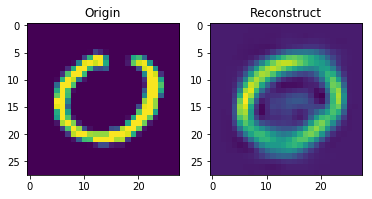

[Epoch 155] 16:11:50
[iteration 100]loss=37.595032(29.362932+8.232101)
[iteration 200]loss=38.451313(29.914284+8.537029)
[iteration 300]loss=35.924023(27.970222+7.953800)
[iteration 400]loss=38.560154(30.011673+8.548481)
[iteration 500]loss=37.286499(28.236855+9.049644)
[iteration 600]loss=38.290588(30.189848+8.100741)
[iteration 700]loss=34.525311(25.960075+8.565235)
[iteration 800]loss=38.078110(29.336063+8.742046)
Training loss = 35.794404(27.623422+8.170982), label=3


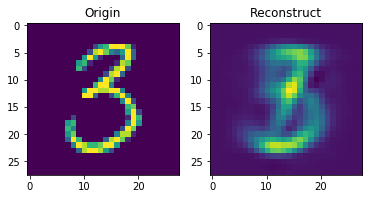

Validation loss = 35.692479(27.470277+8.222202), label=7


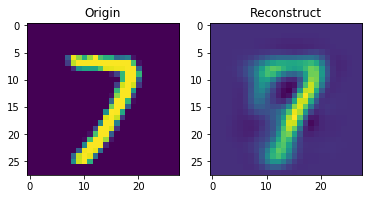

Testing loss = 35.759210(27.518196+8.241014), label=1


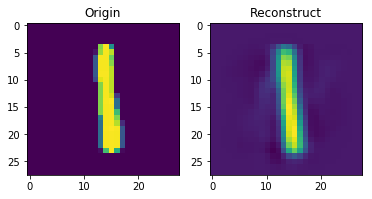

[Epoch 156] 16:11:54
[iteration 100]loss=38.491501(30.212673+8.278830)
[iteration 200]loss=35.405029(27.367714+8.037317)
[iteration 300]loss=37.008736(29.045271+7.963465)
[iteration 400]loss=34.961319(26.793898+8.167419)
[iteration 500]loss=39.920021(31.131386+8.788633)
[iteration 600]loss=38.593067(29.743210+8.849857)
[iteration 700]loss=36.622749(28.575424+8.047327)
[iteration 800]loss=35.805611(28.076874+7.728738)
Training loss = 35.911849(27.727542+8.184307), label=9


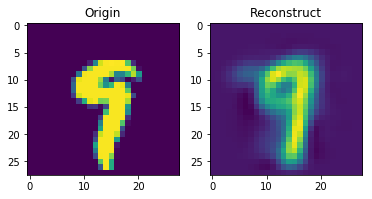

Validation loss = 35.597137(27.399010+8.198126), label=0


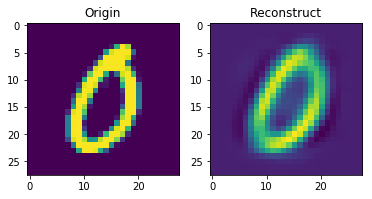

Testing loss = 35.677759(27.447633+8.230126), label=3


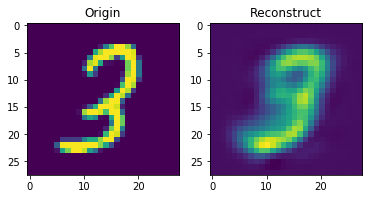

[Epoch 157] 16:11:59
[iteration 100]loss=37.474197(28.745739+8.728456)
[iteration 200]loss=37.368916(28.549076+8.819839)
[iteration 300]loss=37.309158(28.800508+8.508652)
[iteration 400]loss=34.657509(26.937429+7.720080)
[iteration 500]loss=37.462738(29.033247+8.429489)
[iteration 600]loss=35.130482(26.803307+8.327174)
[iteration 700]loss=39.417374(31.130472+8.286902)
[iteration 800]loss=38.904495(30.479263+8.425230)
Training loss = 35.918341(27.749128+8.169213), label=5


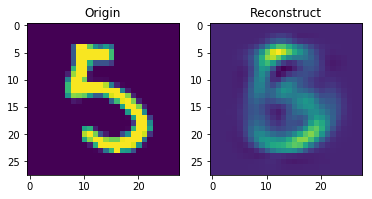

Validation loss = 35.441129(27.244966+8.196163), label=1


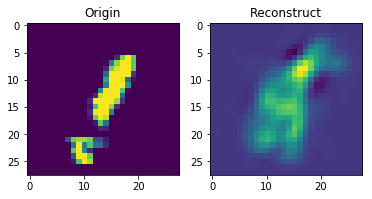

Testing loss = 35.739009(27.493996+8.245013), label=7


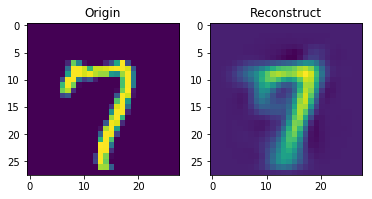

[Epoch 158] 16:12:03
[iteration 100]loss=36.557129(28.549902+8.007225)
[iteration 200]loss=38.422981(30.168566+8.254416)
[iteration 300]loss=39.133522(30.186859+8.946661)
[iteration 400]loss=35.656792(27.549564+8.107225)
[iteration 500]loss=35.259830(26.643051+8.616779)
[iteration 600]loss=37.254562(29.230804+8.023759)
[iteration 700]loss=36.248821(27.730270+8.518551)
[iteration 800]loss=39.377083(30.932840+8.444241)
Training loss = 35.908719(27.735498+8.173220), label=1


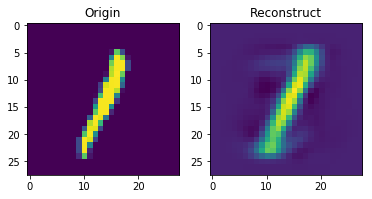

Validation loss = 35.739947(27.499228+8.240720), label=2


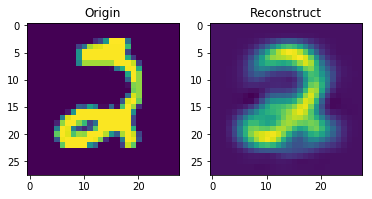

Testing loss = 35.752195(27.530659+8.221537), label=9


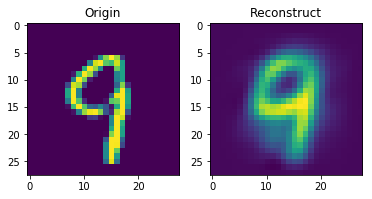

[Epoch 159] 16:12:08
[iteration 100]loss=40.719929(32.010635+8.709292)
[iteration 200]loss=35.939430(27.604988+8.334441)
[iteration 300]loss=36.566849(27.869846+8.697002)
[iteration 400]loss=38.513786(29.871841+8.641946)
[iteration 500]loss=35.065750(26.788660+8.277090)
[iteration 600]loss=35.731541(27.794544+7.936996)
[iteration 700]loss=37.066418(28.821859+8.244559)
[iteration 800]loss=38.350338(30.112011+8.238327)
Training loss = 35.869538(27.719709+8.149829), label=1


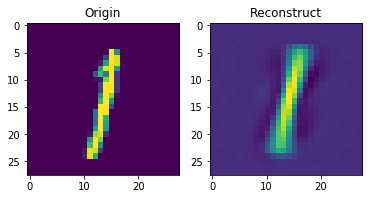

Validation loss = 35.760902(27.563095+8.197807), label=7


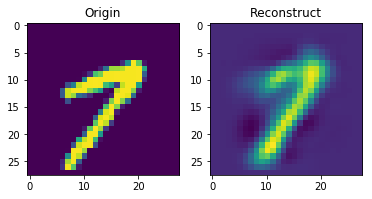

Testing loss = 35.757966(27.515605+8.242361), label=1


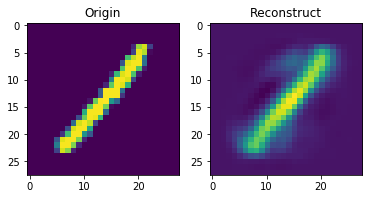

[Epoch 160] 16:12:12
[iteration 100]loss=39.949120(31.348217+8.600903)
[iteration 200]loss=37.558891(29.066572+8.492319)
[iteration 300]loss=36.851158(28.838097+8.013063)
[iteration 400]loss=36.406937(28.155603+8.251334)
[iteration 500]loss=35.403347(27.597324+7.806022)
[iteration 600]loss=36.720661(28.101967+8.618694)
[iteration 700]loss=37.358185(29.300669+8.057514)
[iteration 800]loss=38.323730(29.471313+8.852415)
Training loss = 35.868780(27.702673+8.166107), label=8


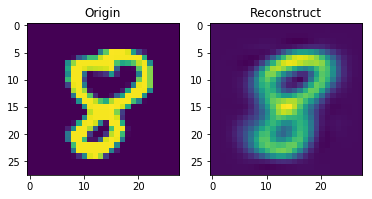

Validation loss = 35.706984(27.461373+8.245611), label=0


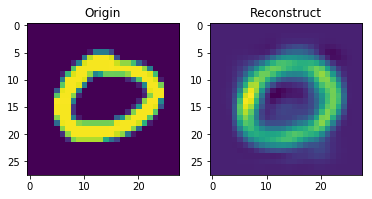

Testing loss = 35.620405(27.420810+8.199596), label=5


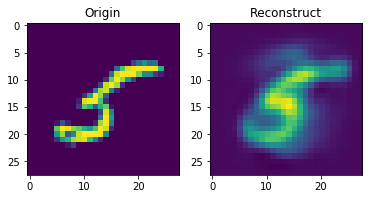

[Epoch 161] 16:12:17
[iteration 100]loss=38.651543(30.200466+8.451077)
[iteration 200]loss=36.649006(28.459105+8.189900)
[iteration 300]loss=39.097126(30.726234+8.370892)
[iteration 400]loss=37.040680(28.871389+8.169289)
[iteration 500]loss=34.621231(26.891544+7.729685)
[iteration 600]loss=39.376427(30.723515+8.652912)
[iteration 700]loss=38.113636(29.731976+8.381660)
[iteration 800]loss=35.441265(26.998867+8.442399)
Training loss = 35.893132(27.726956+8.166177), label=6


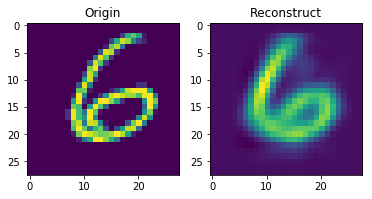

Validation loss = 35.406708(27.224515+8.182192), label=4


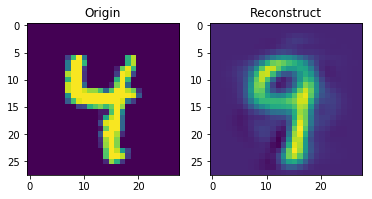

Testing loss = 35.877813(27.632164+8.245649), label=0


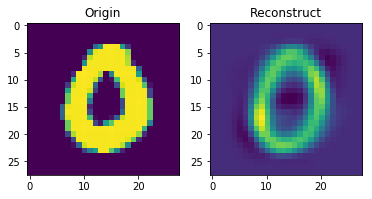

[Epoch 162] 16:12:21
[iteration 100]loss=37.900169(29.520208+8.379962)
[iteration 200]loss=35.677158(27.362328+8.314832)
[iteration 300]loss=38.880356(30.286032+8.594325)
[iteration 400]loss=37.199020(28.722015+8.477004)
[iteration 500]loss=36.641853(28.518368+8.123487)
[iteration 600]loss=39.585716(31.082201+8.503513)
[iteration 700]loss=36.825294(28.405838+8.419456)
[iteration 800]loss=36.650623(28.487734+8.162889)
Training loss = 35.926328(27.738165+8.188163), label=3


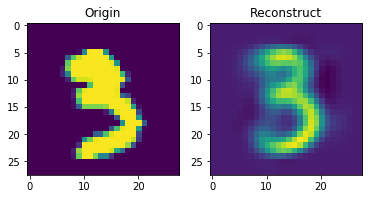

Validation loss = 35.861043(27.621093+8.239950), label=4


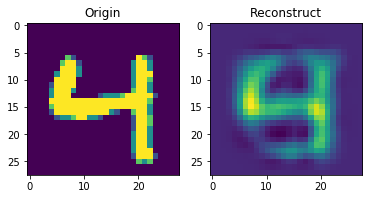

Testing loss = 35.781176(27.528846+8.252331), label=1


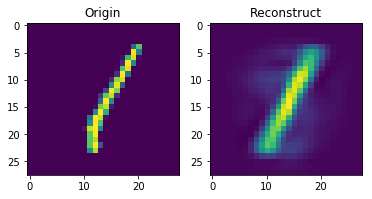

[Epoch 163] 16:12:26
[iteration 100]loss=35.162643(26.778208+8.384434)
[iteration 200]loss=36.117439(27.939018+8.178420)
[iteration 300]loss=36.145271(28.330139+7.815130)
[iteration 400]loss=37.470169(29.196056+8.274113)
[iteration 500]loss=37.716156(29.360497+8.355658)
[iteration 600]loss=39.087936(30.457191+8.630747)
[iteration 700]loss=37.426193(28.832081+8.594114)
[iteration 800]loss=37.628544(29.769966+7.858577)
Training loss = 35.868167(27.693816+8.174351), label=9


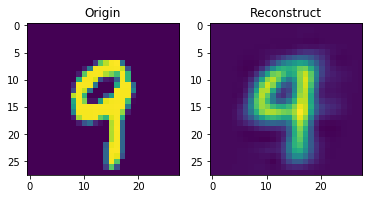

Validation loss = 35.636767(27.395006+8.241761), label=6


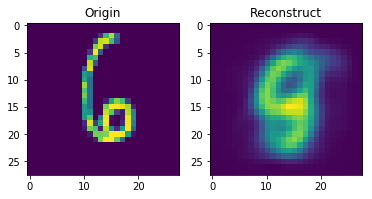

Testing loss = 35.659472(27.440783+8.218689), label=7


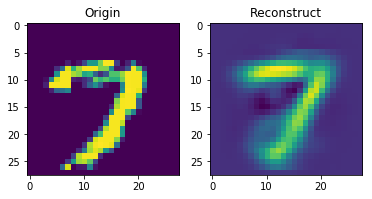

[Epoch 164] 16:12:30
[iteration 100]loss=35.620979(27.440941+8.180037)
[iteration 200]loss=38.129456(29.670872+8.458582)
[iteration 300]loss=39.772724(31.275517+8.497208)
[iteration 400]loss=39.810890(31.734379+8.076513)
[iteration 500]loss=40.958073(32.395401+8.562672)
[iteration 600]loss=35.669636(27.156046+8.513590)
[iteration 700]loss=38.759998(30.210106+8.549893)
[iteration 800]loss=36.468929(27.860134+8.608795)
Training loss = 35.860422(27.688847+8.171575), label=4


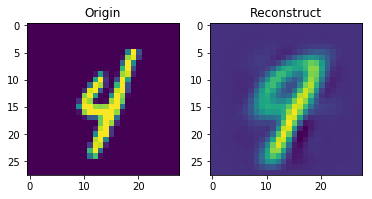

Validation loss = 35.535992(27.350347+8.185645), label=3


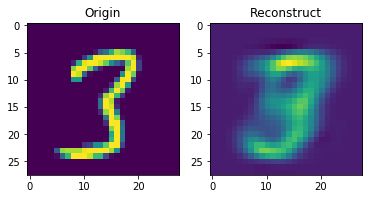

Testing loss = 35.870768(27.634630+8.236138), label=8


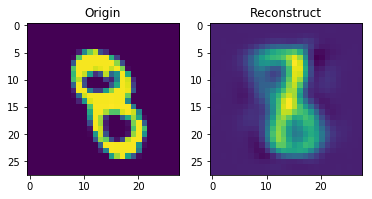

[Epoch 165] 16:12:35
[iteration 100]loss=36.816853(28.530733+8.286119)
[iteration 200]loss=40.297916(31.951097+8.346819)
[iteration 300]loss=37.335812(28.800995+8.534817)
[iteration 400]loss=37.213852(29.175646+8.038206)
[iteration 500]loss=35.891457(27.550053+8.341404)
[iteration 600]loss=36.885910(28.338297+8.547613)
[iteration 700]loss=38.660805(30.252464+8.408339)
[iteration 800]loss=37.053181(29.104614+7.948565)
Training loss = 35.948792(27.769057+8.179735), label=8


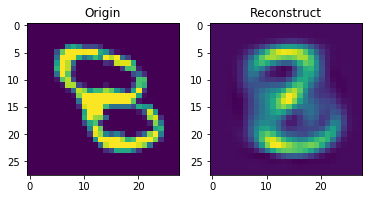

Validation loss = 35.559485(27.365961+8.193524), label=3


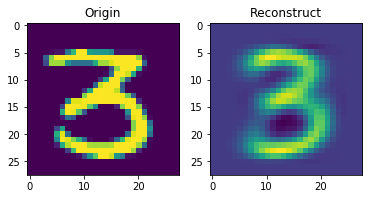

Testing loss = 35.684804(27.438548+8.246256), label=2


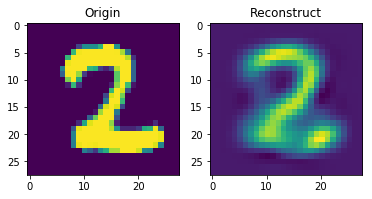

[Epoch 166] 16:12:39
[iteration 100]loss=34.953835(26.894775+8.059059)
[iteration 200]loss=36.491142(28.068541+8.422601)
[iteration 300]loss=37.694637(29.356916+8.337722)
[iteration 400]loss=42.370640(32.844498+9.526142)
[iteration 500]loss=35.118168(27.281536+7.836631)
[iteration 600]loss=40.531307(31.905313+8.625994)
[iteration 700]loss=36.168060(27.926891+8.241167)
[iteration 800]loss=37.365349(28.844248+8.521101)
Training loss = 35.901071(27.715377+8.185694), label=5


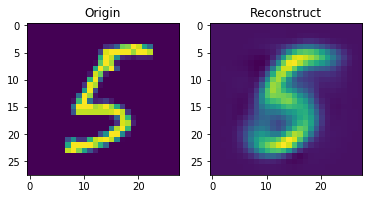

Validation loss = 35.798291(27.551674+8.246616), label=3


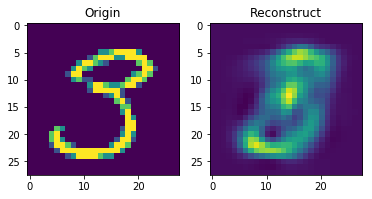

Testing loss = 35.741617(27.526031+8.215586), label=8


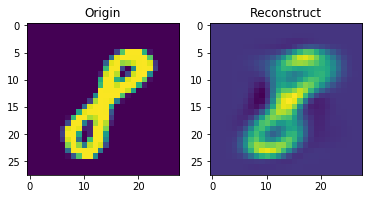

[Epoch 167] 16:12:43
[iteration 100]loss=37.630356(29.358120+8.272236)
[iteration 200]loss=37.084976(28.956718+8.128258)
[iteration 300]loss=37.078896(28.833260+8.245636)
[iteration 400]loss=36.431400(28.311428+8.119972)
[iteration 500]loss=37.749847(29.067986+8.681862)
[iteration 600]loss=34.576241(26.005322+8.570918)
[iteration 700]loss=37.029037(28.732183+8.296854)
[iteration 800]loss=35.134758(26.787058+8.347701)
Training loss = 35.959449(27.790450+8.168999), label=5


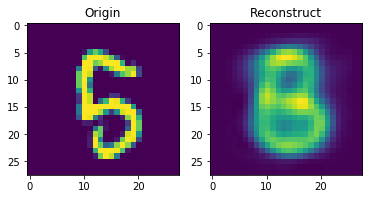

Validation loss = 35.524424(27.281446+8.242978), label=6


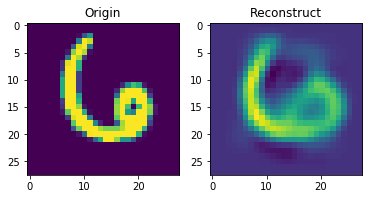

Testing loss = 35.809643(27.537134+8.272509), label=0


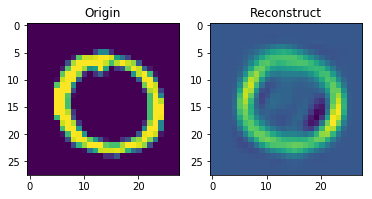

[Epoch 168] 16:12:48
[iteration 100]loss=38.599651(30.274609+8.325043)
[iteration 200]loss=37.199970(29.346056+7.853913)
[iteration 300]loss=38.605015(30.470345+8.134670)
[iteration 400]loss=35.922623(27.948151+7.974473)
[iteration 500]loss=36.083439(27.838093+8.245346)
[iteration 600]loss=41.211479(32.657429+8.554050)
[iteration 700]loss=40.555649(32.190838+8.364809)
[iteration 800]loss=38.273537(29.890186+8.383348)
Training loss = 35.910125(27.738997+8.171129), label=9


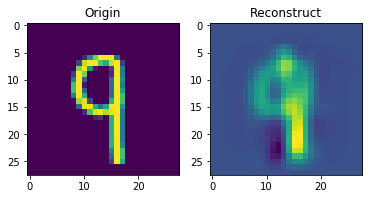

Validation loss = 35.771337(27.592891+8.178447), label=5


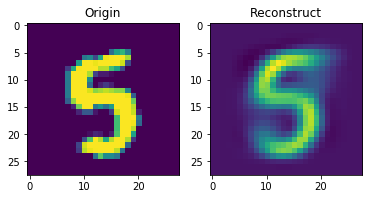

Testing loss = 35.637892(27.429720+8.208173), label=6


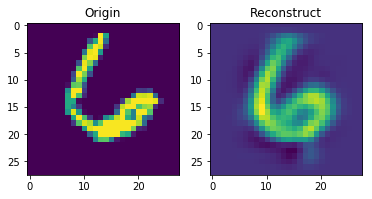

[Epoch 169] 16:12:52
[iteration 100]loss=37.248436(29.146280+8.102155)
[iteration 200]loss=37.765404(29.295177+8.470224)
[iteration 300]loss=36.332897(27.957424+8.375473)
[iteration 400]loss=34.959808(27.145115+7.814694)
[iteration 500]loss=36.083183(27.808981+8.274202)
[iteration 600]loss=39.919823(31.257841+8.661981)
[iteration 700]loss=36.535522(28.489635+8.045885)
[iteration 800]loss=37.126194(28.650871+8.475323)
Training loss = 35.885912(27.715483+8.170429), label=0


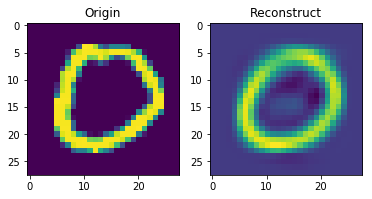

Validation loss = 35.566914(27.359730+8.207184), label=7


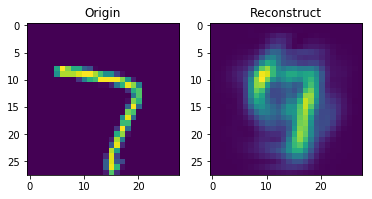

Testing loss = 35.740823(27.517181+8.223641), label=7


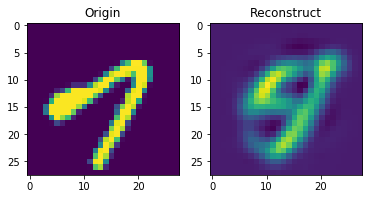

[Epoch 170] 16:12:57
[iteration 100]loss=35.718498(27.331228+8.387272)
[iteration 200]loss=37.711483(29.358824+8.352658)
[iteration 300]loss=37.074562(28.840218+8.234346)
[iteration 400]loss=36.639431(28.283306+8.356125)
[iteration 500]loss=40.217335(31.713831+8.503504)
[iteration 600]loss=35.351879(27.166811+8.185068)
[iteration 700]loss=38.152920(28.938171+9.214749)
[iteration 800]loss=36.045380(27.847433+8.197948)
Training loss = 35.886182(27.697934+8.188248), label=3


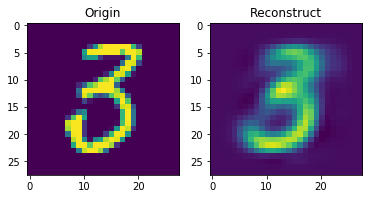

Validation loss = 35.695036(27.461975+8.233061), label=6


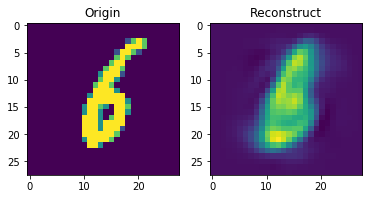

Testing loss = 35.878711(27.642653+8.236058), label=8


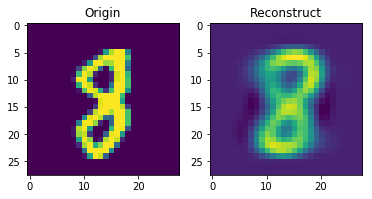

[Epoch 171] 16:13:01
[iteration 100]loss=36.753384(28.385109+8.368275)
[iteration 200]loss=37.449379(28.651073+8.798306)
[iteration 300]loss=38.398407(29.284817+9.113591)
[iteration 400]loss=35.366982(26.882133+8.484850)
[iteration 500]loss=34.235508(26.162960+8.072547)
[iteration 600]loss=38.272305(29.957180+8.315125)
[iteration 700]loss=37.071201(28.849537+8.221665)
[iteration 800]loss=35.871109(27.633648+8.237459)
Training loss = 35.876737(27.716319+8.160418), label=6


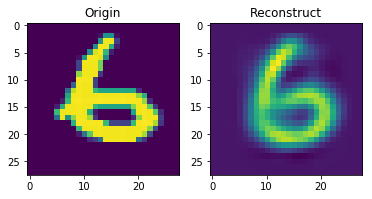

Validation loss = 35.569814(27.324476+8.245338), label=4


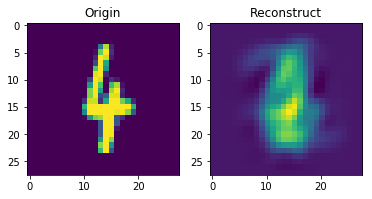

Testing loss = 35.694741(27.461669+8.233072), label=6


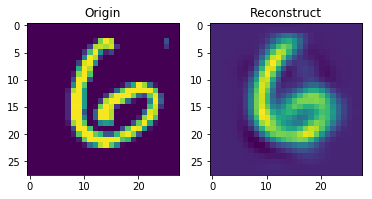

[Epoch 172] 16:13:06
[iteration 100]loss=35.505478(27.600473+7.905006)
[iteration 200]loss=35.445961(27.986855+7.459107)
[iteration 300]loss=37.181339(29.302816+7.878524)
[iteration 400]loss=38.935482(30.127178+8.808304)
[iteration 500]loss=40.119965(31.089706+9.030258)
[iteration 600]loss=37.159161(29.158175+8.000986)
[iteration 700]loss=35.694290(27.995747+7.698542)
[iteration 800]loss=38.546227(30.046211+8.500017)
Training loss = 35.874658(27.705277+8.169381), label=6


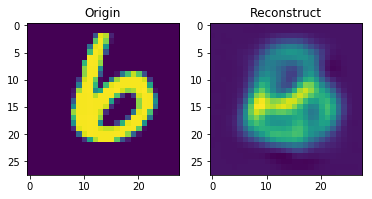

Validation loss = 35.546778(27.398429+8.148350), label=7


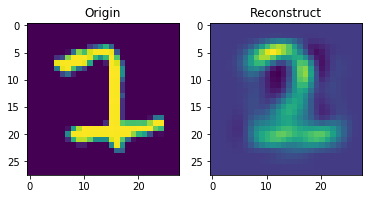

Testing loss = 35.586448(27.384216+8.202232), label=4


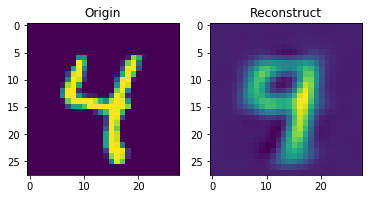

[Epoch 173] 16:13:10
[iteration 100]loss=37.467319(29.002655+8.464664)
[iteration 200]loss=38.651546(30.472494+8.179053)
[iteration 300]loss=38.040928(29.524099+8.516829)
[iteration 400]loss=37.235657(29.190681+8.044976)
[iteration 500]loss=38.633343(30.209511+8.423831)
[iteration 600]loss=36.140671(27.636274+8.504396)
[iteration 700]loss=38.414692(29.874090+8.540602)
[iteration 800]loss=35.353195(27.069691+8.283504)
Training loss = 35.901117(27.722446+8.178671), label=2


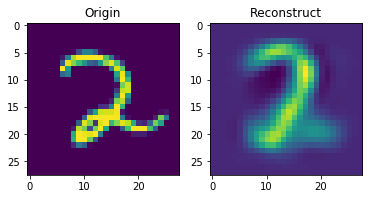

Validation loss = 35.703913(27.429277+8.274635), label=8


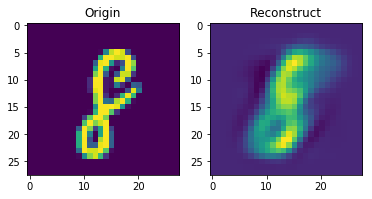

Testing loss = 35.834930(27.607209+8.227721), label=7


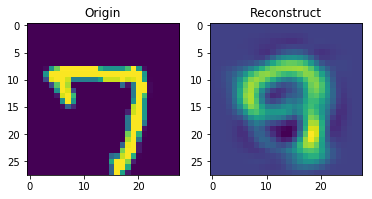

[Epoch 174] 16:13:14
[iteration 100]loss=38.890610(30.438335+8.452272)
[iteration 200]loss=36.710854(28.935139+7.775717)
[iteration 300]loss=38.694893(30.146633+8.548258)
[iteration 400]loss=35.405514(27.350664+8.054850)
[iteration 500]loss=36.141365(27.631287+8.510077)
[iteration 600]loss=39.415569(30.780170+8.635398)
[iteration 700]loss=36.974300(28.615194+8.359106)
[iteration 800]loss=34.880783(27.097942+7.782842)
Training loss = 35.944597(27.761514+8.183083), label=4


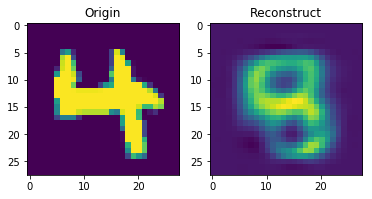

Validation loss = 35.654697(27.445964+8.208733), label=8


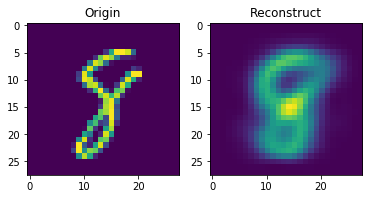

Testing loss = 35.657491(27.386721+8.270770), label=6


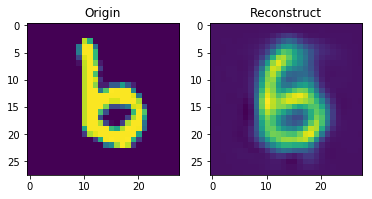

[Epoch 175] 16:13:19
[iteration 100]loss=38.187477(29.743265+8.444212)
[iteration 200]loss=37.625000(28.683262+8.941738)
[iteration 300]loss=39.560608(30.958309+8.602301)
[iteration 400]loss=38.450890(29.985279+8.465611)
[iteration 500]loss=40.074272(31.896236+8.178036)
[iteration 600]loss=35.046806(26.834515+8.212292)
[iteration 700]loss=35.946625(27.489986+8.456636)
[iteration 800]loss=37.733971(29.055309+8.678662)
Training loss = 35.861908(27.683463+8.178446), label=9


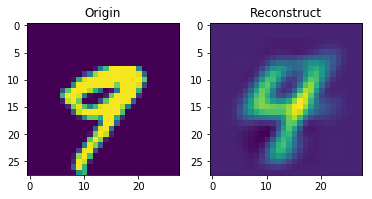

Validation loss = 35.640138(27.418781+8.221358), label=2


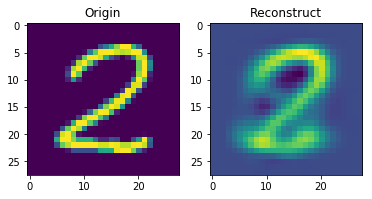

Testing loss = 35.838905(27.595993+8.242912), label=2


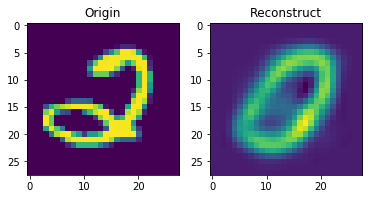

[Epoch 176] 16:13:24
[iteration 100]loss=38.710655(30.485540+8.225115)
[iteration 200]loss=37.781799(29.126446+8.655352)
[iteration 300]loss=38.941406(30.655609+8.285795)
[iteration 400]loss=37.623253(28.979666+8.643589)
[iteration 500]loss=36.312210(28.134192+8.178020)
[iteration 600]loss=37.293831(29.379208+7.914625)
[iteration 700]loss=35.924107(27.891487+8.032620)
[iteration 800]loss=35.240730(26.832870+8.407859)
Training loss = 35.876043(27.692685+8.183358), label=9


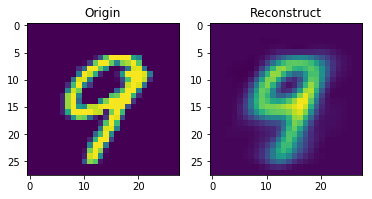

Validation loss = 35.705351(27.474381+8.230970), label=8


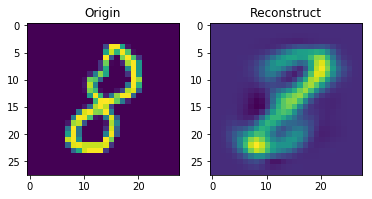

Testing loss = 35.617597(27.390443+8.227154), label=9


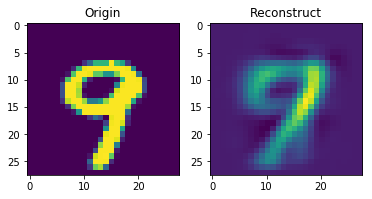

[Epoch 177] 16:13:28
[iteration 100]loss=36.194160(28.388344+7.805817)
[iteration 200]loss=38.443172(29.861893+8.581281)
[iteration 300]loss=37.381138(28.975294+8.405843)
[iteration 400]loss=37.089207(28.965664+8.123542)
[iteration 500]loss=40.006054(31.674404+8.331650)
[iteration 600]loss=35.932854(27.734528+8.198324)
[iteration 700]loss=37.071030(28.484413+8.586618)
[iteration 800]loss=37.253185(28.795044+8.458142)
Training loss = 35.905062(27.712871+8.192190), label=2


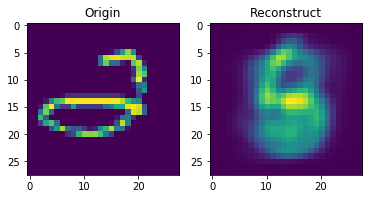

Validation loss = 35.560132(27.344751+8.215381), label=1


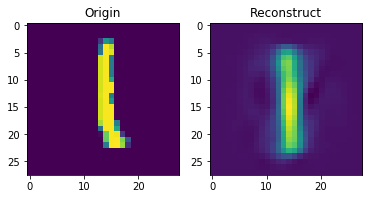

Testing loss = 35.767551(27.519172+8.248380), label=8


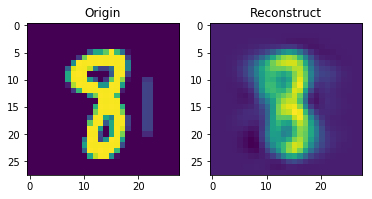

[Epoch 178] 16:13:33
[iteration 100]loss=39.765232(31.076319+8.688913)
[iteration 200]loss=36.538284(28.456276+8.082010)
[iteration 300]loss=39.054543(30.402739+8.651805)
[iteration 400]loss=37.976391(29.443264+8.533127)
[iteration 500]loss=38.210609(29.789467+8.421142)
[iteration 600]loss=35.583267(27.342510+8.240755)
[iteration 700]loss=37.868992(29.509659+8.359333)
[iteration 800]loss=37.019859(28.631634+8.388226)
Training loss = 35.930652(27.747309+8.183344), label=0


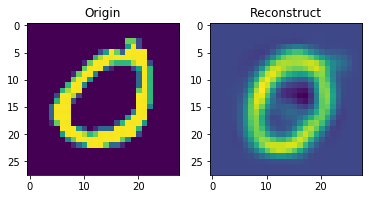

Validation loss = 35.567966(27.349249+8.218717), label=0


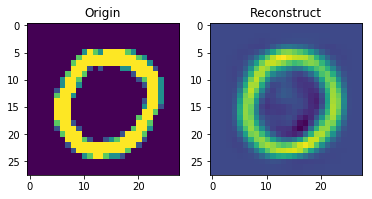

Testing loss = 35.938957(27.670920+8.268037), label=2


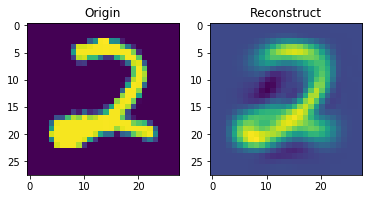

[Epoch 179] 16:13:37
[iteration 100]loss=36.882435(28.672960+8.209475)
[iteration 200]loss=39.178585(30.659662+8.518923)
[iteration 300]loss=38.279003(30.428497+7.850506)
[iteration 400]loss=39.466057(30.976841+8.489216)
[iteration 500]loss=38.718292(30.599287+8.119007)
[iteration 600]loss=36.246220(28.442310+7.803909)
[iteration 700]loss=36.957558(28.630711+8.326846)
[iteration 800]loss=35.910484(27.676552+8.233934)
Training loss = 35.859061(27.682791+8.176270), label=9


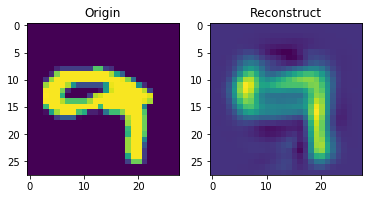

Validation loss = 35.506140(27.286045+8.220095), label=3


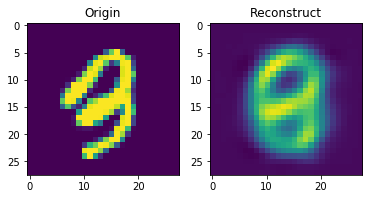

Testing loss = 35.777482(27.531064+8.246417), label=2


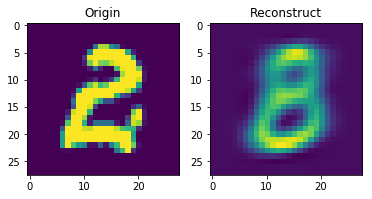

[Epoch 180] 16:13:42
[iteration 100]loss=39.113377(30.311579+8.801797)
[iteration 200]loss=37.045883(28.588249+8.457634)
[iteration 300]loss=37.015915(28.529205+8.486708)
[iteration 400]loss=34.982822(26.713455+8.269367)
[iteration 500]loss=38.783344(30.841764+7.941581)
[iteration 600]loss=39.686100(31.313532+8.372569)
[iteration 700]loss=37.295204(29.266417+8.028790)
[iteration 800]loss=38.166416(29.472397+8.694019)
Training loss = 35.922216(27.740178+8.182038), label=2


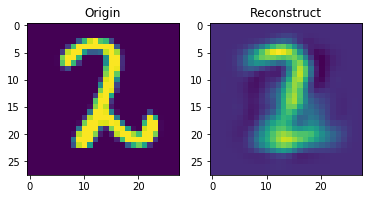

Validation loss = 35.707425(27.456858+8.250567), label=5


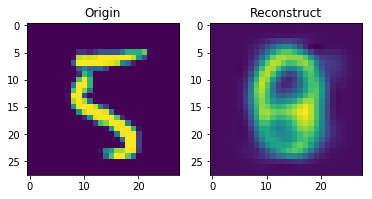

Testing loss = 35.566299(27.336175+8.230123), label=0


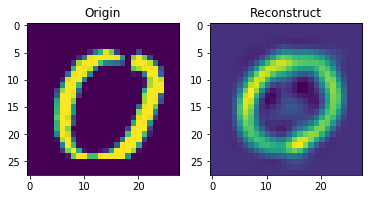

[Epoch 181] 16:13:46
[iteration 100]loss=39.809155(31.669136+8.140019)
[iteration 200]loss=35.532528(27.622570+7.909958)
[iteration 300]loss=42.104492(33.196484+8.908008)
[iteration 400]loss=38.900093(30.027733+8.872361)
[iteration 500]loss=37.800724(29.303846+8.496879)
[iteration 600]loss=37.679749(29.184723+8.495026)
[iteration 700]loss=36.424210(28.170567+8.253645)
[iteration 800]loss=36.936272(28.193422+8.742849)
Training loss = 35.914448(27.730930+8.183518), label=7


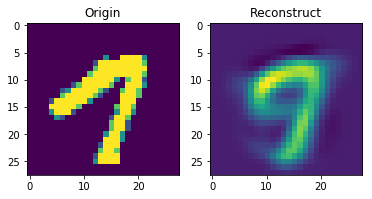

Validation loss = 35.787045(27.547080+8.239965), label=7


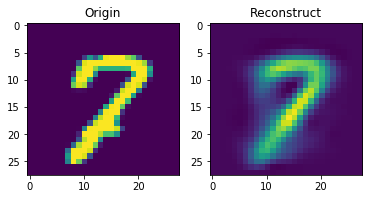

Testing loss = 35.809300(27.570306+8.238994), label=5


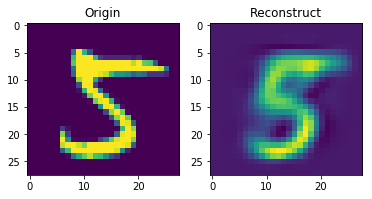

[Epoch 182] 16:13:50
[iteration 100]loss=40.120113(31.428135+8.691978)
[iteration 200]loss=35.642517(27.930168+7.712347)
[iteration 300]loss=38.231255(29.861408+8.369848)
[iteration 400]loss=37.135731(28.682892+8.452839)
[iteration 500]loss=36.786198(28.417774+8.368423)
[iteration 600]loss=36.940792(28.310192+8.630601)
[iteration 700]loss=36.322990(28.031563+8.291430)
[iteration 800]loss=38.040375(29.451950+8.588426)
Training loss = 35.906196(27.733158+8.173039), label=2


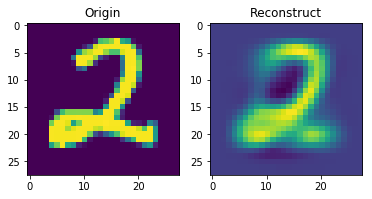

Validation loss = 35.443442(27.258684+8.184758), label=0


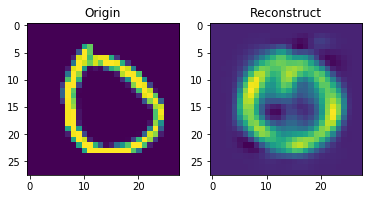

Testing loss = 35.643424(27.434913+8.208510), label=7


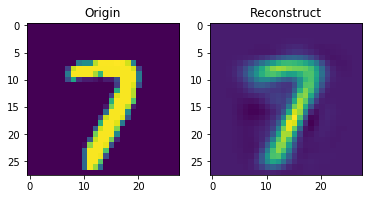

[Epoch 183] 16:13:55
[iteration 100]loss=35.242905(27.304056+7.938848)
[iteration 200]loss=38.464535(30.102802+8.361733)
[iteration 300]loss=37.811829(29.290579+8.521248)
[iteration 400]loss=35.183029(27.034464+8.148564)
[iteration 500]loss=36.306610(28.094490+8.212122)
[iteration 600]loss=35.386169(26.936306+8.449863)
[iteration 700]loss=35.904343(28.034693+7.869651)
[iteration 800]loss=36.786732(28.997725+7.789009)
Training loss = 35.877707(27.718849+8.158858), label=2


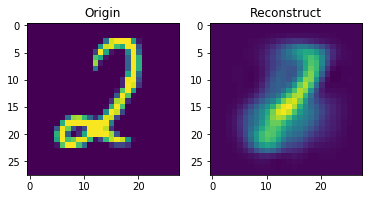

Validation loss = 35.735220(27.522676+8.212544), label=5


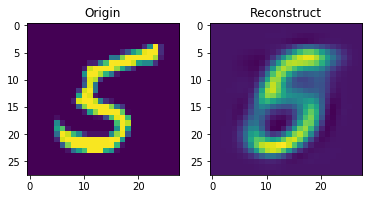

Testing loss = 35.825723(27.552582+8.273141), label=1


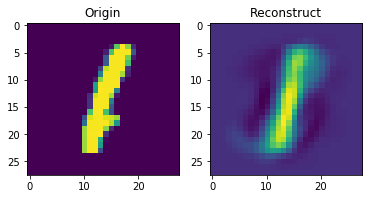

[Epoch 184] 16:13:59
[iteration 100]loss=38.675438(30.410221+8.265215)
[iteration 200]loss=38.846378(30.613131+8.233248)
[iteration 300]loss=36.490555(27.923061+8.567493)
[iteration 400]loss=34.653648(26.516315+8.137331)
[iteration 500]loss=35.223965(27.249960+7.974005)
[iteration 600]loss=39.784103(31.822803+7.961300)
[iteration 700]loss=36.376144(27.973454+8.402690)
[iteration 800]loss=36.869186(28.211945+8.657240)
Training loss = 35.836005(27.671223+8.164782), label=6


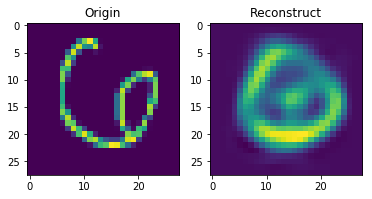

Validation loss = 35.690813(27.447477+8.243336), label=6


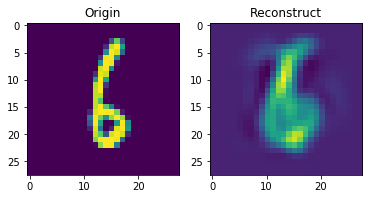

Testing loss = 35.770503(27.562025+8.208477), label=9


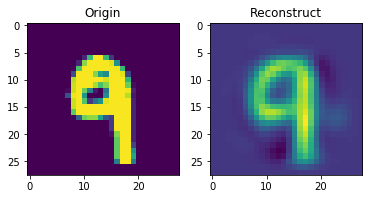

[Epoch 185] 16:14:04
[iteration 100]loss=40.403732(32.058720+8.345014)
[iteration 200]loss=38.317604(30.123152+8.194450)
[iteration 300]loss=38.951775(30.664482+8.287292)
[iteration 400]loss=36.492149(27.991238+8.500912)
[iteration 500]loss=36.656708(28.292927+8.363782)
[iteration 600]loss=36.565517(28.321486+8.244032)
[iteration 700]loss=38.090347(29.988735+8.101610)
[iteration 800]loss=36.694611(28.445786+8.248823)
Training loss = 35.909662(27.743251+8.166410), label=6


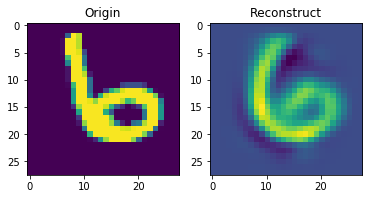

Validation loss = 35.553947(27.377266+8.176681), label=1


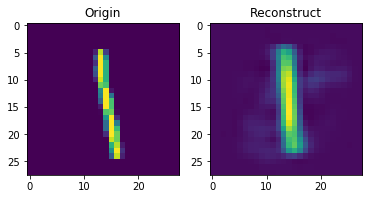

Testing loss = 35.601932(27.399263+8.202669), label=7


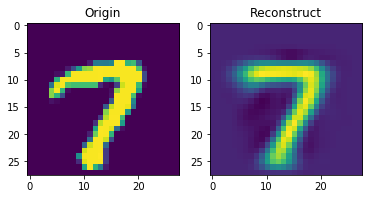

[Epoch 186] 16:14:08
[iteration 100]loss=37.941006(29.969086+7.971921)
[iteration 200]loss=37.391529(28.731686+8.659843)
[iteration 300]loss=39.635818(31.353336+8.282484)
[iteration 400]loss=36.687557(28.543610+8.143949)
[iteration 500]loss=39.221825(31.108921+8.112904)
[iteration 600]loss=40.280403(31.631447+8.648954)
[iteration 700]loss=37.109955(28.776499+8.333454)
[iteration 800]loss=34.802956(26.571972+8.230986)
Training loss = 35.896682(27.726122+8.170560), label=0


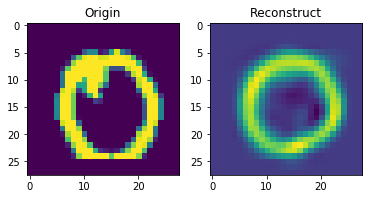

Validation loss = 35.574583(27.337533+8.237050), label=5


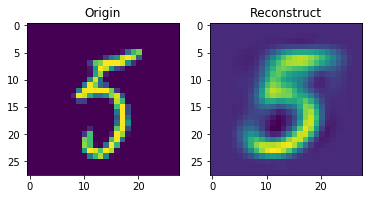

Testing loss = 35.839414(27.595330+8.244083), label=7


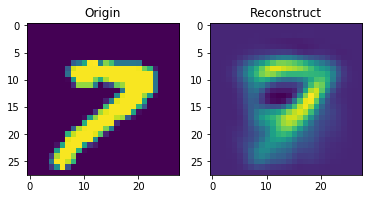

[Epoch 187] 16:14:12
[iteration 100]loss=36.265930(28.213331+8.052598)
[iteration 200]loss=35.900269(27.767195+8.133072)
[iteration 300]loss=36.456177(27.967833+8.488344)
[iteration 400]loss=38.357086(30.196169+8.160919)
[iteration 500]loss=35.770138(27.714687+8.055450)
[iteration 600]loss=36.916618(28.639595+8.277025)
[iteration 700]loss=35.604851(27.501236+8.103615)
[iteration 800]loss=36.579086(27.985840+8.593246)
Training loss = 35.906040(27.726056+8.179984), label=1


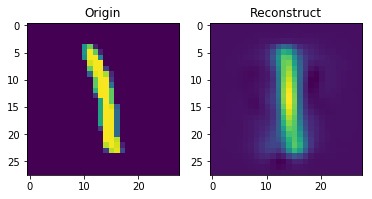

Validation loss = 35.449542(27.269697+8.179845), label=8


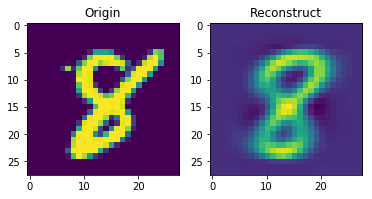

Testing loss = 35.603922(27.379742+8.224180), label=5


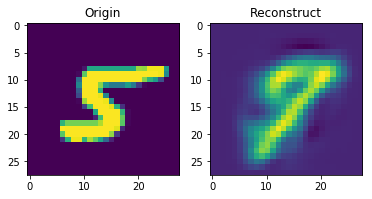

[Epoch 188] 16:14:17
[iteration 100]loss=38.100197(29.182953+8.917244)
[iteration 200]loss=36.381592(27.540943+8.840647)
[iteration 300]loss=36.462166(28.226555+8.235613)
[iteration 400]loss=35.551735(27.142200+8.409534)
[iteration 500]loss=38.198288(29.477177+8.721111)
[iteration 600]loss=37.135250(28.529415+8.605835)
[iteration 700]loss=37.494621(29.062616+8.432005)
[iteration 800]loss=37.131256(29.134819+7.996439)
Training loss = 35.863549(27.698290+8.165259), label=0


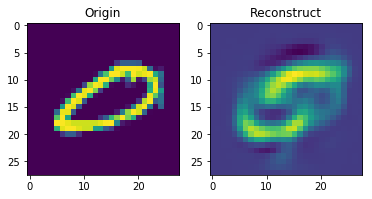

Validation loss = 35.880443(27.616281+8.264162), label=4


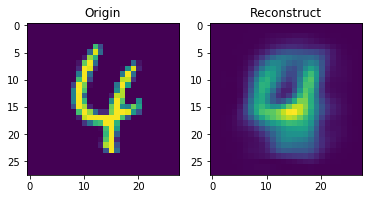

Testing loss = 35.825936(27.606098+8.219838), label=3


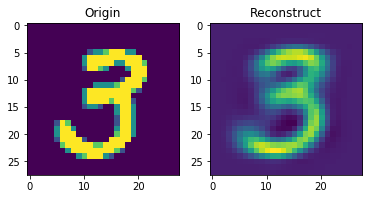

[Epoch 189] 16:14:21
[iteration 100]loss=38.186531(29.544151+8.642382)
[iteration 200]loss=36.050262(27.563919+8.486341)
[iteration 300]loss=38.699074(30.090023+8.609053)
[iteration 400]loss=36.358784(27.808992+8.549791)
[iteration 500]loss=36.800327(28.668194+8.132134)
[iteration 600]loss=37.061413(28.235455+8.825958)
[iteration 700]loss=39.228954(30.311283+8.917672)
[iteration 800]loss=37.426552(29.101484+8.325068)
Training loss = 35.824585(27.660027+8.164557), label=1


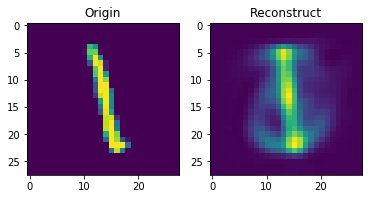

Validation loss = 35.610595(27.405531+8.205064), label=2


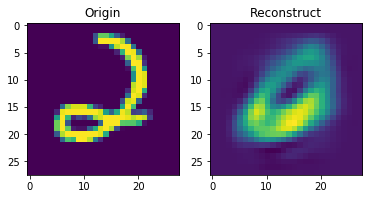

Testing loss = 35.716420(27.463642+8.252779), label=9


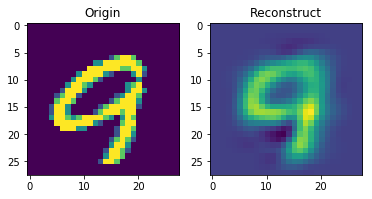

[Epoch 190] 16:14:25
[iteration 100]loss=35.724525(27.218372+8.506155)
[iteration 200]loss=39.633560(30.904335+8.729223)
[iteration 300]loss=38.556553(30.280027+8.276525)
[iteration 400]loss=34.992294(27.120964+7.871328)
[iteration 500]loss=35.803413(27.978718+7.824697)
[iteration 600]loss=36.999767(28.728647+8.271120)
[iteration 700]loss=38.955009(30.172304+8.782704)
[iteration 800]loss=36.349239(27.967770+8.381470)
Training loss = 35.905693(27.736046+8.169647), label=4


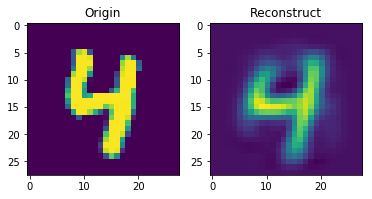

Validation loss = 35.540951(27.353859+8.187093), label=3


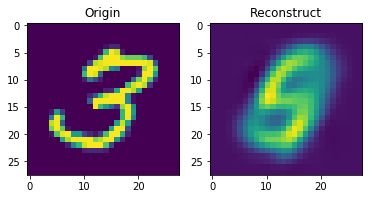

Testing loss = 35.786203(27.550631+8.235572), label=8


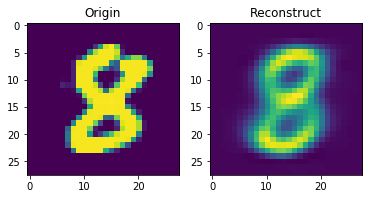

[Epoch 191] 16:14:29
[iteration 100]loss=37.669991(29.158813+8.511177)
[iteration 200]loss=37.797501(29.410742+8.386757)
[iteration 300]loss=36.575089(28.320200+8.254888)
[iteration 400]loss=36.007542(27.610865+8.396677)
[iteration 500]loss=38.588539(29.540279+9.048262)
[iteration 600]loss=36.374557(28.105379+8.269178)
[iteration 700]loss=36.930565(28.587885+8.342678)
[iteration 800]loss=35.278118(27.250843+8.027274)
Training loss = 35.914227(27.729264+8.184963), label=4


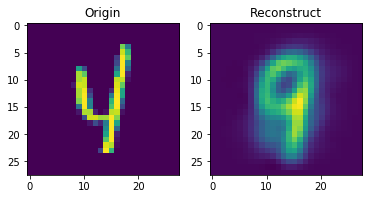

Validation loss = 35.725610(27.510716+8.214894), label=4


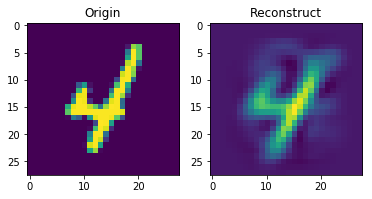

Testing loss = 35.749188(27.532156+8.217033), label=0


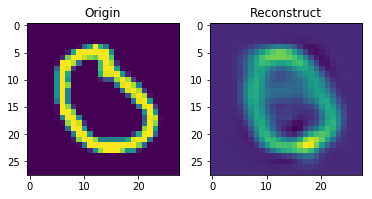

[Epoch 192] 16:14:34
[iteration 100]loss=40.122494(30.948601+9.173894)
[iteration 200]loss=37.046261(28.626778+8.419482)
[iteration 300]loss=37.898201(28.899120+8.999081)
[iteration 400]loss=36.344955(28.074352+8.270601)
[iteration 500]loss=35.889736(27.793528+8.096209)
[iteration 600]loss=37.552074(29.391373+8.160703)
[iteration 700]loss=36.281979(27.653923+8.628057)
[iteration 800]loss=37.252335(28.513615+8.738719)
Training loss = 35.926023(27.746481+8.179542), label=4


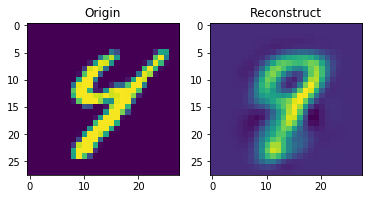

Validation loss = 35.539335(27.323165+8.216171), label=4


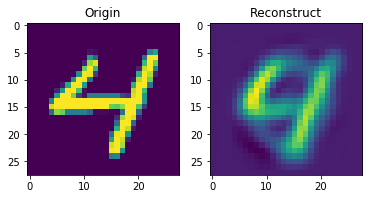

Testing loss = 35.878875(27.635693+8.243182), label=9


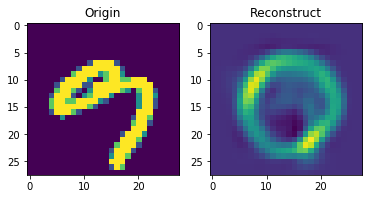

[Epoch 193] 16:14:38
[iteration 100]loss=39.061970(30.596392+8.465578)
[iteration 200]loss=36.280697(27.858467+8.422231)
[iteration 300]loss=36.119686(28.211391+7.908293)
[iteration 400]loss=35.311459(27.090128+8.221331)
[iteration 500]loss=37.326180(28.855646+8.470534)
[iteration 600]loss=35.640083(27.523422+8.116659)
[iteration 700]loss=38.227112(29.568241+8.658873)
[iteration 800]loss=37.158905(28.625546+8.533360)
Training loss = 35.875400(27.690610+8.184790), label=3


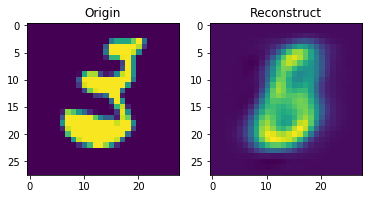

Validation loss = 35.619592(27.395555+8.224037), label=7


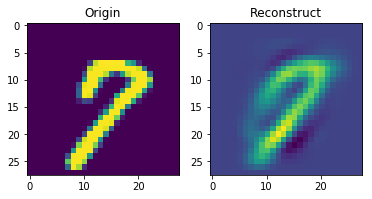

Testing loss = 35.557815(27.338363+8.219452), label=7


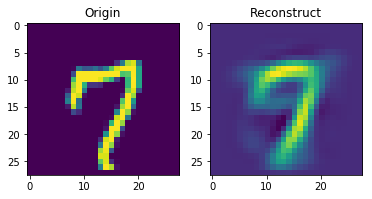

[Epoch 194] 16:14:42
[iteration 100]loss=36.118271(27.844898+8.273373)
[iteration 200]loss=38.910912(30.289497+8.621415)
[iteration 300]loss=38.469597(30.025513+8.444086)
[iteration 400]loss=38.143284(29.608347+8.534937)
[iteration 500]loss=37.341217(29.116669+8.224547)
[iteration 600]loss=36.772984(28.276485+8.496498)
[iteration 700]loss=37.066109(29.065632+8.000476)
[iteration 800]loss=36.222397(27.898933+8.323463)
Training loss = 35.884770(27.726929+8.157842), label=6


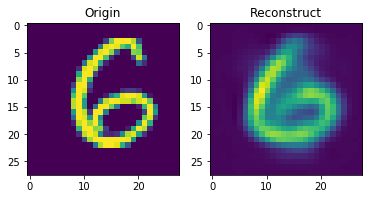

Validation loss = 35.665196(27.428392+8.236804), label=7


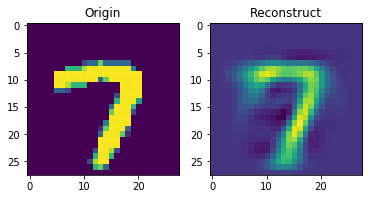

Testing loss = 35.875909(27.612129+8.263781), label=3


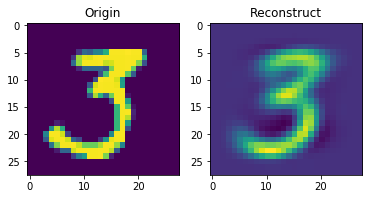

[Epoch 195] 16:14:46
[iteration 100]loss=37.701859(29.818926+7.882934)
[iteration 200]loss=35.714954(27.398602+8.316352)
[iteration 300]loss=36.737907(28.654261+8.083649)
[iteration 400]loss=34.810482(26.842712+7.967769)
[iteration 500]loss=37.918560(29.456530+8.462029)
[iteration 600]loss=38.868713(30.204754+8.663960)
[iteration 700]loss=38.691589(30.043653+8.647934)
[iteration 800]loss=35.123970(27.299566+7.824403)
Training loss = 35.902443(27.736421+8.166022), label=0


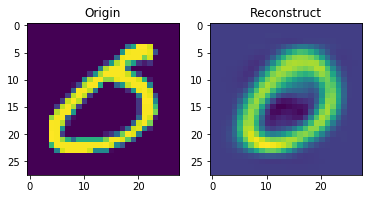

Validation loss = 35.634826(27.443357+8.191469), label=9


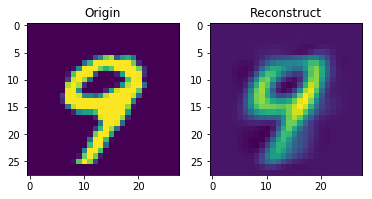

Testing loss = 35.577226(27.388496+8.188730), label=2


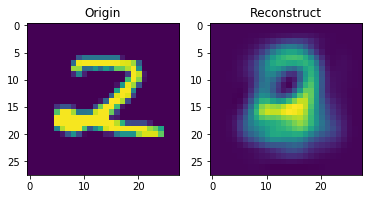

[Epoch 196] 16:14:51
[iteration 100]loss=38.919670(30.595497+8.324172)
[iteration 200]loss=39.606571(31.178652+8.427919)
[iteration 300]loss=37.129749(28.836706+8.293044)
[iteration 400]loss=37.866055(29.295460+8.570595)
[iteration 500]loss=38.433624(30.015701+8.417921)
[iteration 600]loss=39.637157(31.432535+8.204622)
[iteration 700]loss=36.513298(28.497974+8.015322)
[iteration 800]loss=36.022327(27.947285+8.075043)
Training loss = 35.851652(27.692665+8.158987), label=5


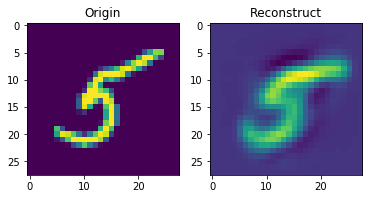

Validation loss = 35.783051(27.570068+8.212983), label=1


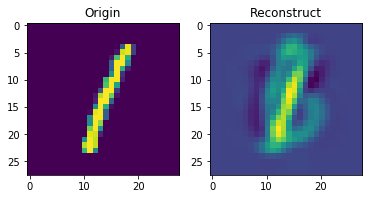

Testing loss = 35.673789(27.431625+8.242164), label=8


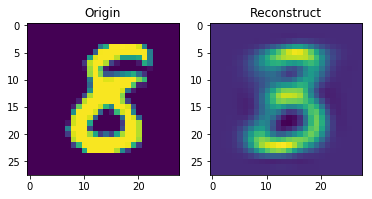

[Epoch 197] 16:14:55
[iteration 100]loss=38.256458(29.564980+8.691480)
[iteration 200]loss=37.802849(29.380199+8.422651)
[iteration 300]loss=35.743042(27.641556+8.101488)
[iteration 400]loss=36.399448(28.615551+7.783898)
[iteration 500]loss=39.314552(31.068432+8.246120)
[iteration 600]loss=37.183270(28.651955+8.531315)
[iteration 700]loss=36.813766(28.771688+8.042080)
[iteration 800]loss=37.963394(29.548048+8.415348)
Training loss = 35.860207(27.689622+8.170584), label=6


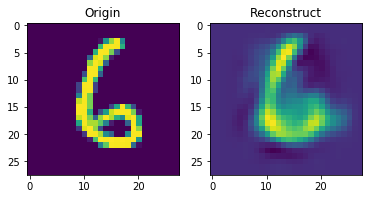

Validation loss = 35.484333(27.263107+8.221227), label=2


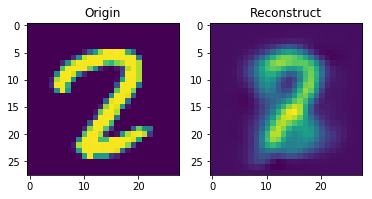

Testing loss = 35.691725(27.440645+8.251080), label=2


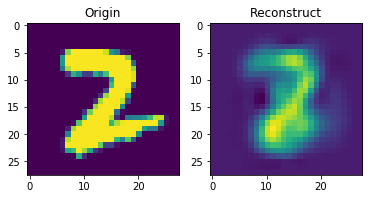

[Epoch 198] 16:14:59
[iteration 100]loss=34.661613(26.081043+8.580571)
[iteration 200]loss=37.597206(28.991247+8.605959)
[iteration 300]loss=37.958076(29.504066+8.454010)
[iteration 400]loss=36.008106(28.061359+7.946746)
[iteration 500]loss=39.365913(30.812895+8.553018)
[iteration 600]loss=36.424049(28.639317+7.784735)
[iteration 700]loss=38.825012(30.421452+8.403563)
[iteration 800]loss=38.161640(30.060129+8.101510)
Training loss = 35.843998(27.680537+8.163461), label=0


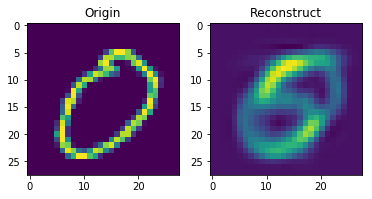

Validation loss = 35.747407(27.504984+8.242422), label=9


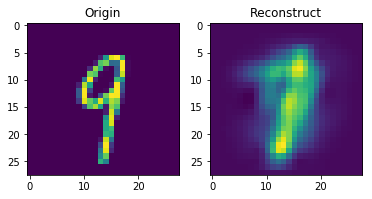

Testing loss = 35.759044(27.542197+8.216847), label=9


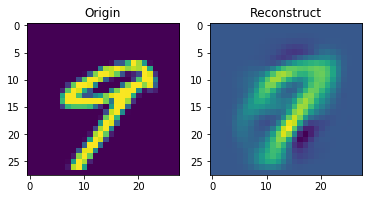

[Epoch 199] 16:15:04
[iteration 100]loss=36.387009(28.134613+8.252394)
[iteration 200]loss=37.378685(29.319977+8.058706)
[iteration 300]loss=38.899506(30.475327+8.424179)
[iteration 400]loss=38.030388(29.864079+8.166309)
[iteration 500]loss=39.645966(30.954037+8.691929)
[iteration 600]loss=39.569237(30.451262+9.117974)
[iteration 700]loss=39.124451(30.603323+8.521130)
[iteration 800]loss=37.720360(29.083450+8.636909)
Training loss = 35.890555(27.722053+8.168502), label=5


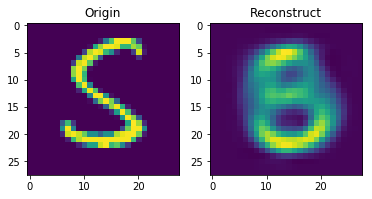

Validation loss = 35.326383(27.145767+8.180617), label=9


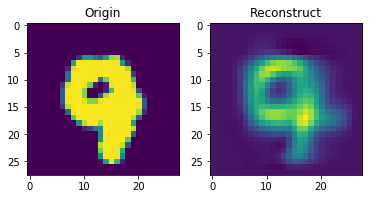

Testing loss = 35.673419(27.447638+8.225781), label=6


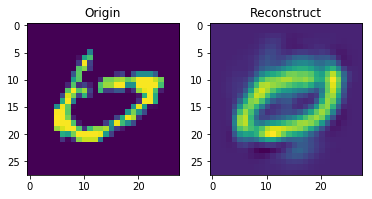

[Epoch 200] 16:15:08
[iteration 100]loss=40.209343(31.657225+8.552116)
[iteration 200]loss=37.427826(29.318932+8.108894)
[iteration 300]loss=39.886421(31.124317+8.762104)
[iteration 400]loss=38.112122(29.617901+8.494219)
[iteration 500]loss=38.107063(29.242153+8.864910)
[iteration 600]loss=37.510902(28.914280+8.596623)
[iteration 700]loss=35.434784(26.667751+8.767035)
[iteration 800]loss=37.522709(28.872074+8.650634)
Training loss = 35.936453(27.757749+8.178704), label=4


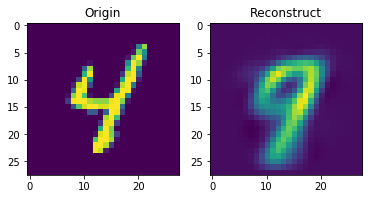

Validation loss = 35.885325(27.641616+8.243709), label=7


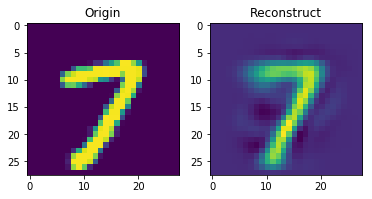

Testing loss = 35.787582(27.557020+8.230562), label=6


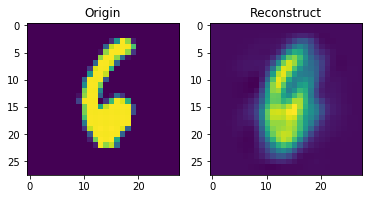

In [14]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run()
    for epoch in range(n_epoch):
        print("[Epoch %d] "%(epoch+1)+time.strftime("%H:%M:%S",time.localtime()))
        train()
        evalutaion()